In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy.stats import ttest_ind, chi2_contingency, zscore

# Preprocesamiento y Modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer # Para manejar NaNs si aún existen

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    RocCurveDisplay
)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Configuraciones para mejor visualización
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None) # Mostrar todas las columnas
import warnings
warnings.filterwarnings('ignore') # Ignorar warnings para limpieza

# Descriptivos datos de CV extraidos

In [2]:
file_path = "../Bases/base_cvs/base_cvs_mejorado.csv"  # Ajusta el path si es necesario
df = pd.read_csv(file_path)
df = df.drop(columns=["Unnamed: 0", "archivo"], errors="ignore")  # errors="ignore" evita fallos si ya no existe

In [3]:
df

Categoria Original  Passed status_procesamiento  Numero de Paginas  \
0              Exitoso       1           Completado                  2   
1              Exitoso       1           Completado                  1   
2              Exitoso       1           Completado                  1   
3              Exitoso       1           Completado                  4   
4              Exitoso       1           Completado                  3   
..                 ...     ...                  ...                ...   
630         No Exitoso       0           Completado                  6   
631         No Exitoso       0           Completado                 10   
632         No Exitoso       0           Completado                  3   
633         No Exitoso       0           Completado                  1   
634         No Exitoso       0           Completado                  4   

     Cantidad de Palabras  Densidad Informacion (%) Formato Texto (Lineas)  \
0                     493                      5.71                Viñetas   
1                     388                      8.09                Viñetas   
2                     378                      8.27                  Mixto   
3                     656                      3.54                Viñetas   
4                     160                      4.71                Viñetas   
..                    ...                       ...                    ...   
630                  1372                      4.37                Viñetas   
631                  3729                      7.54                Viñetas   
632                   899                      6.13                Viñetas   
633                   185                      3.93                Viñetas   
634                   534                      5.95                Viñetas   

               Orden Temporal  Fechas Detectadas (Count)  \
0    Orden Temporal Detectado                          3   
1                Pocas Fechas                          1   
2                Pocas Fechas                          0   
3    Orden Temporal Detectado                          2   
4                Pocas Fechas                          0   
..                        ...                        ...   
630              Pocas Fechas                          0   
631  Orden Temporal Detectado                          3   
632              Pocas Fechas                          1   
633  Orden Temporal Detectado                          2   
634              Pocas Fechas                          0   

         Formato Fecha Más Común          Fuente principal  \
0                  Mon YYYY (EN)             Garamond-Bold   
1                        MM/YYYY  NotoSansZanabazarSquare-   
2                  Mon YYYY (EN)                   ArialMT   
3    SpaCy DATE (Sin clasificar)        Montserrat-Regular   
4                           YYYY              Lato-Regular   
..                           ...                       ...   
630                Mon YYYY (EN)                   Calibri   
631                         YYYY                   Calibri   
632  SpaCy DATE (Sin clasificar)             OpenSans-Bold   
633                         YYYY      DidactGothic-Regular   
634           Mes YYYY (ES Comp)               ComicSansMS   

     Tamaño cuerpo probable        Legibilidad general  Variedad de fuentes  \
0                        12                      Buena                    7   
1                         9  Potencialmente Deficiente                    1   
2                        10                      Buena                    3   
3                        10                      Buena                    4   
4                        10                      Buena                    6   
..                      ...                        ...                  ...   
630                      11                      Buena                    8   
631                      11                      Buena                    7   
6

Resumen de estadísticas descriptivas:
           Passed  Numero de Paginas  Cantidad de Palabras  \
count  635.000000         635.000000            635.000000   
mean     0.422047           2.812598            564.771654   
std      0.494275           2.361862            451.408217   
min      0.000000           1.000000              0.000000   
25%      0.000000           2.000000            256.000000   
50%      0.000000           2.000000            480.000000   
75%      1.000000           3.000000            750.000000   
max      1.000000          38.000000           3729.000000   

       Densidad Informacion (%)  Fechas Detectadas (Count)  \
count                635.000000                 635.000000   
mean                   5.841354                   1.338583   
std                    2.474386                   1.902267   
min                    0.000000                   0.000000   
25%                    4.280000                   0.000000   
50%                    5.560000

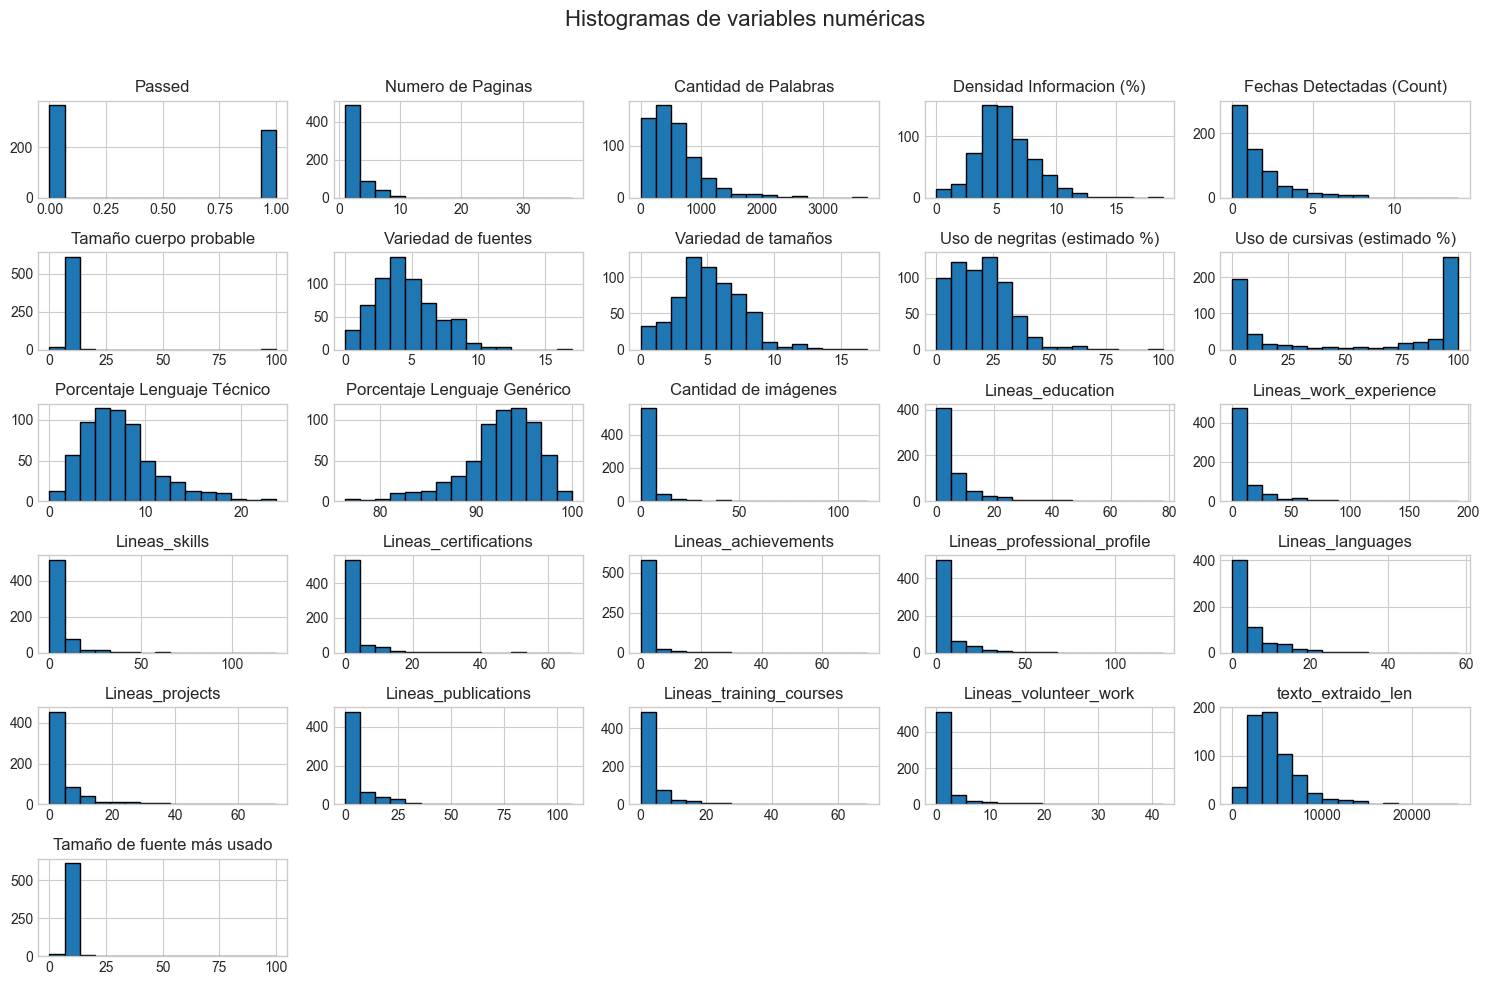

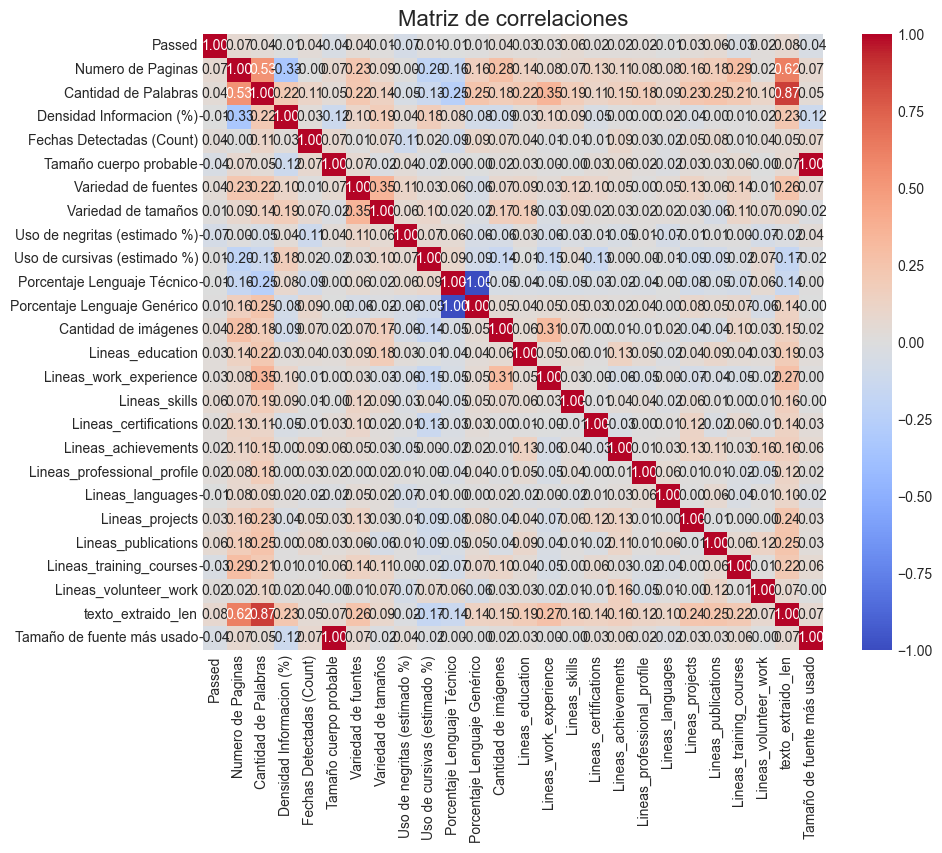

In [4]:
# Análisis descriptivo

# Resumen de estadísticas descriptivas
print("Resumen de estadísticas descriptivas:")
print(df.describe())

# Histogramas para cada variable numérica
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols].hist(figsize=(15, 10), bins=15, edgecolor='black')
plt.suptitle("Histogramas de variables numéricas", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Matriz de correlación
corr_matrix = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlaciones", fontsize=16)
plt.show()

### Descriptivos variables categóricas

Distribución de valores para 'Categoria Original':
Categoria Original
No Exitoso    367
Exitoso       268
Name: count, dtype: int64 



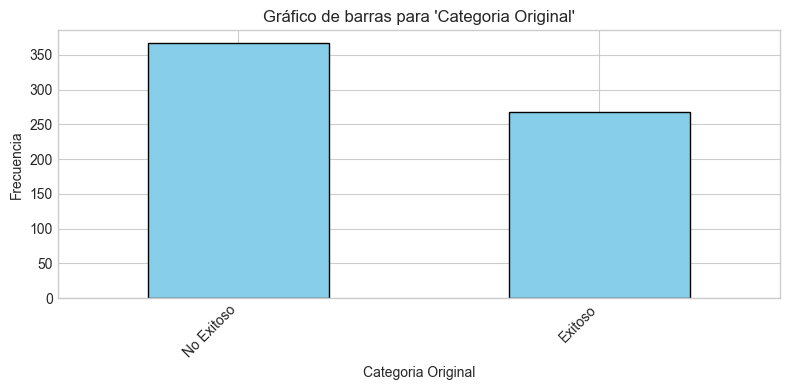

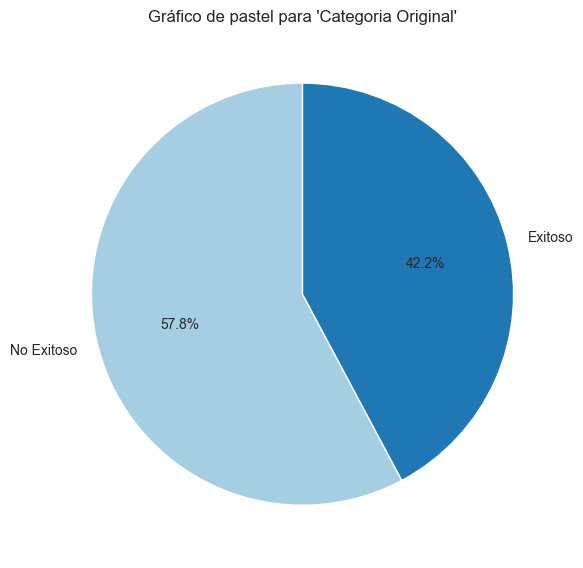

Distribución de valores para 'status_procesamiento':
status_procesamiento
Completado                          626
Advertencia: No se extrajo texto      9
Name: count, dtype: int64 



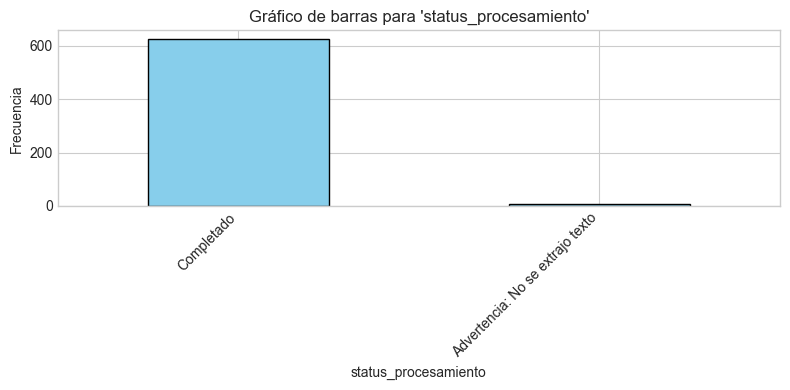

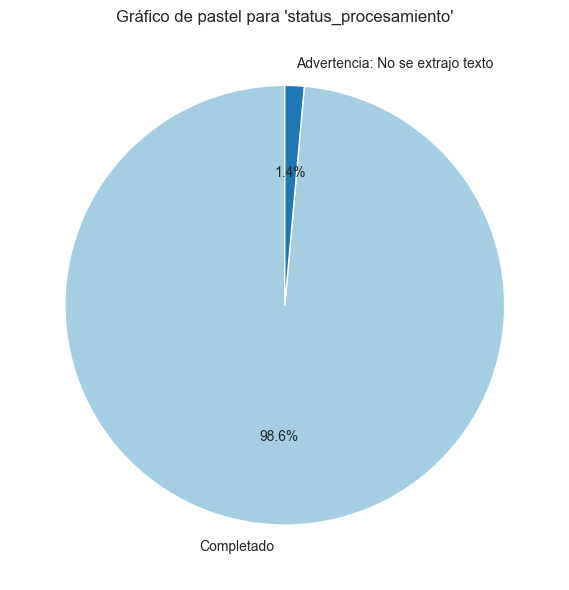

Distribución de valores para 'Formato Texto (Lineas)':
Formato Texto (Lineas)
Viñetas          473
Mixto            133
Párrafos          20
Indeterminado      9
Name: count, dtype: int64 



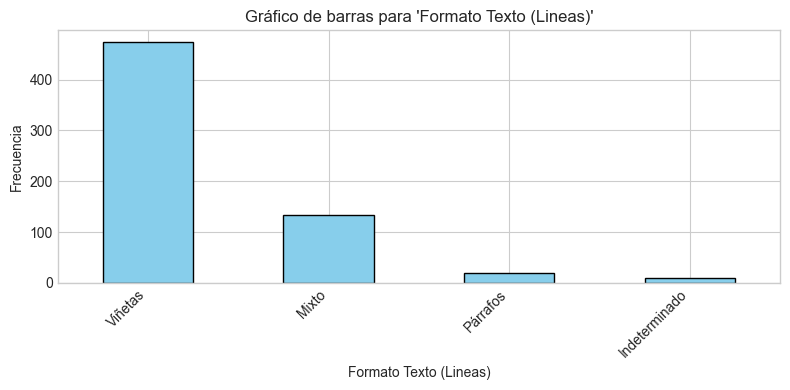

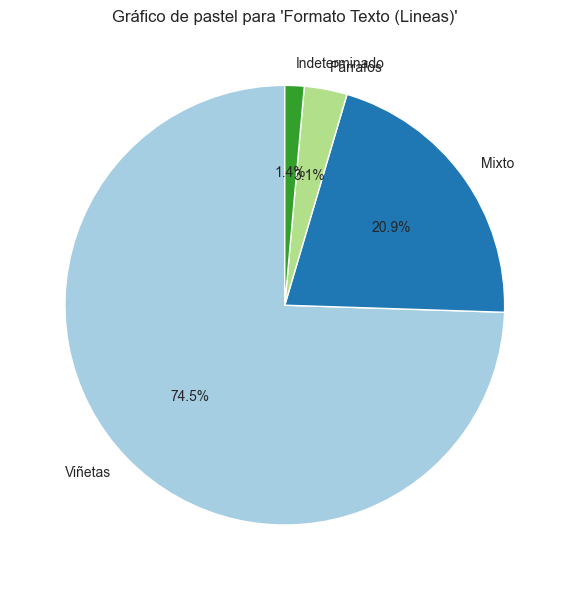

Distribución de valores para 'Orden Temporal':
Orden Temporal
Pocas Fechas                439
Orden Temporal Detectado    196
Name: count, dtype: int64 



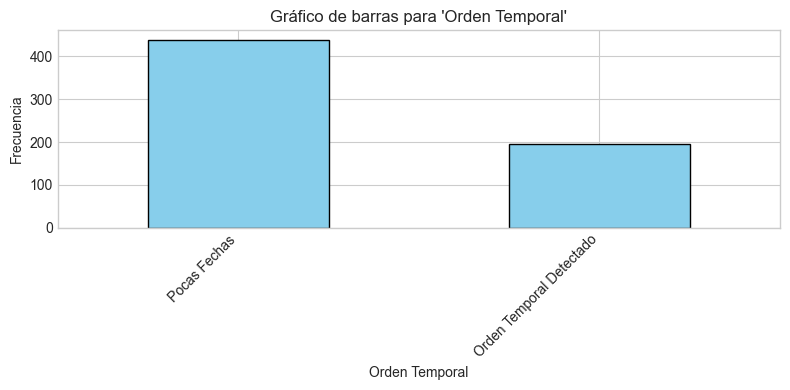

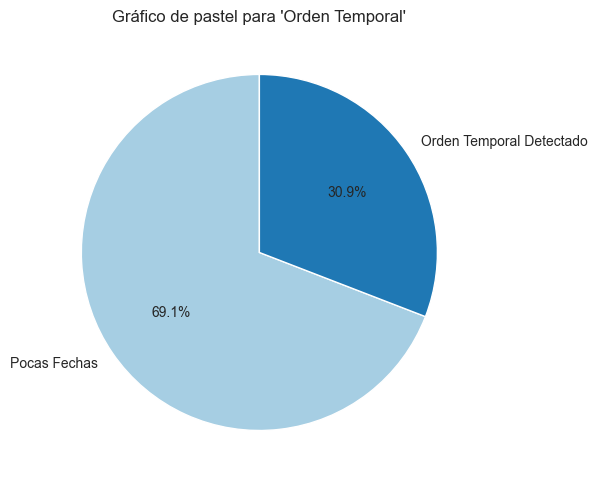

Distribución de valores para 'Formato Fecha Más Común':
Formato Fecha Más Común
YYYY                           251
Mon YYYY (EN)                  104
SpaCy DATE (Sin clasificar)     91
Month YYYY (EN)                 72
MM/YYYY                         59
Mes YYYY (ES Comp)              13
DD/MM/YYYY                      12
Rango YYYY-YYYY                 11
MM-YYYY                          5
YYYY (SpaCy)                     1
Name: count, dtype: int64 



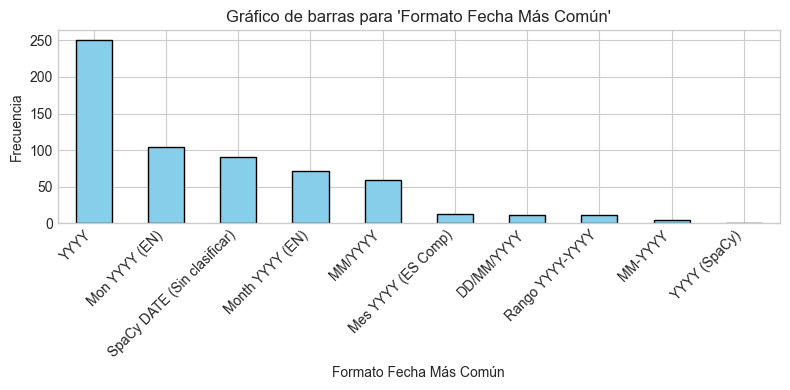

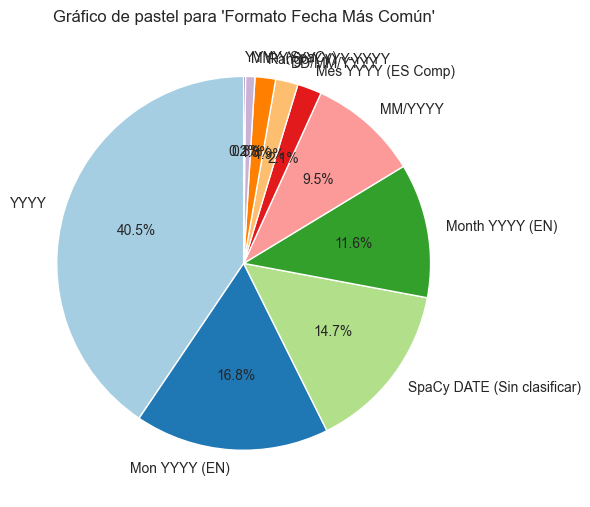

Distribución de valores para 'Fuente principal':
Fuente principal
ArialMT                     84
Calibri                     65
Tahoma                      31
TimesNewRomanPSMT           25
Roboto-Regular              23
                            ..
NotoSansZanabazarSquare-     1
Lato-Bold                    1
Amiko-SemiBold               1
FiraSans-Light               1
ComicSansMS                  1
Name: count, Length: 158, dtype: int64 



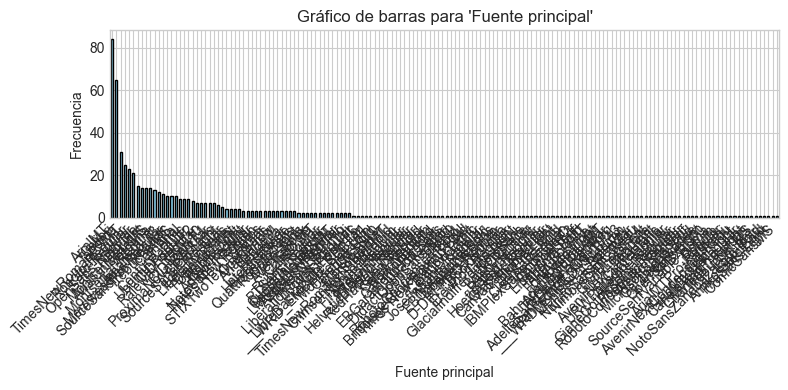

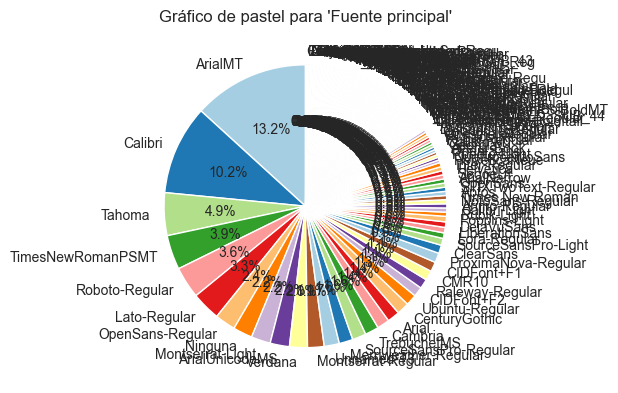

Distribución de valores para 'Legibilidad general':
Legibilidad general
Buena                        431
Potencialmente Deficiente    190
Vacío                         14
Name: count, dtype: int64 



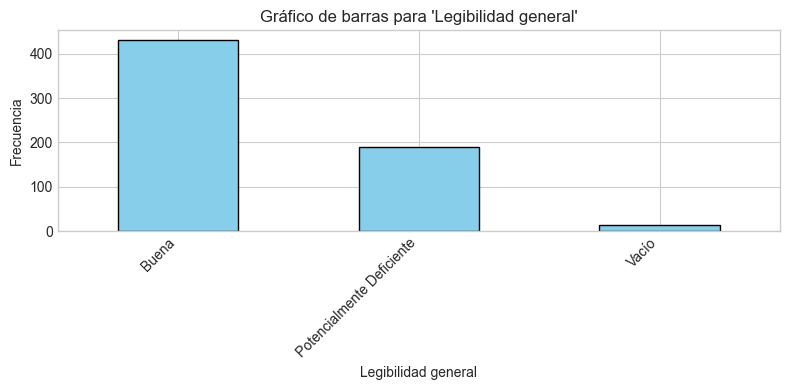

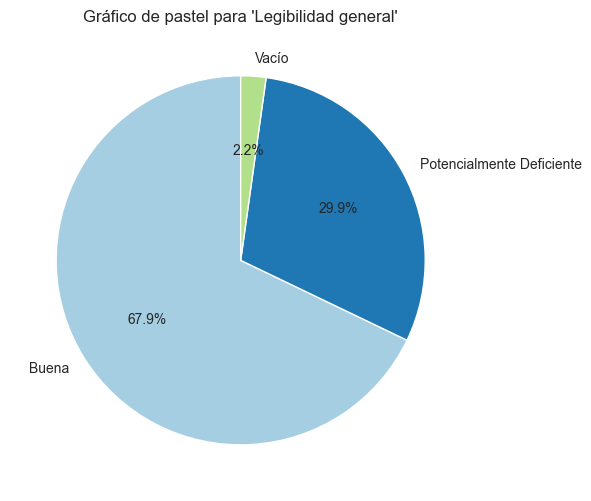

Distribución de valores para 'Consistencia tamaños fuente':
Consistencia tamaños fuente
Consistente      372
Inconsistente    249
Name: count, dtype: int64 



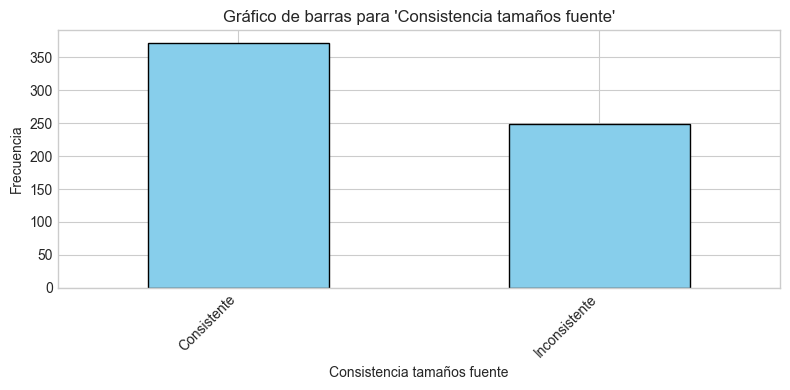

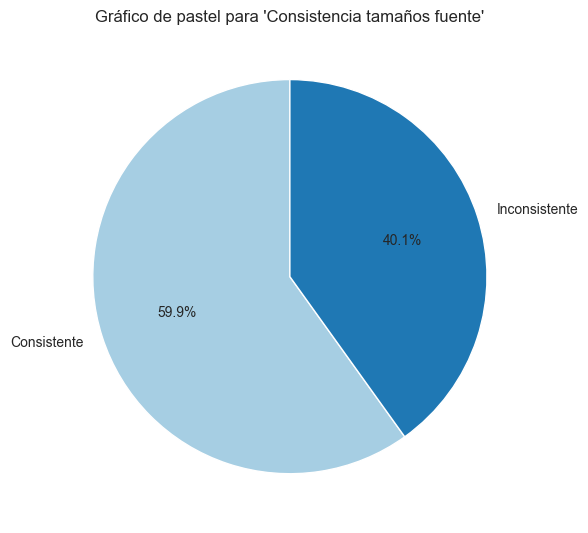

Distribución de valores para 'Consistencia márgenes (aprox)':
Consistencia márgenes (aprox)
Consistente      508
Inconsistente    113
Name: count, dtype: int64 



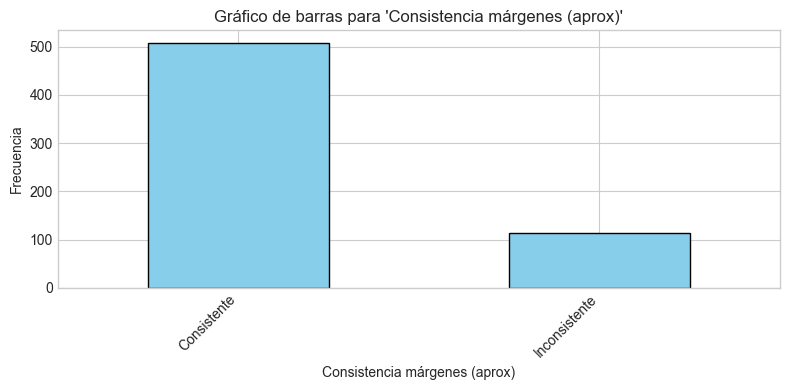

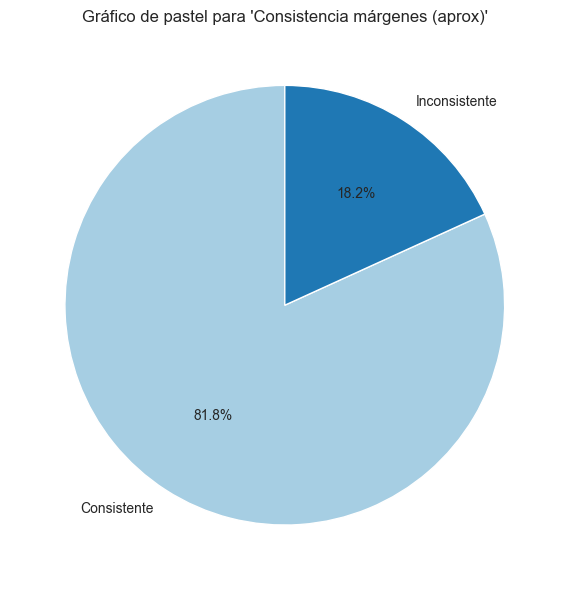

Distribución de valores para 'Uso de colores (texto)':
Uso de colores (texto)
Sí    444
No    191
Name: count, dtype: int64 



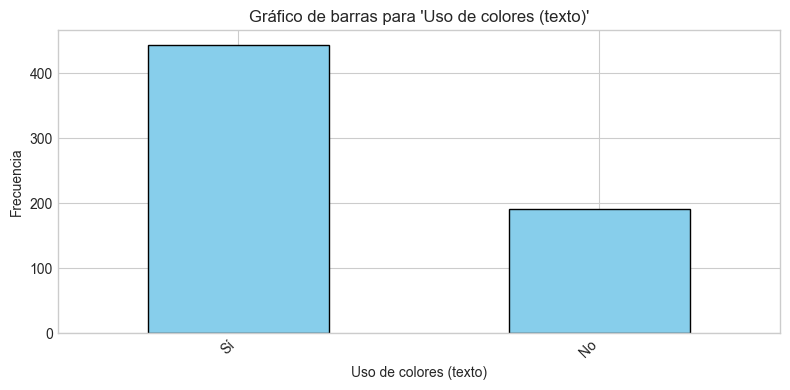

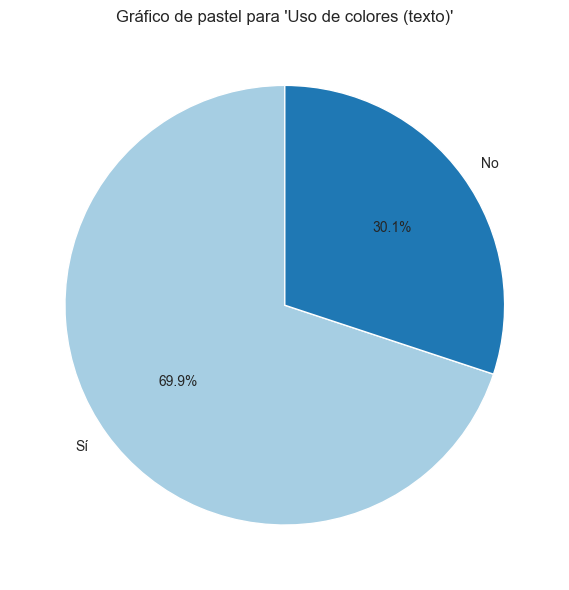

Distribución de valores para 'Uso de colores (dibujos)':
Uso de colores (dibujos)
Sí    401
No    234
Name: count, dtype: int64 



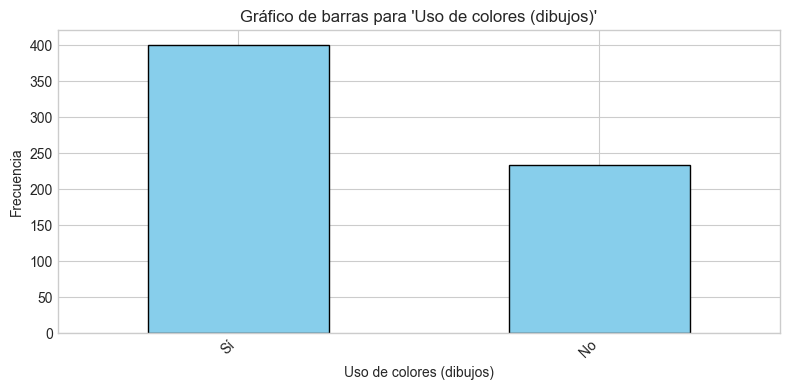

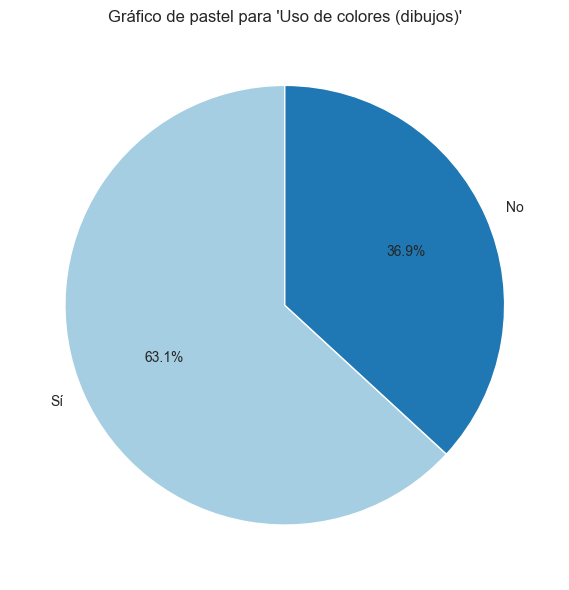

Distribución de valores para 'LinkedIn':
LinkedIn
False    437
True     198
Name: count, dtype: int64 



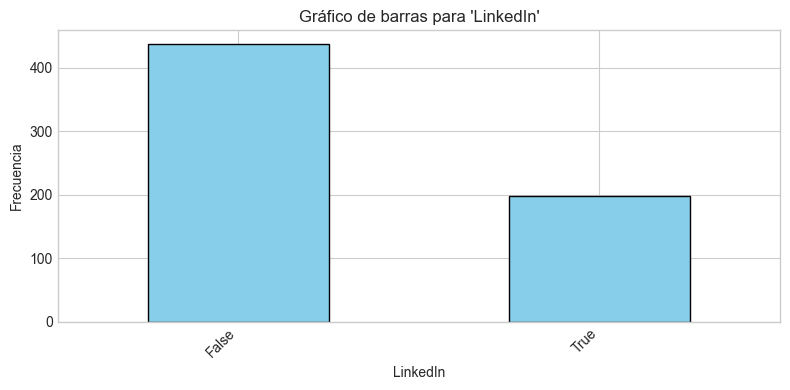

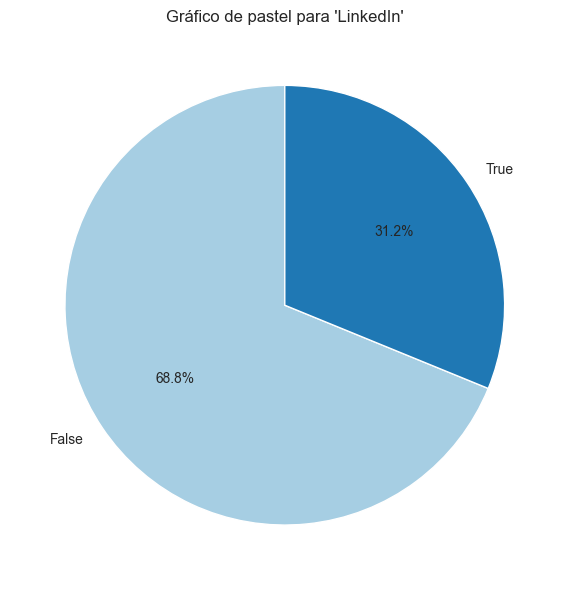

Distribución de valores para 'GitHub':
GitHub
False    564
True      71
Name: count, dtype: int64 



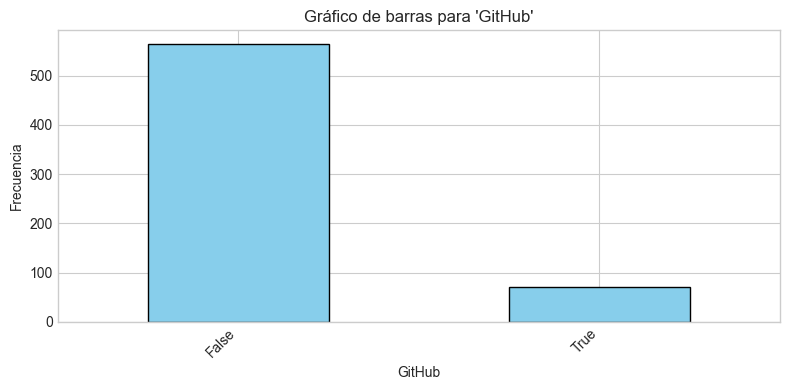

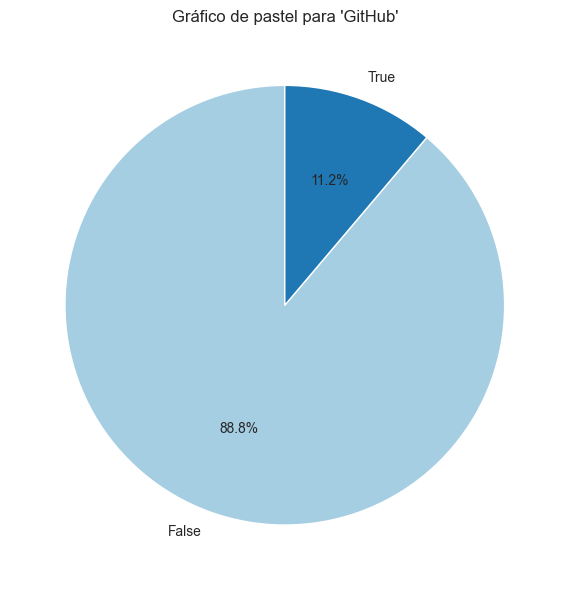

Distribución de valores para 'Website/Otro':
Website/Otro
False    517
True     118
Name: count, dtype: int64 



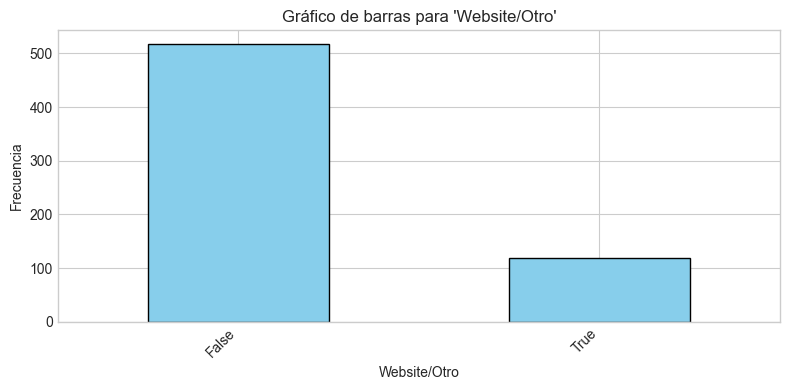

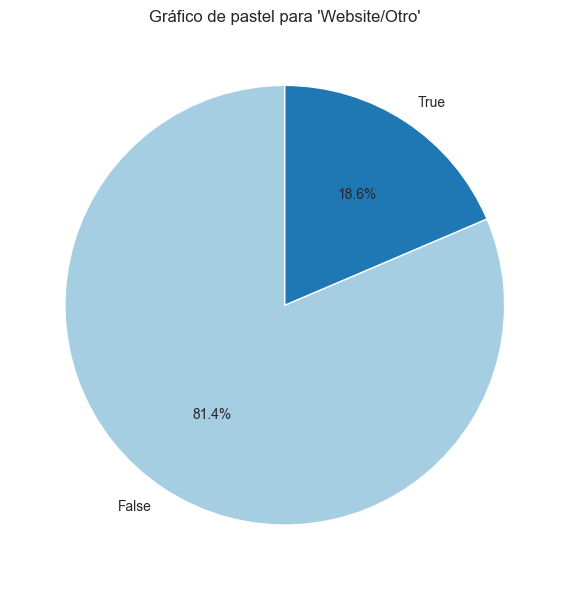

Distribución de valores para 'Deteccion Foto Perfil':
Deteccion Foto Perfil
No se detectaron imágenes candidatas    434
Posible Foto Detectada                  201
Name: count, dtype: int64 



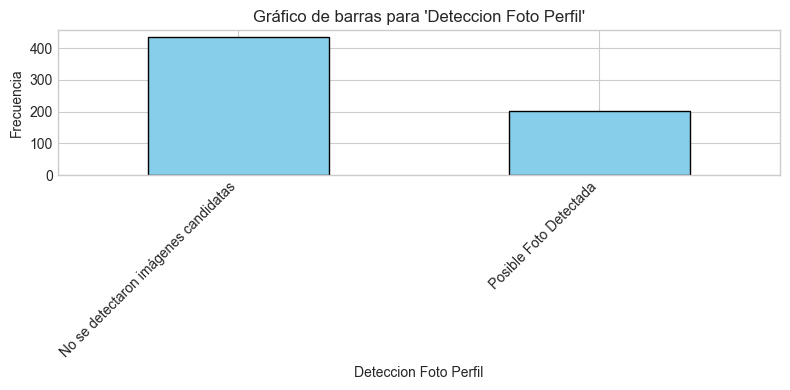

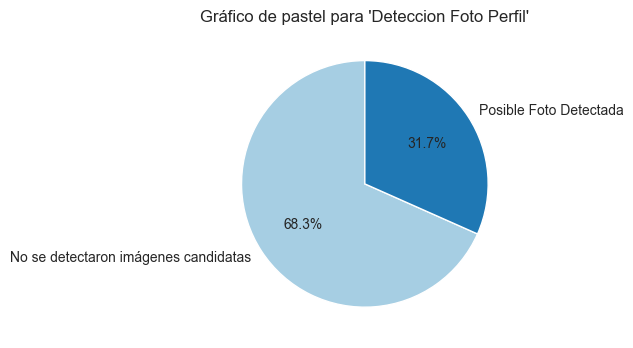

Distribución de valores para 'Tiene Elementos Graficos':
Tiene Elementos Graficos
True     360
False    275
Name: count, dtype: int64 



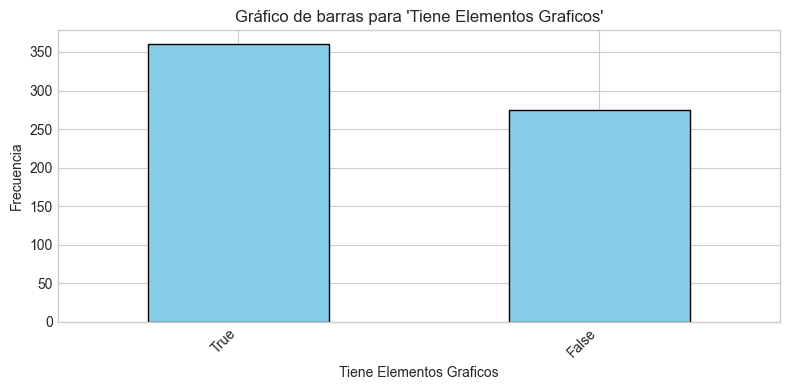

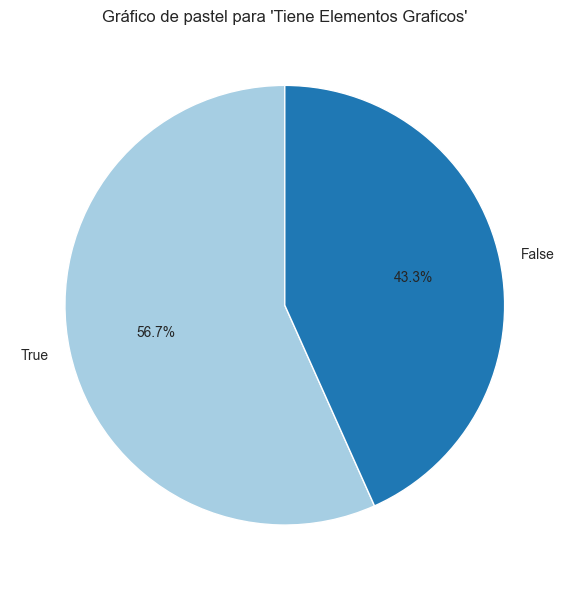

Distribución de valores para 'Seccion_education':
Seccion_education
True     615
False     20
Name: count, dtype: int64 



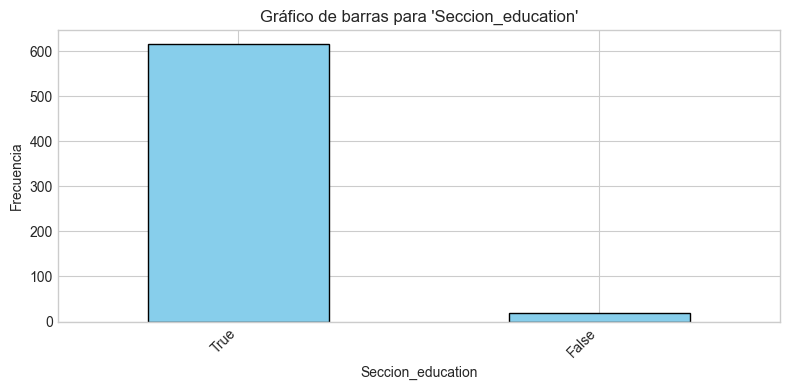

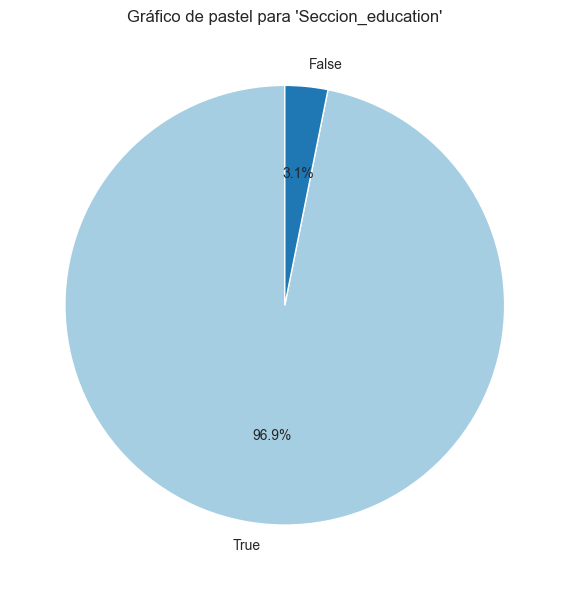

Distribución de valores para 'Seccion_work_experience':
Seccion_work_experience
True     617
False     18
Name: count, dtype: int64 



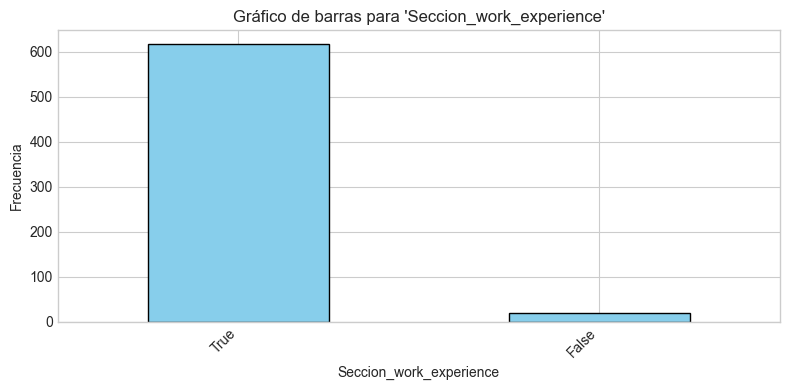

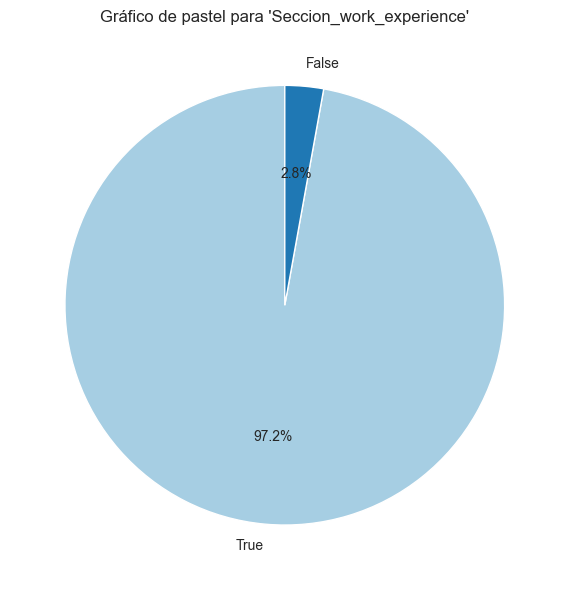

Distribución de valores para 'Seccion_skills':
Seccion_skills
True     586
False     49
Name: count, dtype: int64 



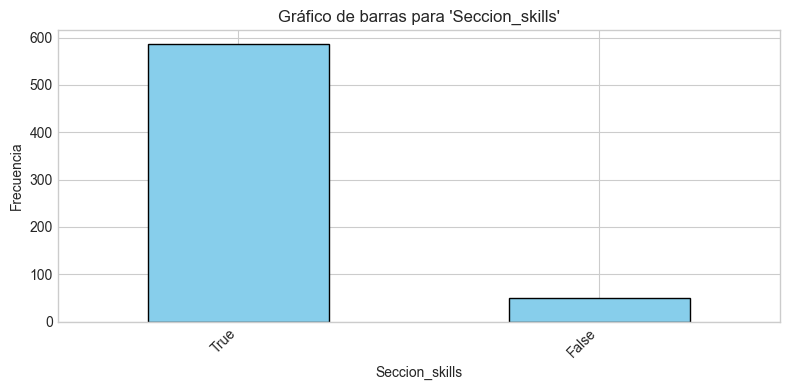

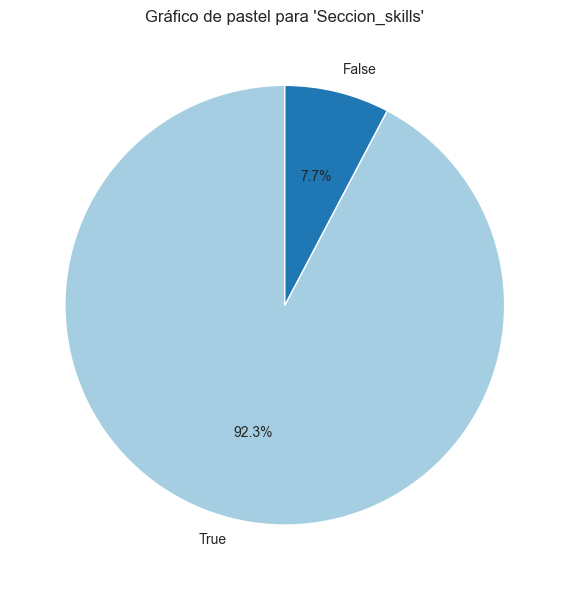

Distribución de valores para 'Seccion_certifications':
Seccion_certifications
True     559
False     76
Name: count, dtype: int64 



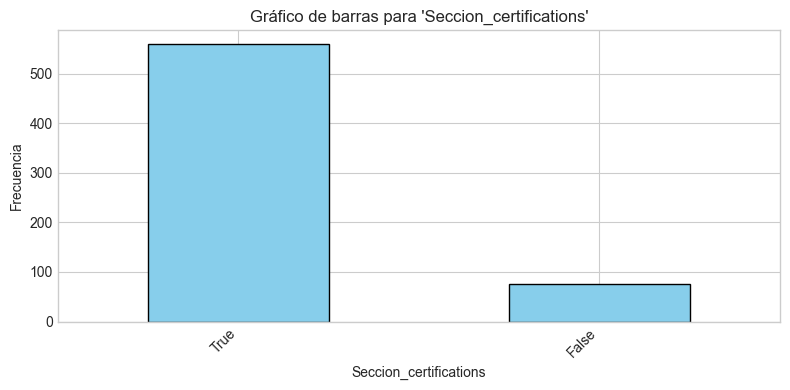

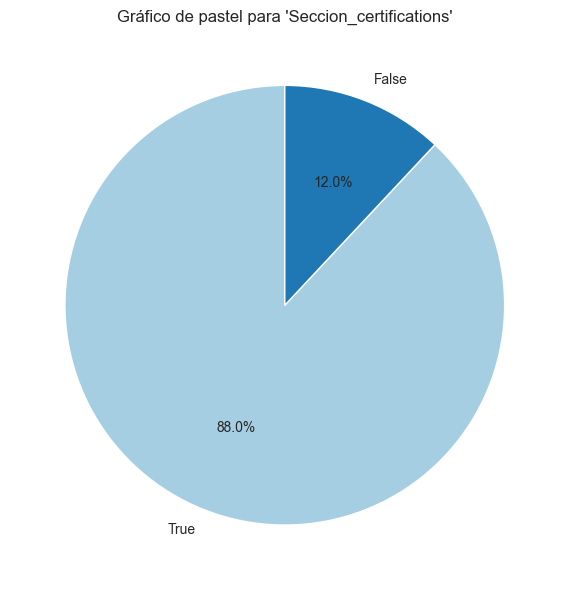

Distribución de valores para 'Seccion_achievements':
Seccion_achievements
False    413
True     222
Name: count, dtype: int64 



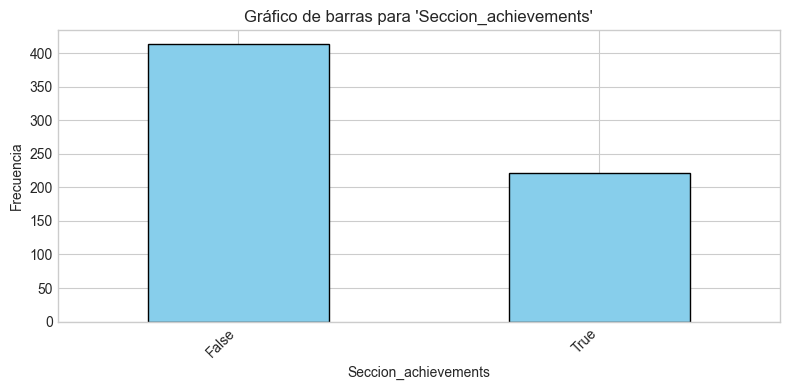

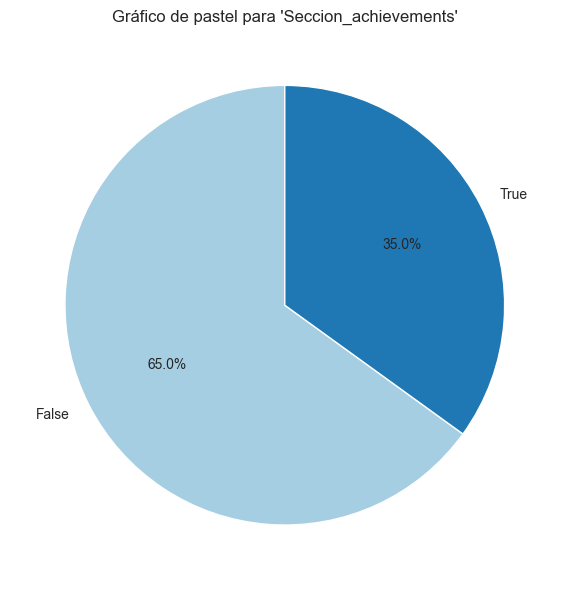

Distribución de valores para 'Seccion_professional_profile':
Seccion_professional_profile
True     587
False     48
Name: count, dtype: int64 



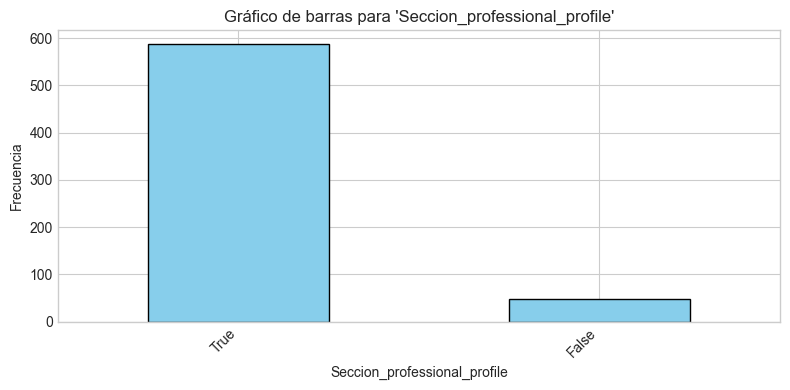

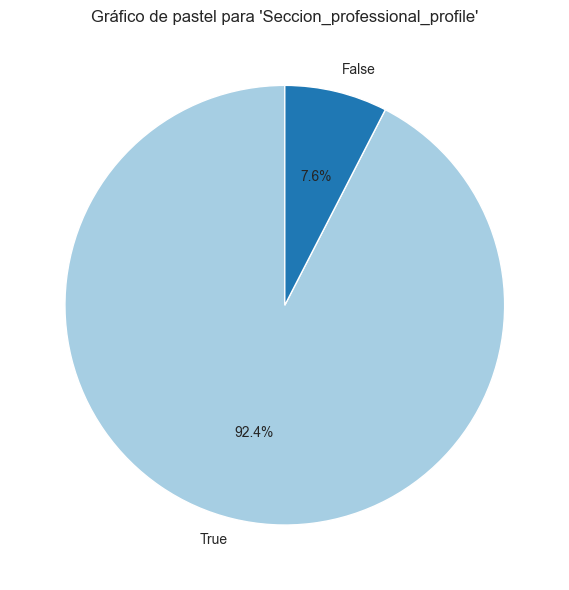

Distribución de valores para 'Seccion_languages':
Seccion_languages
True     564
False     71
Name: count, dtype: int64 



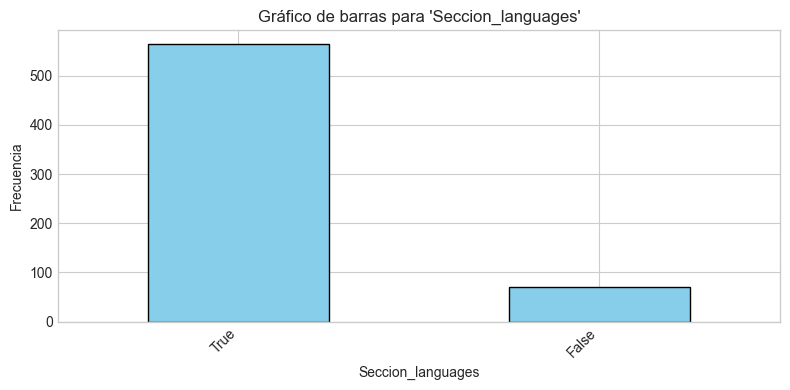

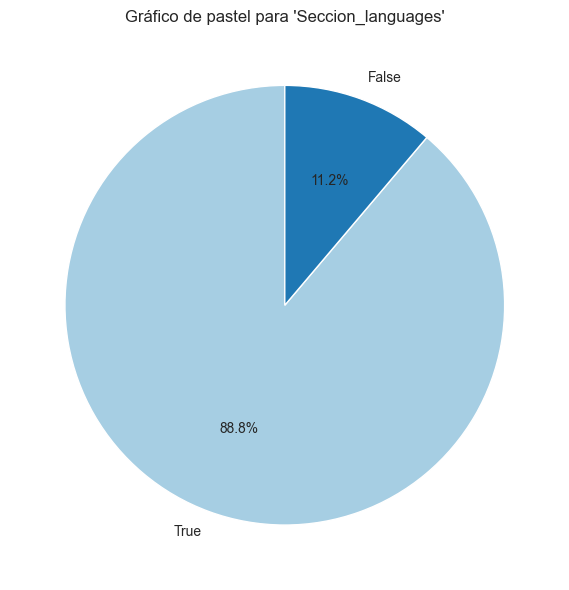

Distribución de valores para 'Seccion_projects':
Seccion_projects
True     562
False     73
Name: count, dtype: int64 



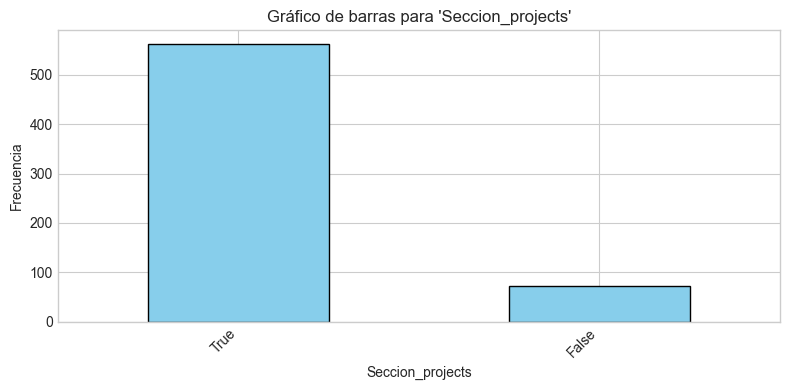

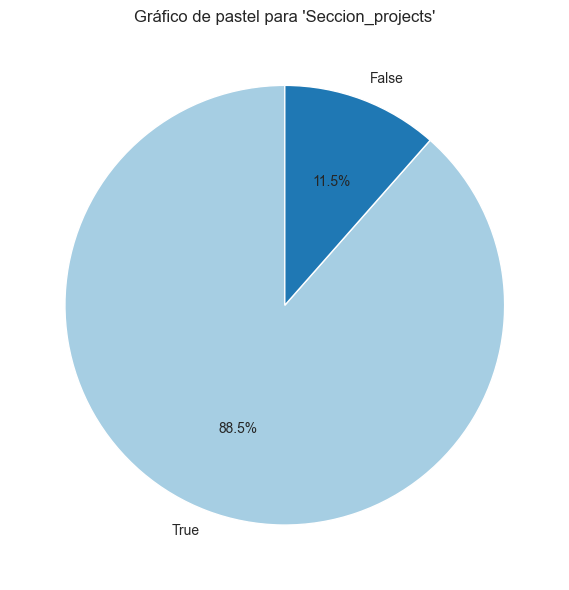

Distribución de valores para 'Seccion_publications':
Seccion_publications
True     619
False     16
Name: count, dtype: int64 



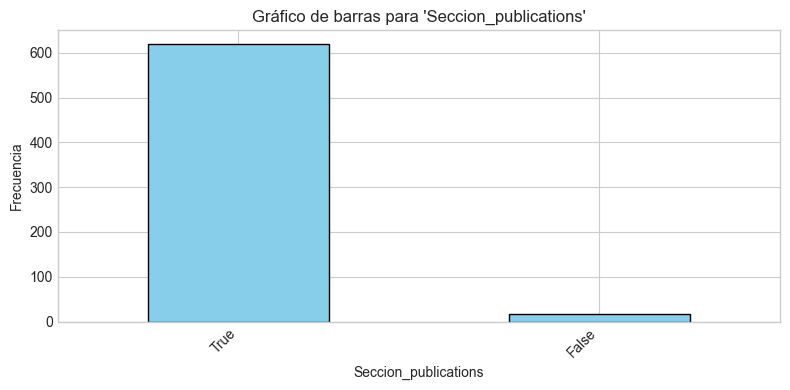

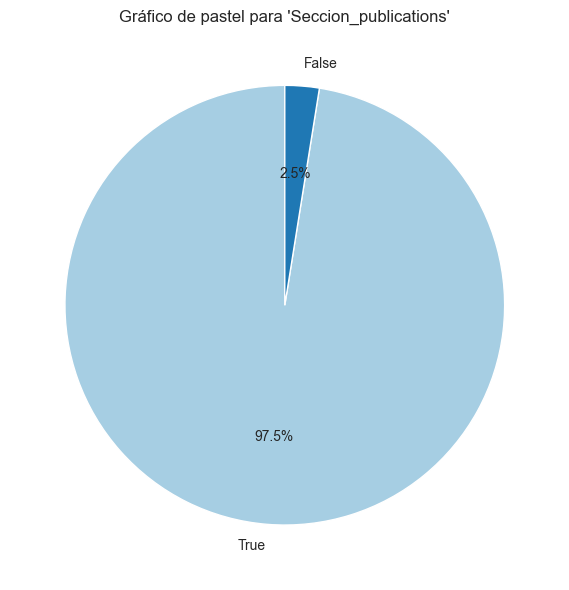

Distribución de valores para 'Seccion_training_courses':
Seccion_training_courses
True     514
False    121
Name: count, dtype: int64 



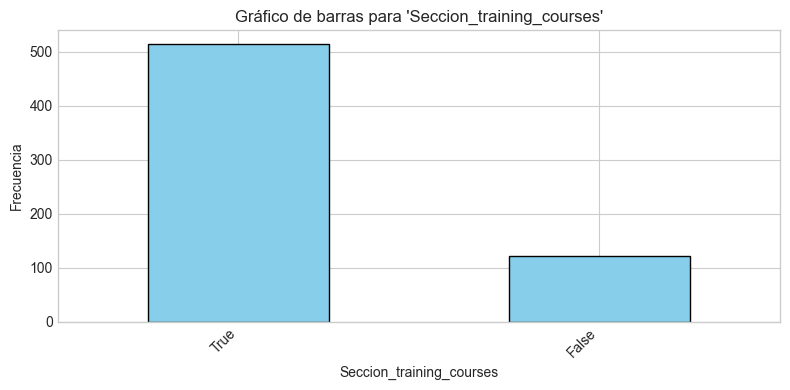

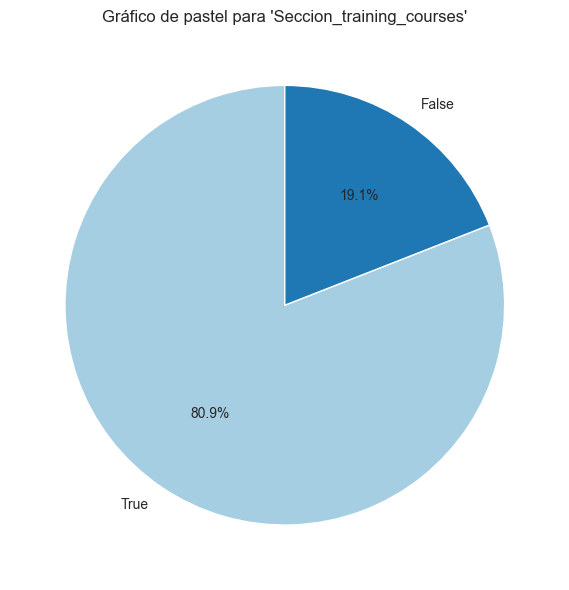

Distribución de valores para 'Seccion_volunteer_work':
Seccion_volunteer_work
False    338
True     297
Name: count, dtype: int64 



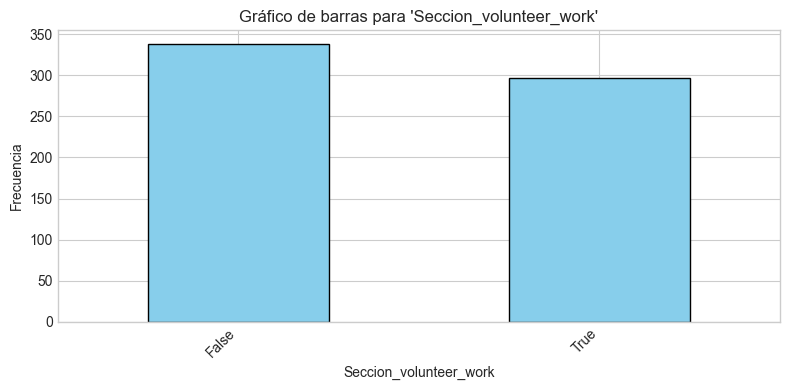

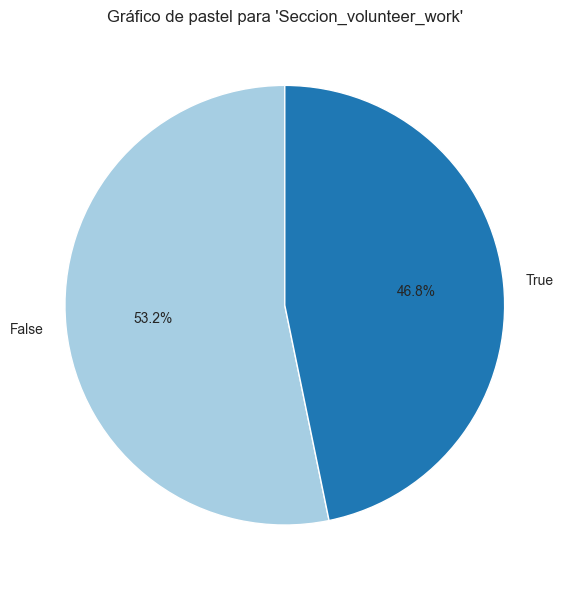

Distribución de valores para 'Tamaños fuente detectados':
Tamaños fuente detectados
[]                         14
[10, 12, 14, 24]           14
[10, 11, 12]               12
[10, 12]                   10
[10, 11, 12, 14]            9
                           ..
[8, 9, 10, 12, 17, 25]      1
[6, 10, 11, 12, 15, 36]     1
[8, 9, 10, 18]              1
[8, 10, 11, 13]             1
[10, 12, 16, 34]            1
Name: count, Length: 472, dtype: int64 



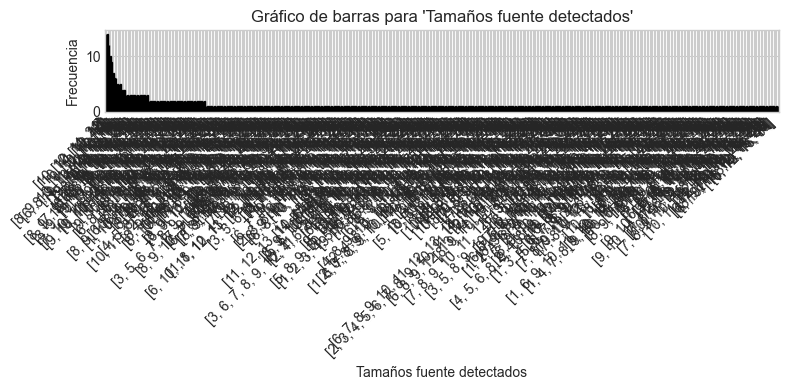

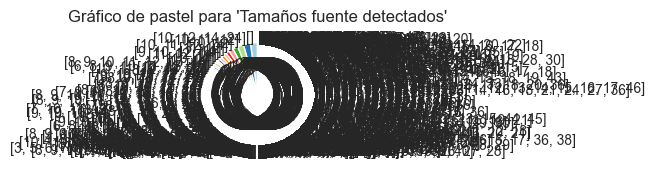

In [5]:
# Seleccionar columnas categóricas
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns

# Iterar sobre cada columna categórica para mostrar conteos y gráficas
for col in categorical_cols:
    print(f"Distribución de valores para '{col}':")
    print(df[col].value_counts(), "\n")

    # Gráfico de barras
    plt.figure(figsize=(8, 4))
    df[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Gráfico de barras para '{col}'")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Gráfico de pastel
    plt.figure(figsize=(6, 6))
    df[col].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title(f"Gráfico de pastel para '{col}'")
    plt.ylabel("")  # Eliminar el texto del eje Y
    plt.tight_layout()
    plt.show()


### Descriptivos variable objetivo

Tabla cruzada entre 'Passed' y 'Categoria Original':
Passed                0    1
Categoria Original          
Exitoso               0  268
No Exitoso          367    0 



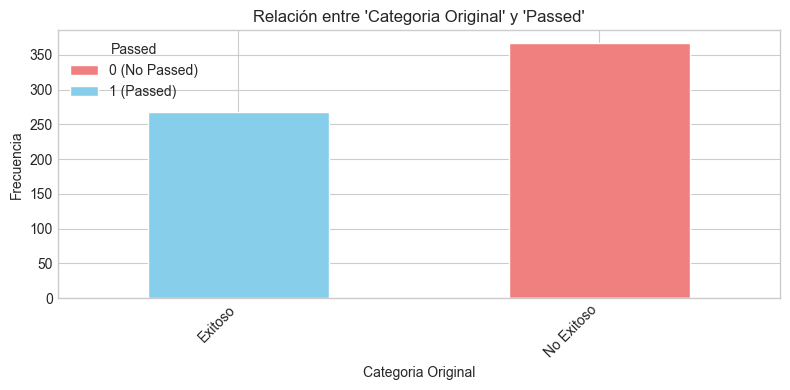

Tabla cruzada entre 'Passed' y 'status_procesamiento':
Passed                              0    1
status_procesamiento                      
Advertencia: No se extrajo texto    5    4
Completado                        362  264 



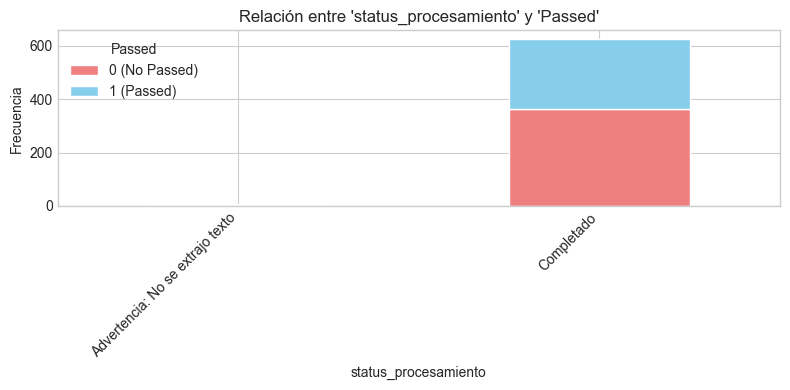

Tabla cruzada entre 'Passed' y 'Formato Texto (Lineas)':
Passed                    0    1
Formato Texto (Lineas)          
Indeterminado             5    4
Mixto                    73   60
Párrafos                 10   10
Viñetas                 279  194 



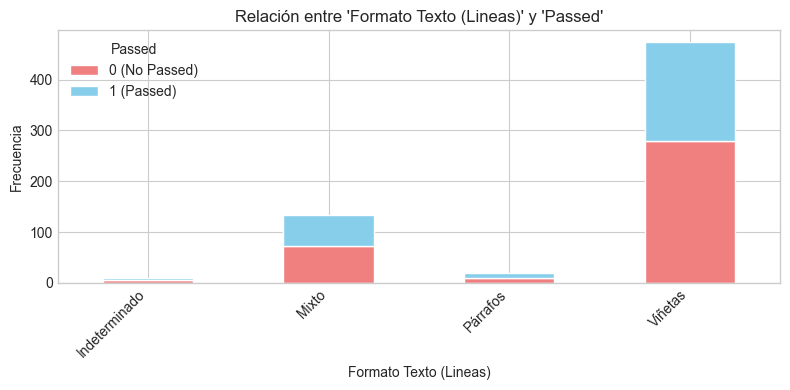

Tabla cruzada entre 'Passed' y 'Orden Temporal':
Passed                      0    1
Orden Temporal                    
Orden Temporal Detectado  112   84
Pocas Fechas              255  184 



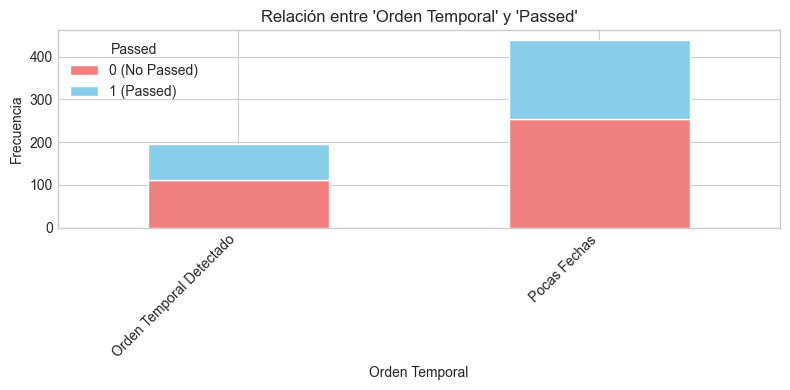

Tabla cruzada entre 'Passed' y 'Formato Fecha Más Común':
Passed                         0    1
Formato Fecha Más Común              
DD/MM/YYYY                     7    5
MM-YYYY                        1    4
MM/YYYY                       27   32
Mes YYYY (ES Comp)             7    6
Mon YYYY (EN)                 64   40
Month YYYY (EN)               43   29
Rango YYYY-YYYY                4    7
SpaCy DATE (Sin clasificar)   59   32
YYYY                         142  109
YYYY (SpaCy)                   1    0 



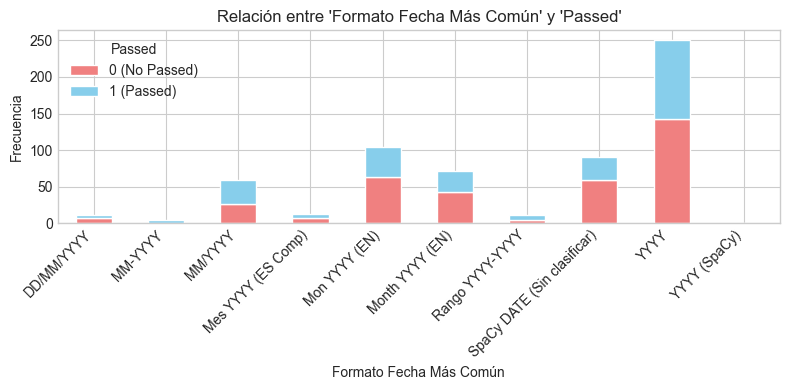

Tabla cruzada entre 'Passed' y 'Fuente principal':
Passed                    0  1
Fuente principal              
AdelleSansDevanagari-Reg  0  1
Aileron-Regular           0  1
Aleo-Regular              1  0
Amiko-Regular             1  0
Amiko-SemiBold            0  1
...                      .. ..
Ubuntu-Regular            2  6
Unnamed-T3                3  8
Verdana                   8  5
___WRD_EMBED_SUB_43       0  1
___WRD_EMBED_SUB_44       1  0

[158 rows x 2 columns] 



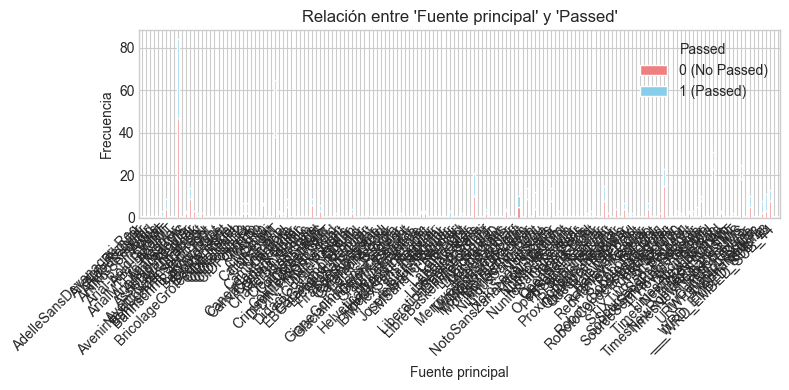

Tabla cruzada entre 'Passed' y 'Legibilidad general':
Passed                       0    1
Legibilidad general                
Buena                      257  174
Potencialmente Deficiente  102   88
Vacío                        8    6 



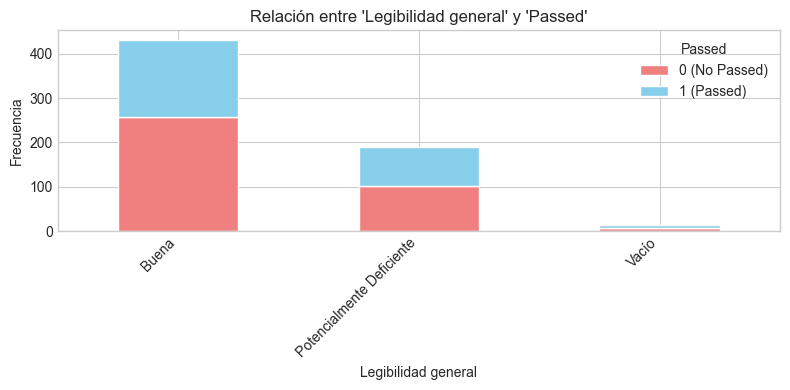

Tabla cruzada entre 'Passed' y 'Consistencia tamaños fuente':
Passed                         0    1
Consistencia tamaños fuente          
Consistente                  217  155
Inconsistente                142  107 



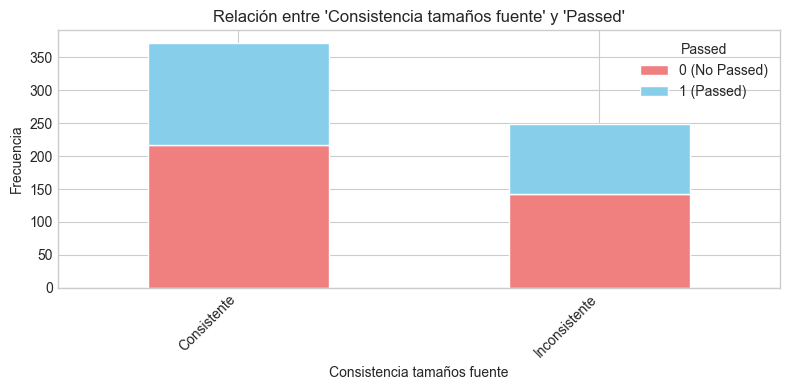

Tabla cruzada entre 'Passed' y 'Consistencia márgenes (aprox)':
Passed                           0    1
Consistencia márgenes (aprox)          
Consistente                    296  212
Inconsistente                   63   50 



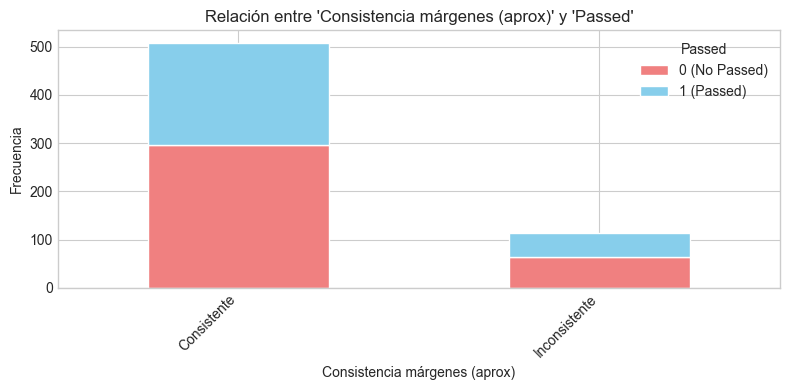

Tabla cruzada entre 'Passed' y 'Uso de colores (texto)':
Passed                    0    1
Uso de colores (texto)          
No                      120   71
Sí                      247  197 



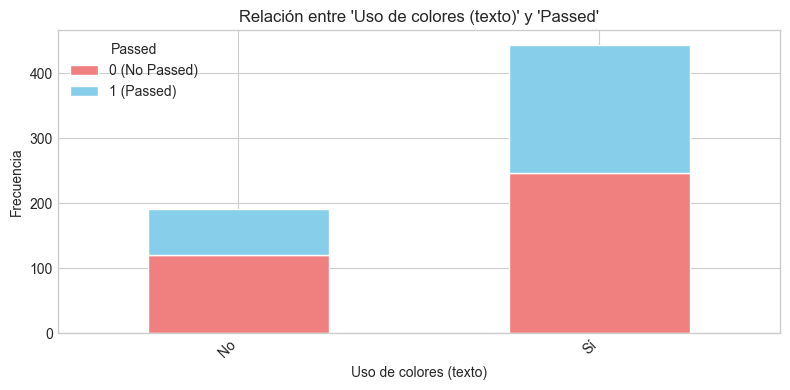

Tabla cruzada entre 'Passed' y 'Uso de colores (dibujos)':
Passed                      0    1
Uso de colores (dibujos)          
No                        135   99
Sí                        232  169 



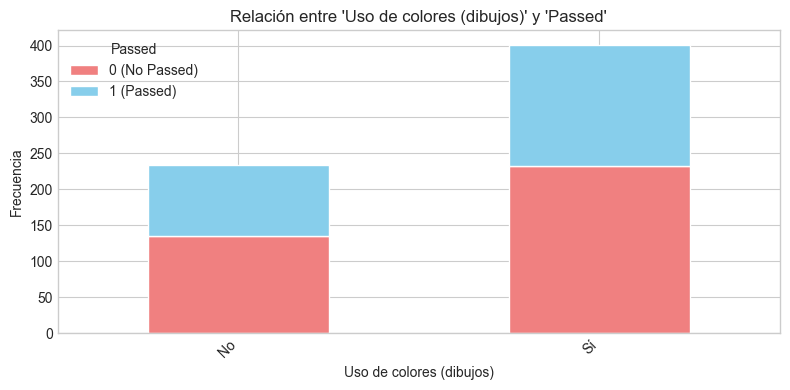

Tabla cruzada entre 'Passed' y 'LinkedIn':
Passed      0    1
LinkedIn          
False     252  185
True      115   83 



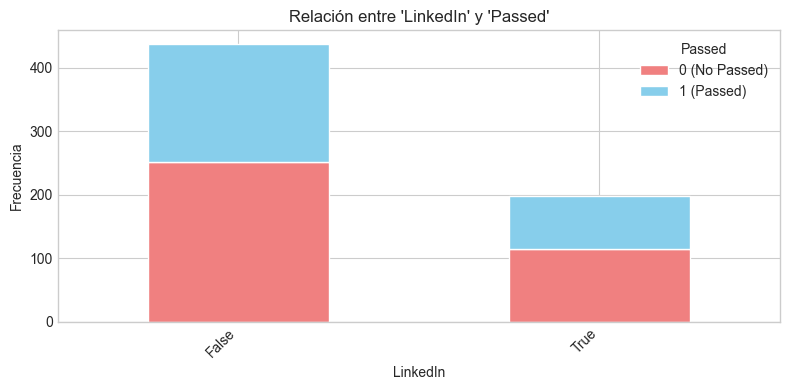

Tabla cruzada entre 'Passed' y 'GitHub':
Passed    0    1
GitHub          
False   327  237
True     40   31 



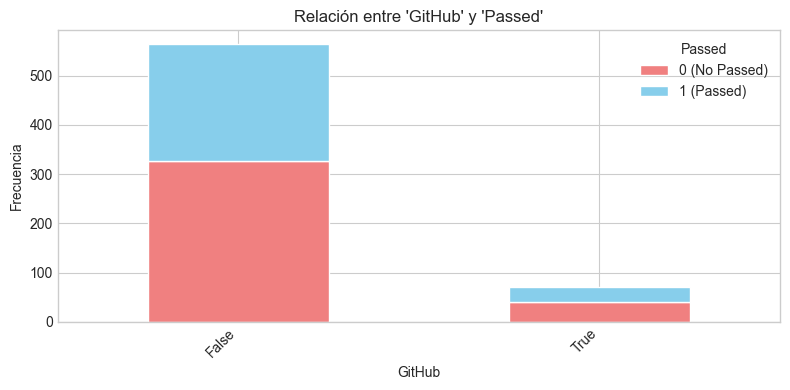

Tabla cruzada entre 'Passed' y 'Website/Otro':
Passed          0    1
Website/Otro          
False         311  206
True           56   62 



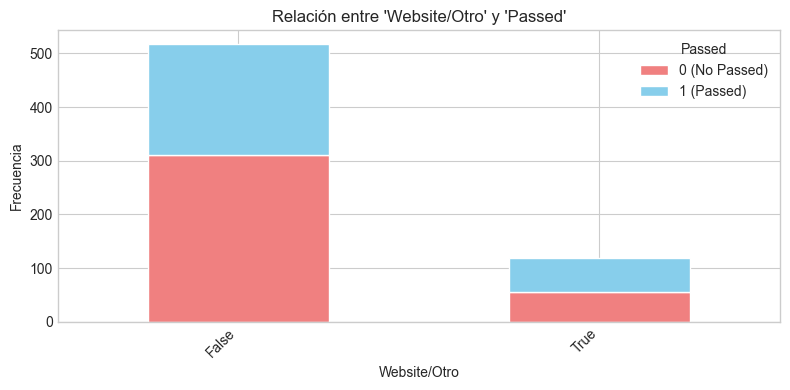

Tabla cruzada entre 'Passed' y 'Deteccion Foto Perfil':
Passed                                  0    1
Deteccion Foto Perfil                         
No se detectaron imágenes candidatas  243  191
Posible Foto Detectada                124   77 



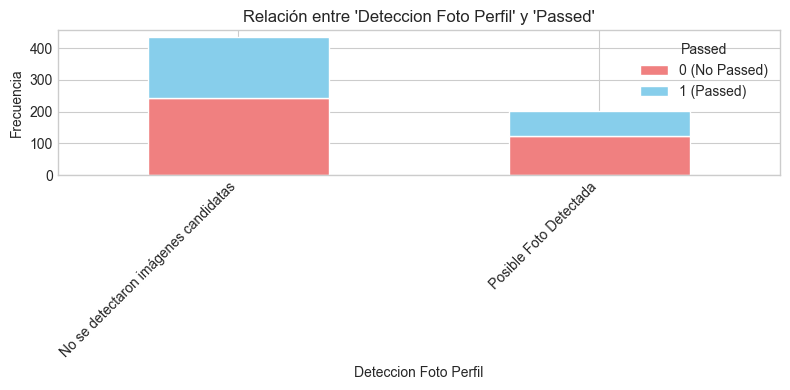

Tabla cruzada entre 'Passed' y 'Tiene Elementos Graficos':
Passed                      0    1
Tiene Elementos Graficos          
False                     160  115
True                      207  153 



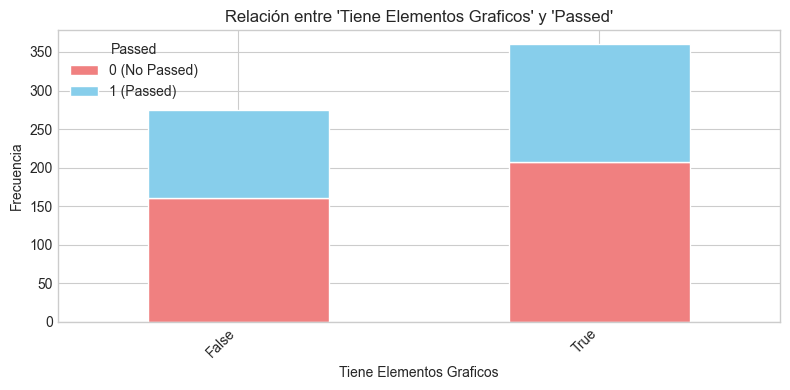

Tabla cruzada entre 'Passed' y 'Seccion_education':
Passed               0    1
Seccion_education          
False               13    7
True               354  261 



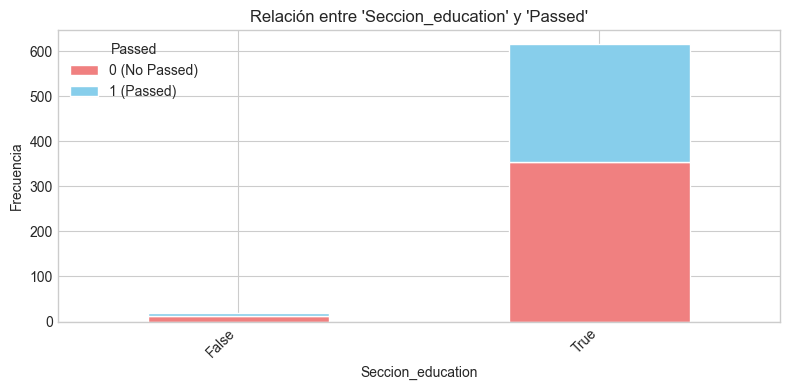

Tabla cruzada entre 'Passed' y 'Seccion_work_experience':
Passed                     0    1
Seccion_work_experience          
False                     11    7
True                     356  261 



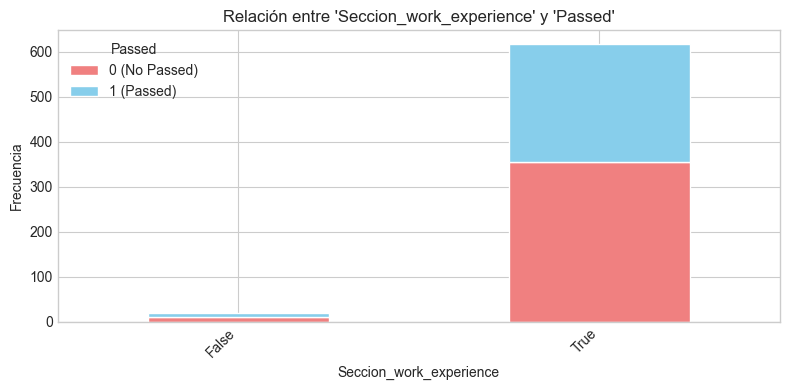

Tabla cruzada entre 'Passed' y 'Seccion_skills':
Passed            0    1
Seccion_skills          
False            33   16
True            334  252 



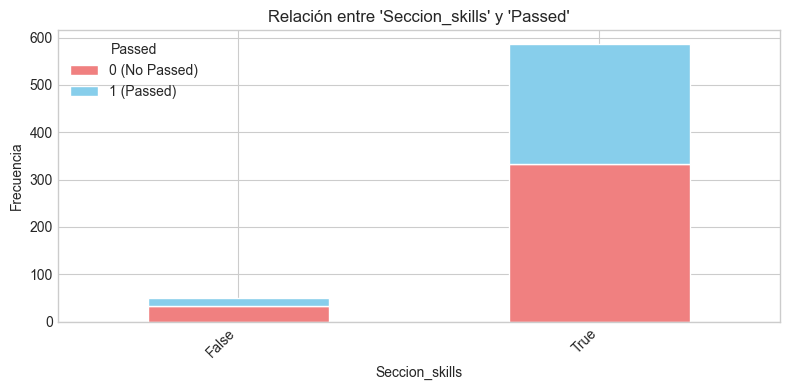

Tabla cruzada entre 'Passed' y 'Seccion_certifications':
Passed                    0    1
Seccion_certifications          
False                    48   28
True                    319  240 



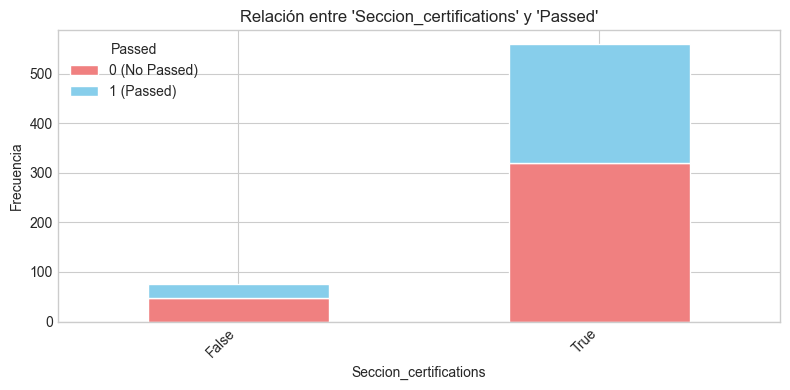

Tabla cruzada entre 'Passed' y 'Seccion_achievements':
Passed                  0    1
Seccion_achievements          
False                 243  170
True                  124   98 



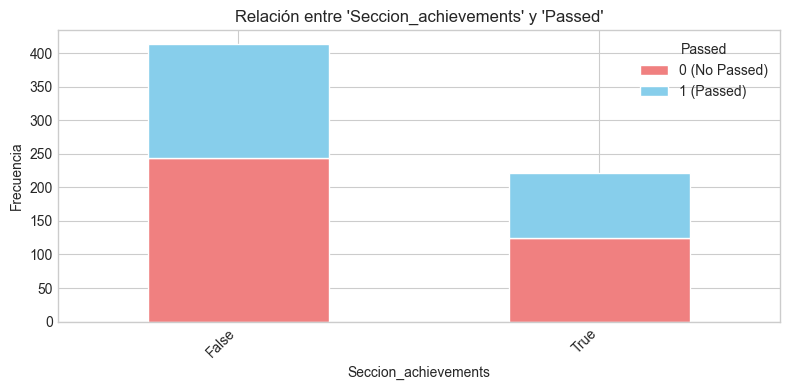

Tabla cruzada entre 'Passed' y 'Seccion_professional_profile':
Passed                          0    1
Seccion_professional_profile          
False                          30   18
True                          337  250 



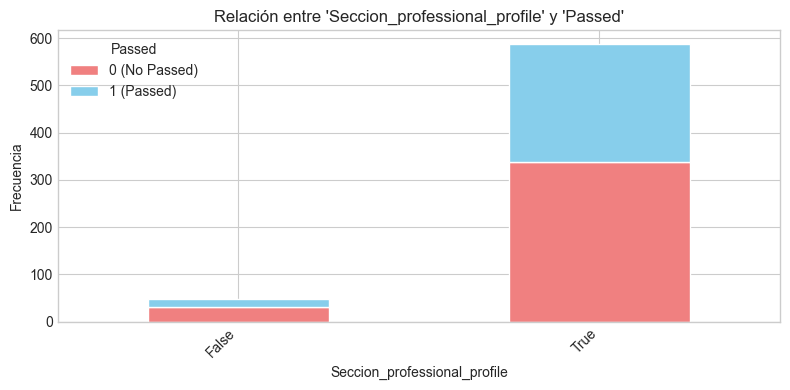

Tabla cruzada entre 'Passed' y 'Seccion_languages':
Passed               0    1
Seccion_languages          
False               48   23
True               319  245 



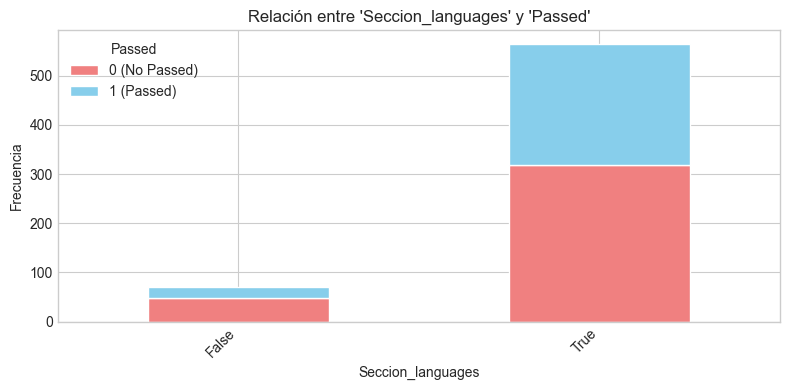

Tabla cruzada entre 'Passed' y 'Seccion_projects':
Passed              0    1
Seccion_projects          
False              48   25
True              319  243 



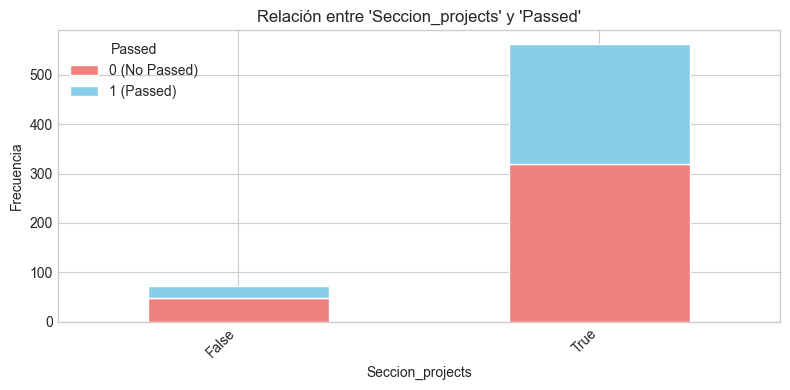

Tabla cruzada entre 'Passed' y 'Seccion_publications':
Passed                  0    1
Seccion_publications          
False                  12    4
True                  355  264 



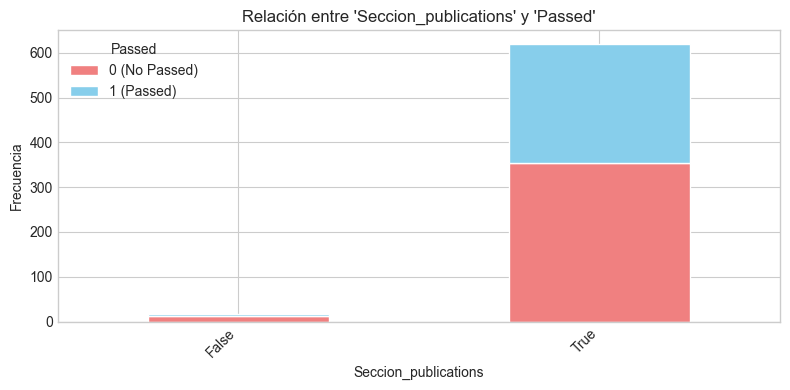

Tabla cruzada entre 'Passed' y 'Seccion_training_courses':
Passed                      0    1
Seccion_training_courses          
False                      80   41
True                      287  227 



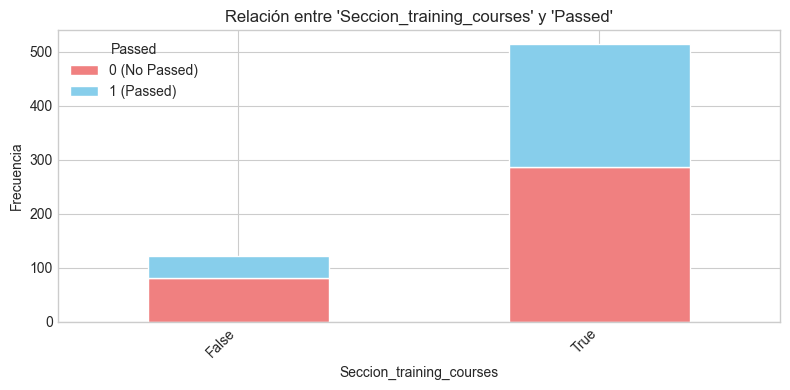

Tabla cruzada entre 'Passed' y 'Seccion_volunteer_work':
Passed                    0    1
Seccion_volunteer_work          
False                   201  137
True                    166  131 



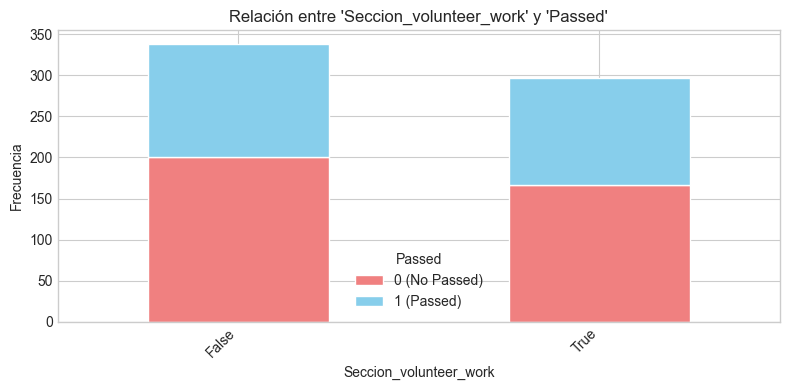

Tabla cruzada entre 'Passed' y 'Tamaños fuente detectados':
Passed                              0  1
Tamaños fuente detectados               
[0, 1, 5, 9, 10, 12, 36]            1  0
[0, 11, 12, 13, 14, 18]             1  0
[0, 5, 6, 7, 8, 9, 10, 11, 13, 16]  0  1
[0, 6, 8, 9, 10, 20]                1  0
[0, 9, 11, 14, 22]                  1  0
...                                .. ..
[9, 12, 24]                         1  0
[9, 12, 26]                         1  0
[9, 13, 32]                         0  1
[9]                                 0  1
[]                                  8  6

[472 rows x 2 columns] 



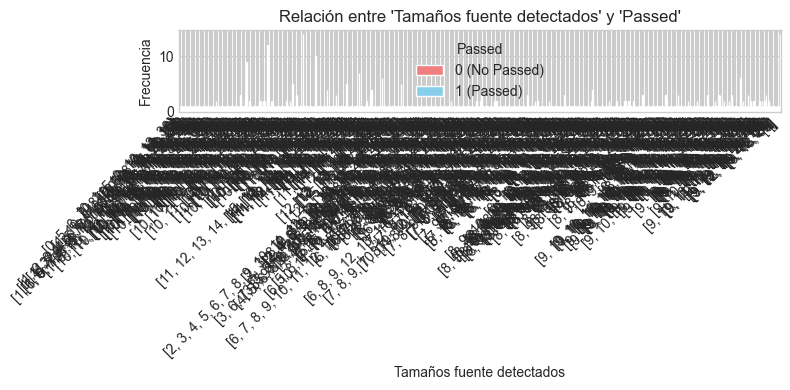

In [6]:
# Seleccionar columnas categóricas
categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns

# Imprimir tablas cruzadas y gráficos de barras para cada variable categórica con 'Passed'
for col in categorical_cols:
    print(f"Tabla cruzada entre 'Passed' y '{col}':")
    crosstab = pd.crosstab(df[col], df['Passed'])
    print(crosstab, "\n")

    # Gráfico de barras agrupadas
    crosstab.plot(kind='bar', stacked=True, figsize=(8, 4), color=['lightcoral', 'skyblue'])
    plt.title(f"Relación entre '{col}' y 'Passed'")
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Passed', labels=['0 (No Passed)', '1 (Passed)'])
    plt.tight_layout()
    plt.show()


### Identificar variables con baja varianza

In [7]:
threshold = 0.01

# Seleccionar solo variables numéricas
numerical_cols = df.select_dtypes(include=['number'])

# Usar VarianceThreshold para identificar columnas con baja varianza
selector = VarianceThreshold(threshold=threshold)
selector.fit(numerical_cols)

# Obtener las columnas con baja varianza
low_variance_cols = numerical_cols.columns[~selector.get_support()]

# Imprimir el resultado
print("Columnas con baja varianza (<= 0.01):")
for col in low_variance_cols:
    print(f"- {col}: Varianza = {numerical_cols[col].var():.6f}")

Columnas con baja varianza (<= 0.01):


### Detectar outliers

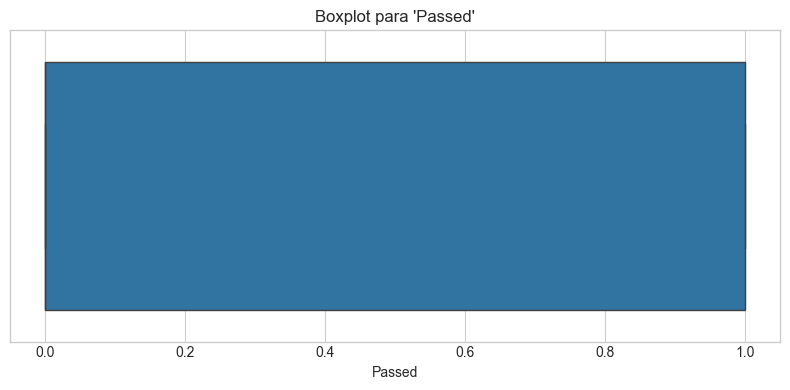

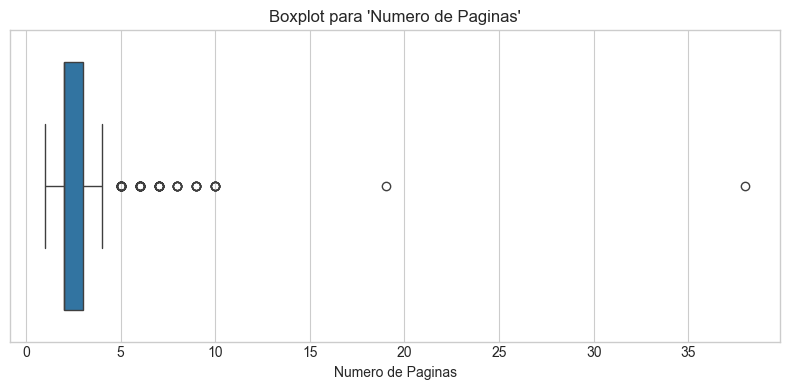

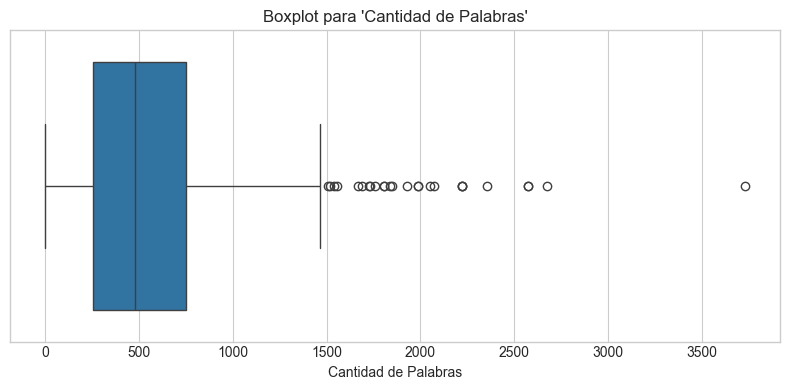

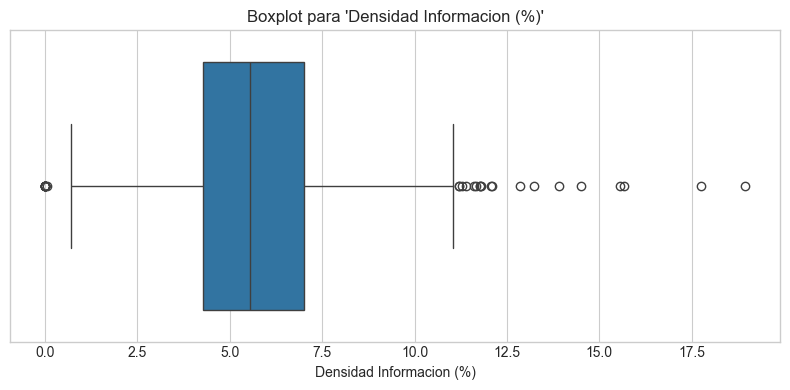

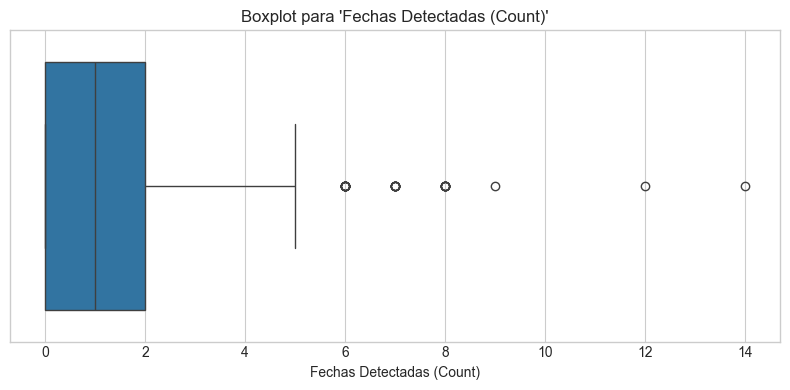

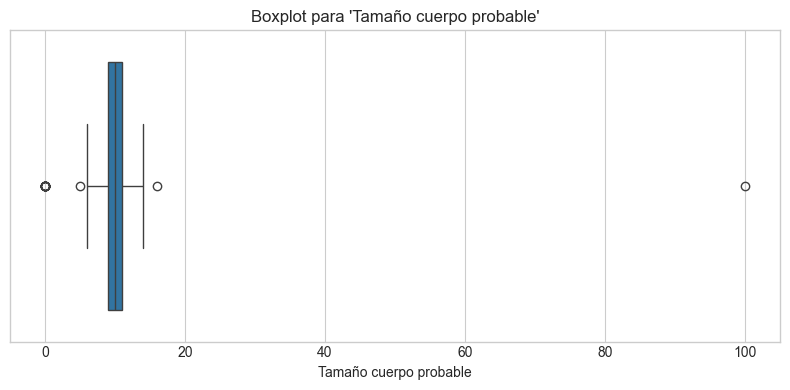

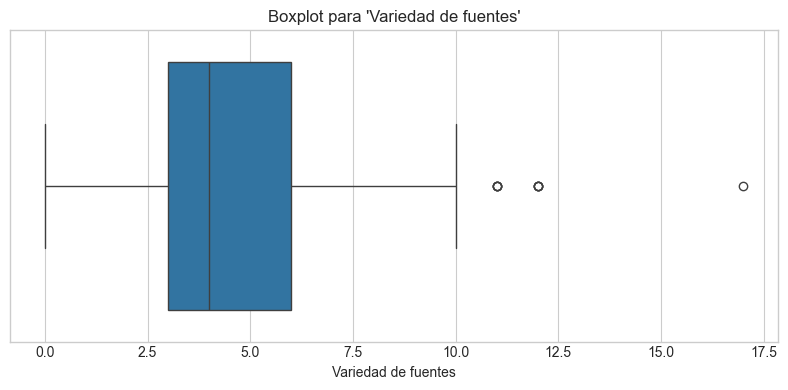

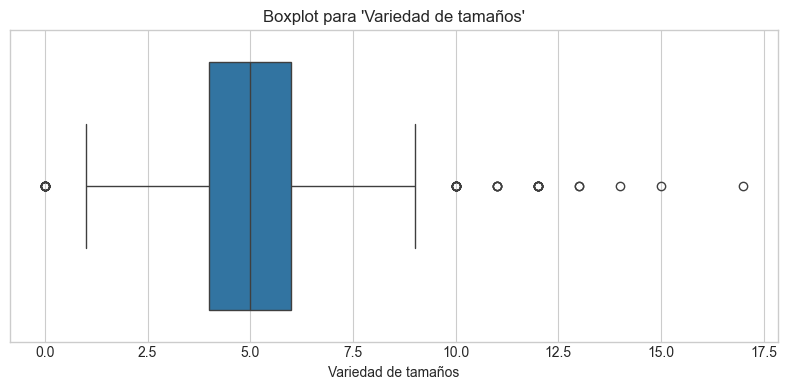

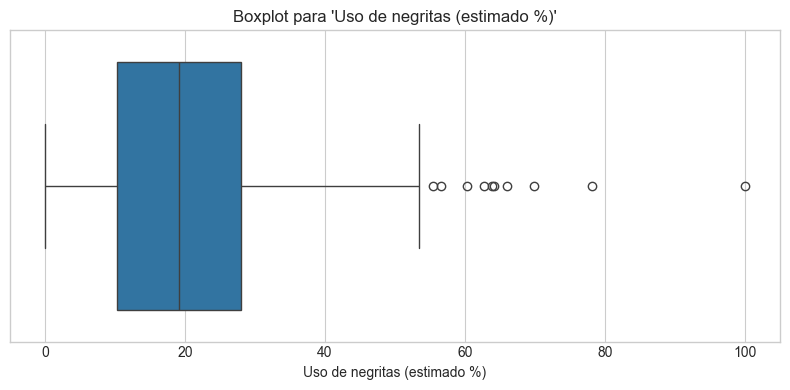

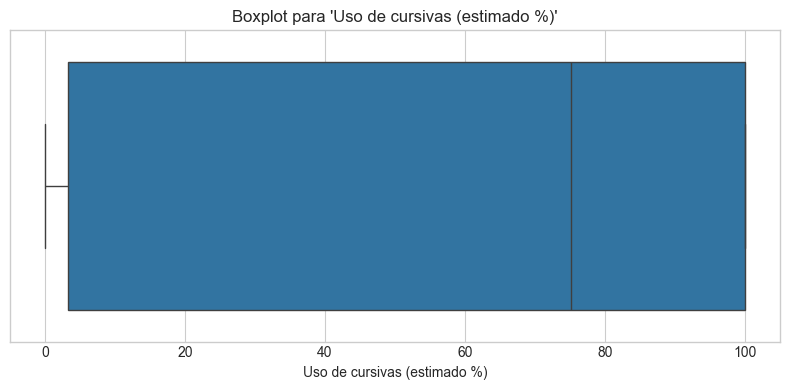

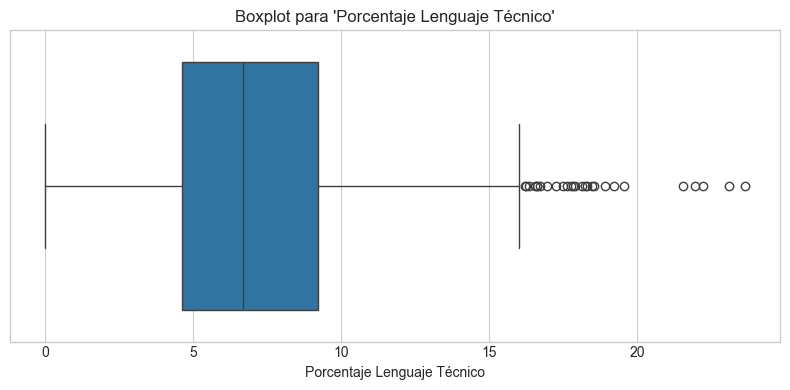

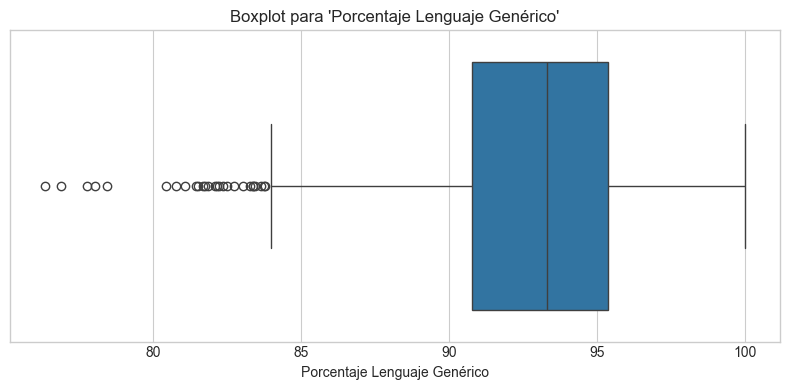

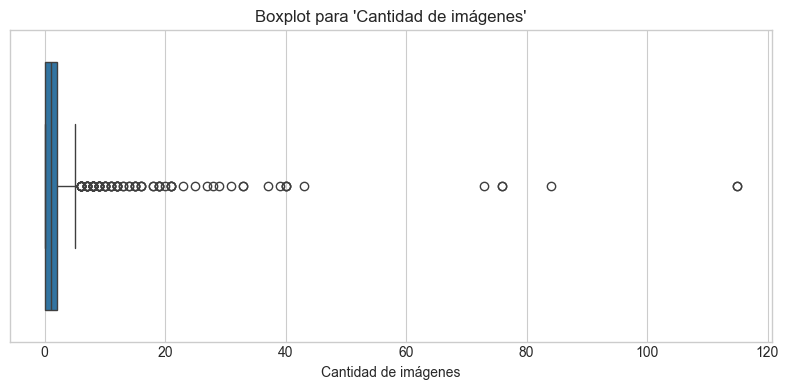

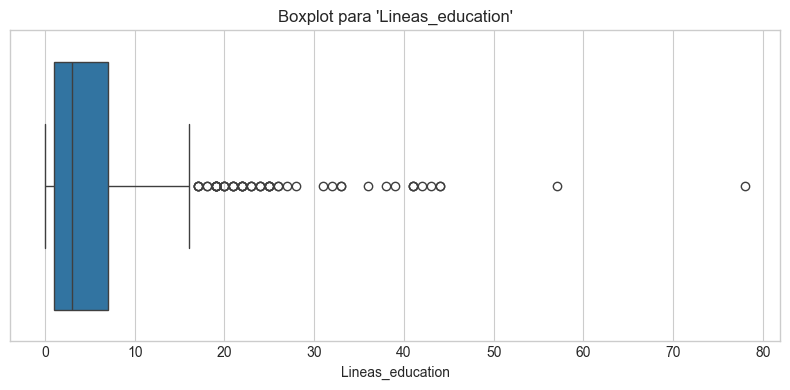

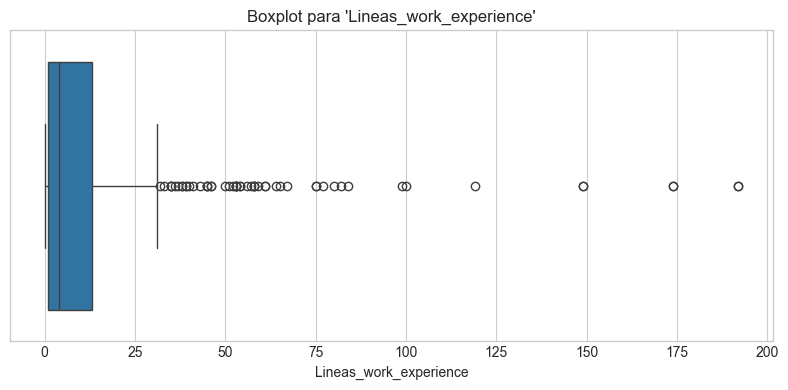

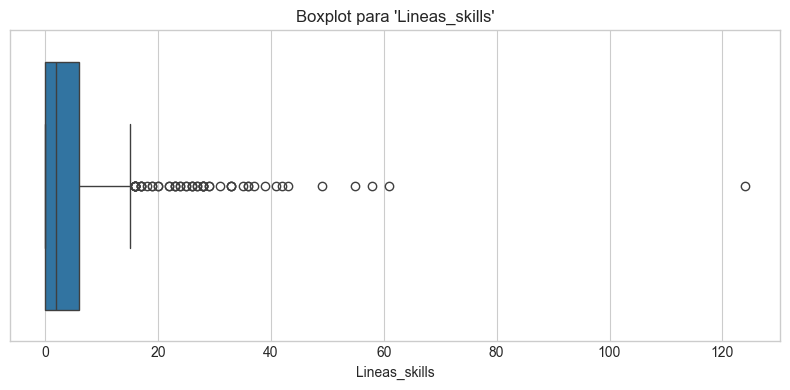

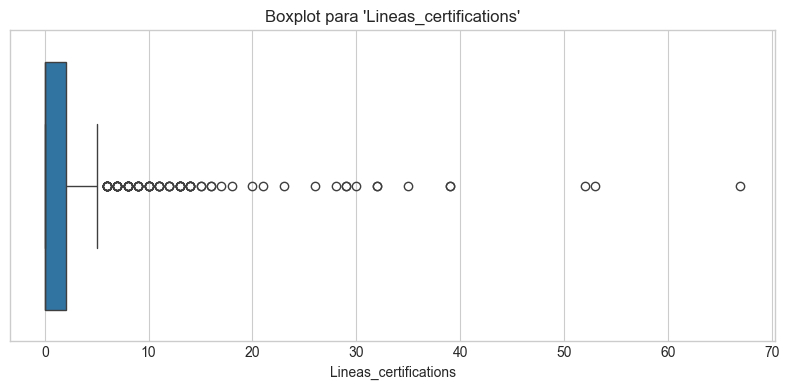

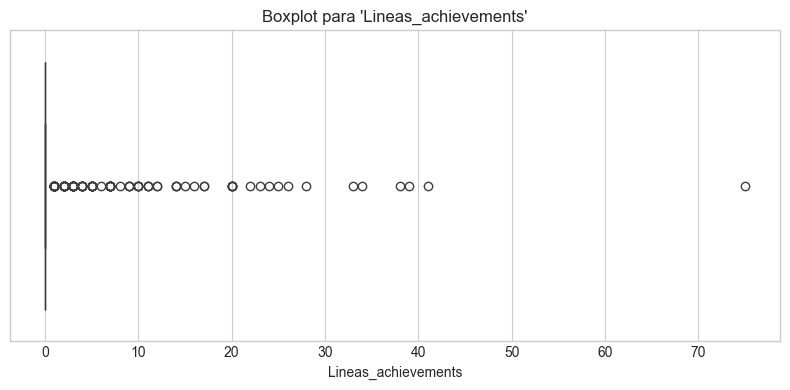

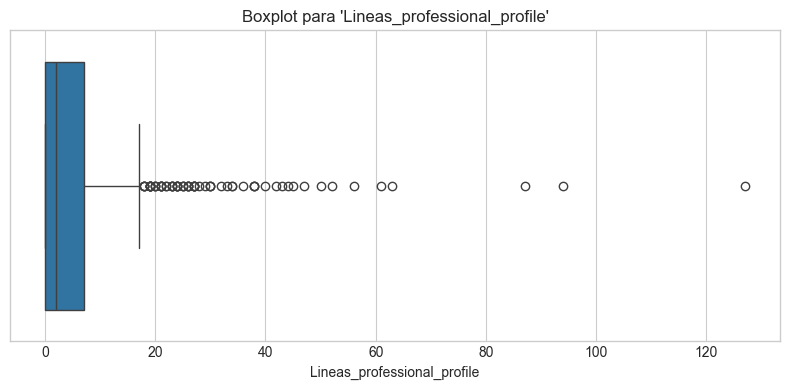

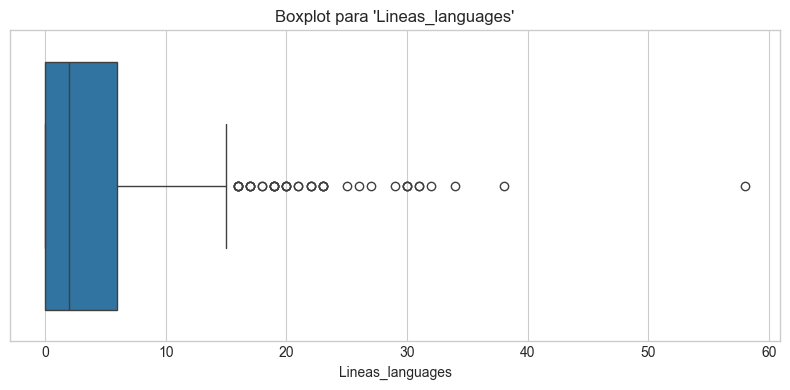

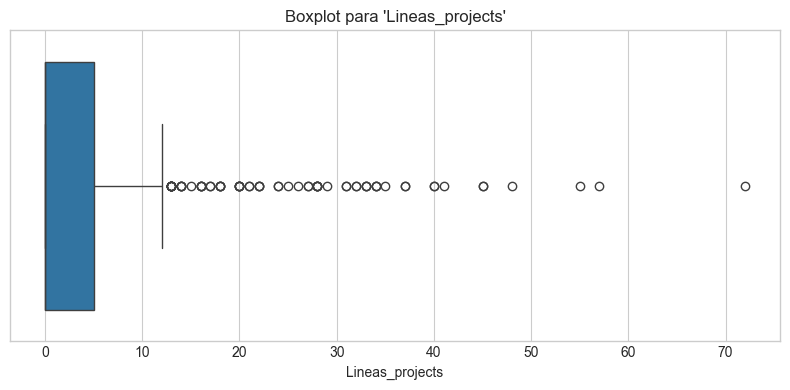

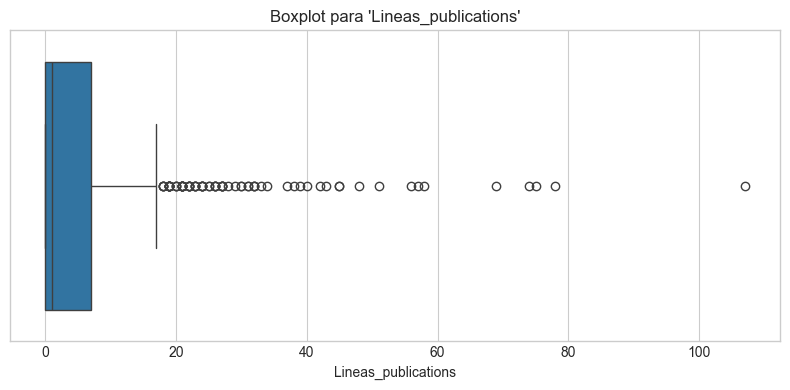

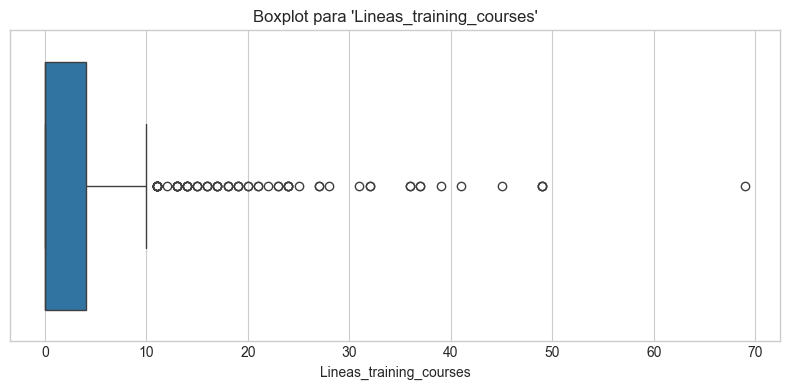

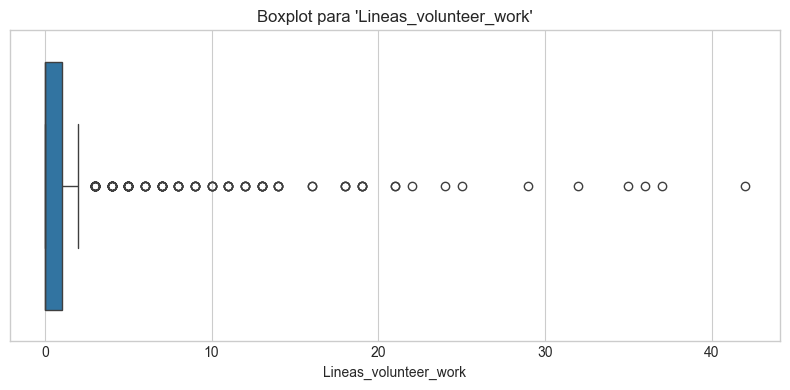

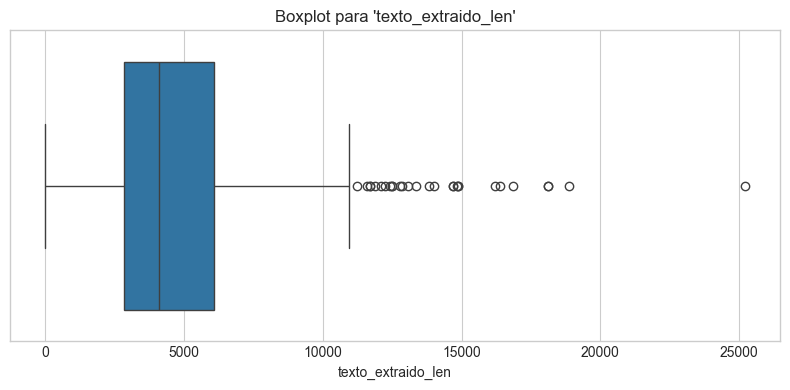

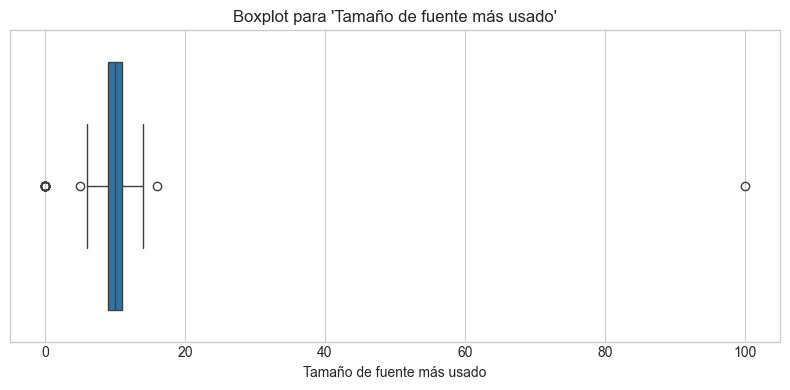

In [8]:
numerical_cols = df.select_dtypes(include=['number']).columns

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot para '{col}'")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

### Outliers con z-score

In [9]:
# Calcular el Z-score para todas las variables numéricas
z_scores = df[numerical_cols].apply(zscore)

# Umbral para definir valores atípicos (e.g., Z > 3 o Z < -3)
threshold = 3

# Identificar outliers en cada columna
outliers_zscore = (z_scores > threshold) | (z_scores < -threshold)

# Mostrar las variables y el número de outliers detectados
print("Número de outliers detectados por Z-score en cada variable:")
print(outliers_zscore.sum())

Número de outliers detectados por Z-score en cada variable:
Passed                           0
Numero de Paginas                8
Cantidad de Palabras            13
Densidad Informacion (%)         6
Fechas Detectadas (Count)       11
Tamaño cuerpo probable           1
Variedad de fuentes              5
Variedad de tamaños              5
Uso de negritas (estimado %)     8
Uso de cursivas (estimado %)     0
Porcentaje Lenguaje Técnico      6
Porcentaje Lenguaje Genérico     6
Cantidad de imágenes            12
Lineas_education                15
Lineas_work_experience          12
Lineas_skills                   13
Lineas_certifications           14
Lineas_achievements             17
Lineas_professional_profile     13
Lineas_languages                13
Lineas_projects                 20
Lineas_publications             14
Lineas_training_courses         15
Lineas_volunteer_work           18
texto_extraido_len              14
Tamaño de fuente más usado       1
dtype: int64


### Outliers con rango intercuartilico

In [10]:
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)  # Primer cuartil (Q1)
    Q3 = data[col].quantile(0.75)  # Tercer cuartil (Q3)
    IQR = Q3 - Q1  # Rango intercuartílico (IQR)
    lower_bound = Q1 - 1.5 * IQR  # Límite inferior
    upper_bound = Q3 + 1.5 * IQR  # Límite superior
    return data[(data[col] < lower_bound) | (data[col] > upper_bound)]


# Detectar y contar outliers en todas las columnas numéricas
for col in numerical_cols:
    outliers = detect_outliers_iqr(df, col)
    print(f"Outliers detectados en '{col}': {len(outliers)}")

Outliers detectados en 'Passed': 0
Outliers detectados en 'Numero de Paginas': 83
Outliers detectados en 'Cantidad de Palabras': 26
Outliers detectados en 'Densidad Informacion (%)': 29
Outliers detectados en 'Fechas Detectadas (Count)': 31
Outliers detectados en 'Tamaño cuerpo probable': 17
Outliers detectados en 'Variedad de fuentes': 9
Outliers detectados en 'Variedad de tamaños': 42
Outliers detectados en 'Uso de negritas (estimado %)': 10
Outliers detectados en 'Uso de cursivas (estimado %)': 0
Outliers detectados en 'Porcentaje Lenguaje Técnico': 27
Outliers detectados en 'Porcentaje Lenguaje Genérico': 27
Outliers detectados en 'Cantidad de imágenes': 94
Outliers detectados en 'Lineas_education': 57
Outliers detectados en 'Lineas_work_experience': 54
Outliers detectados en 'Lineas_skills': 55
Outliers detectados en 'Lineas_certifications': 90
Outliers detectados en 'Lineas_achievements': 126
Outliers detectados en 'Lineas_professional_profile': 69
Outliers detectados en 'Lineas_

### Visualizar distribuciones

### Comparacion de distribuciones por clase de la variable objetivo

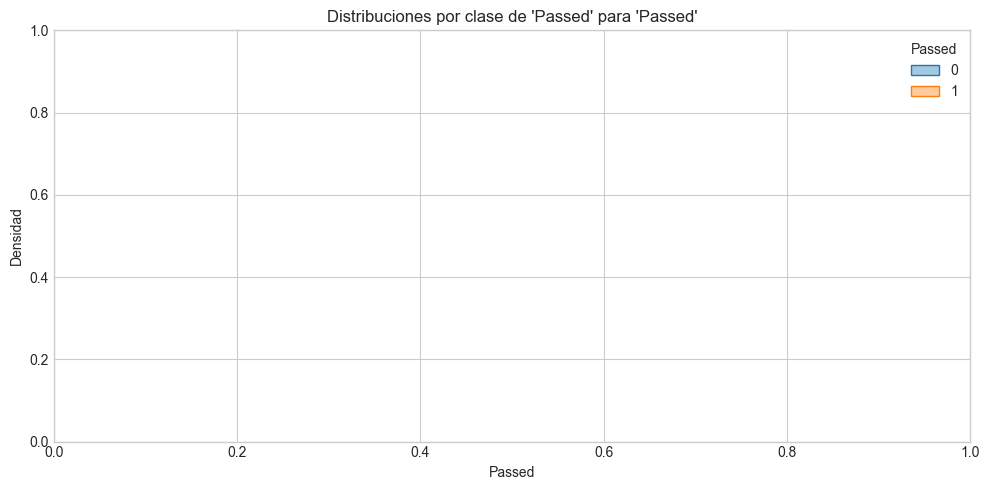

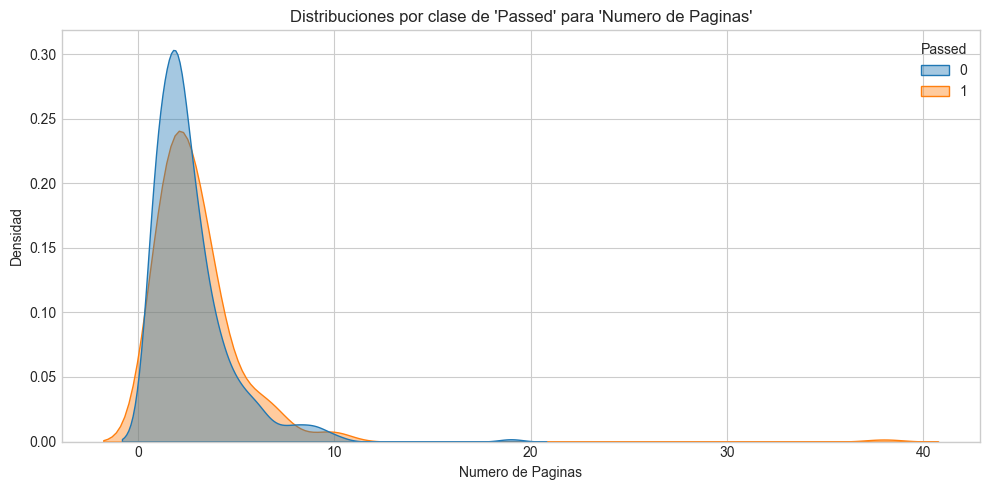

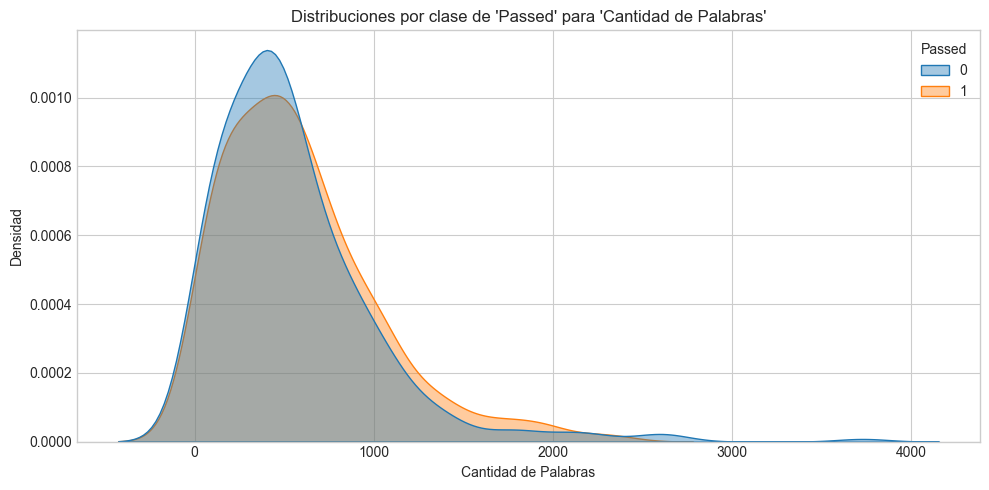

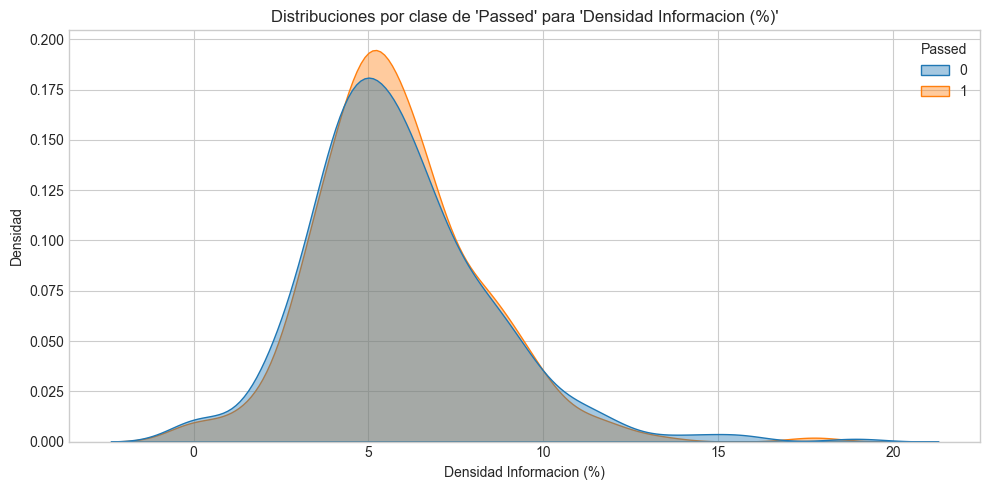

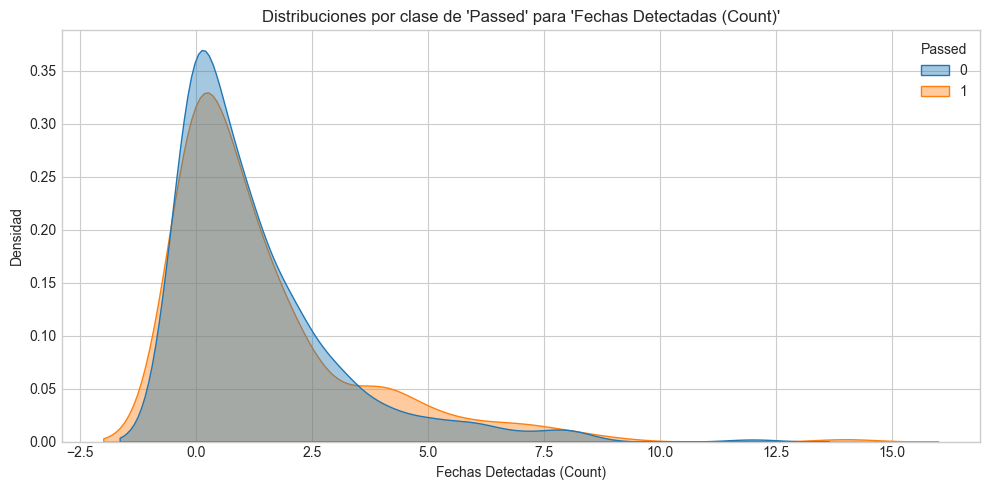

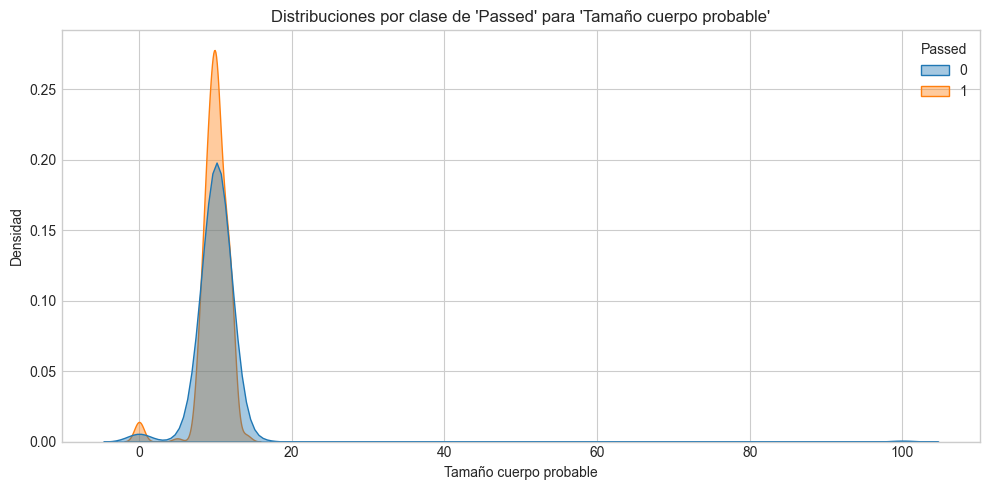

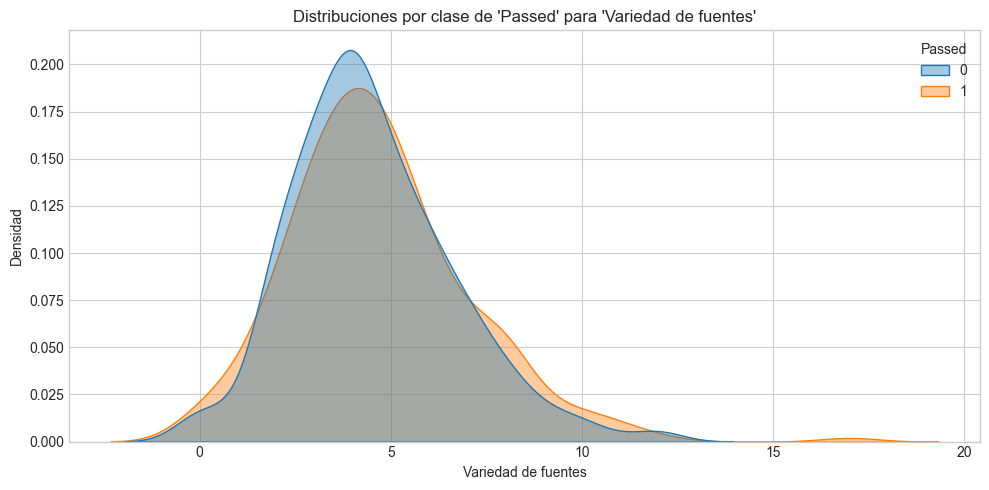

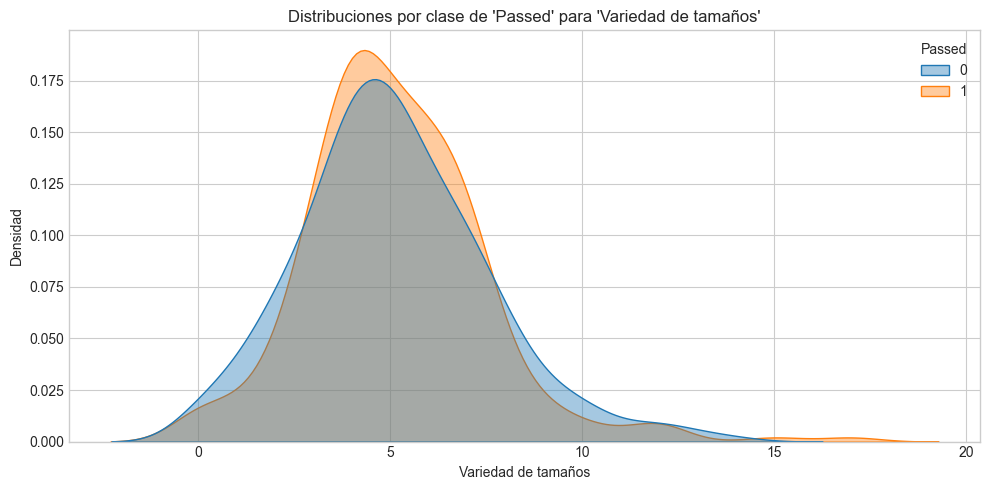

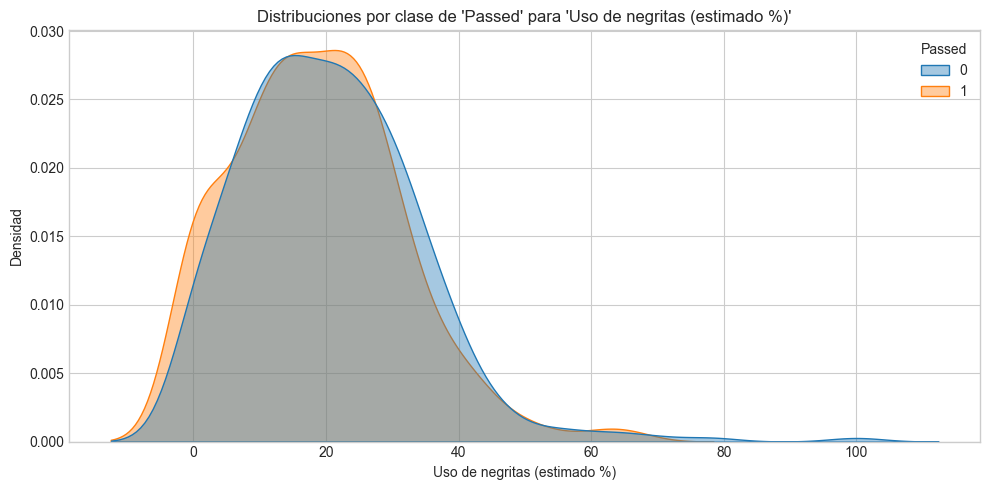

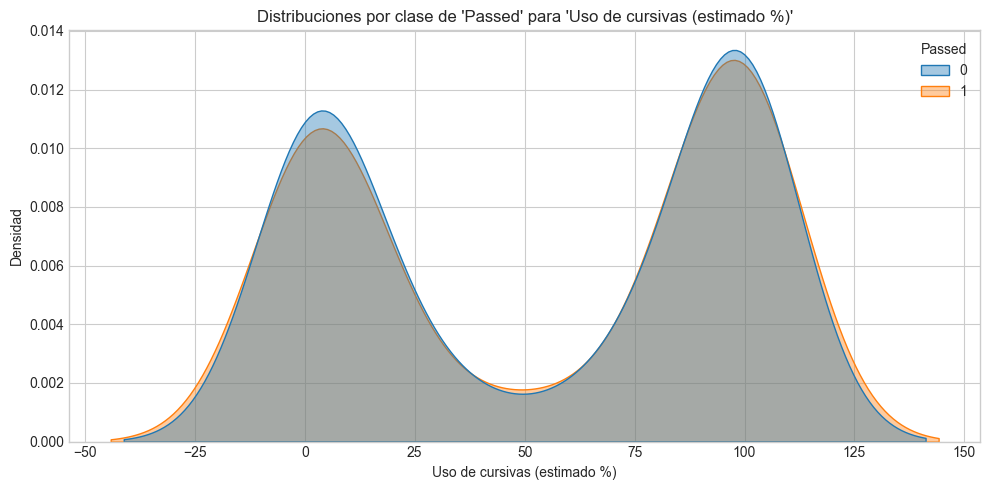

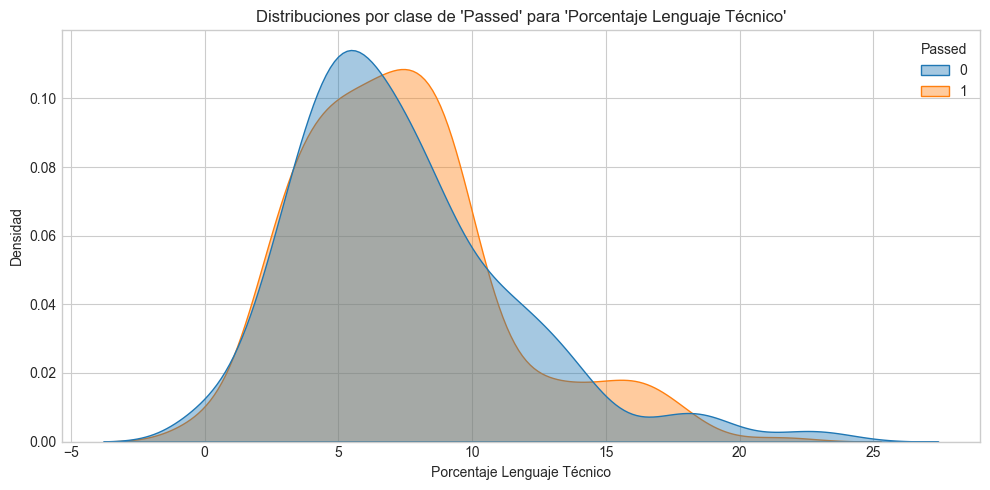

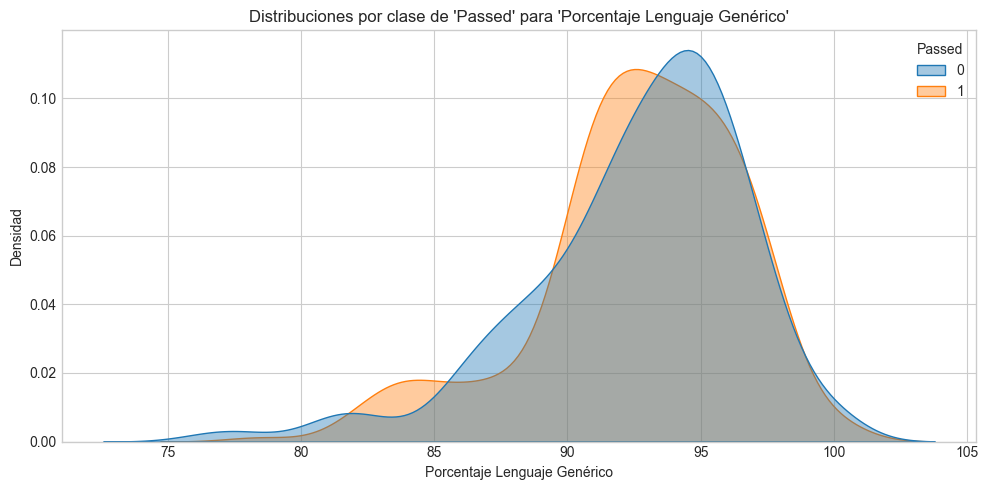

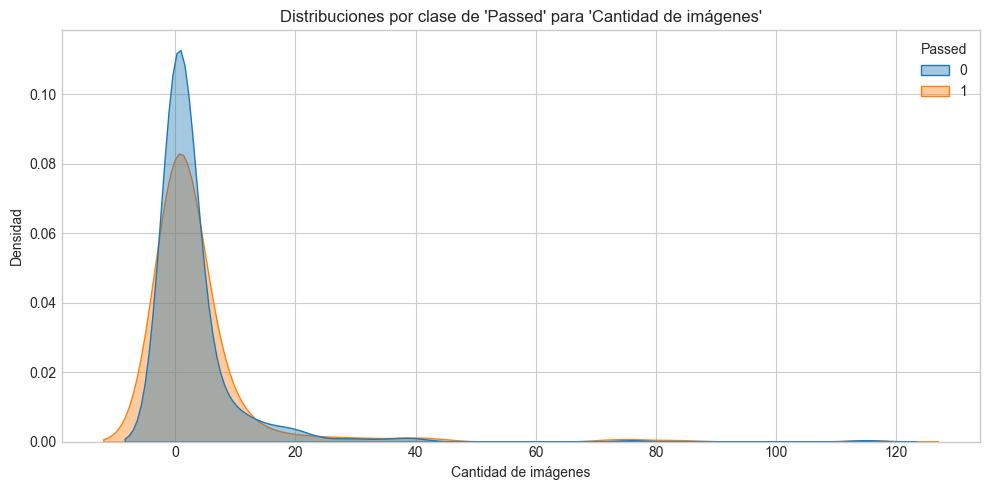

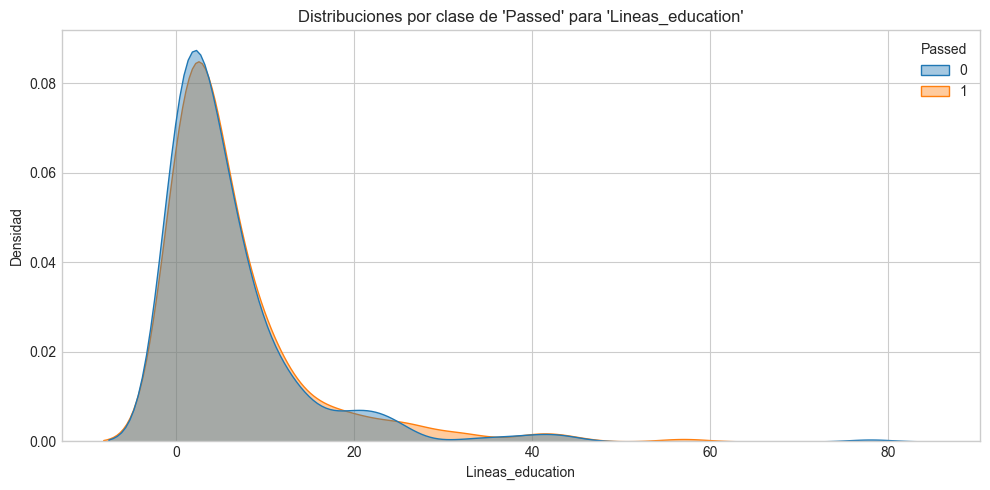

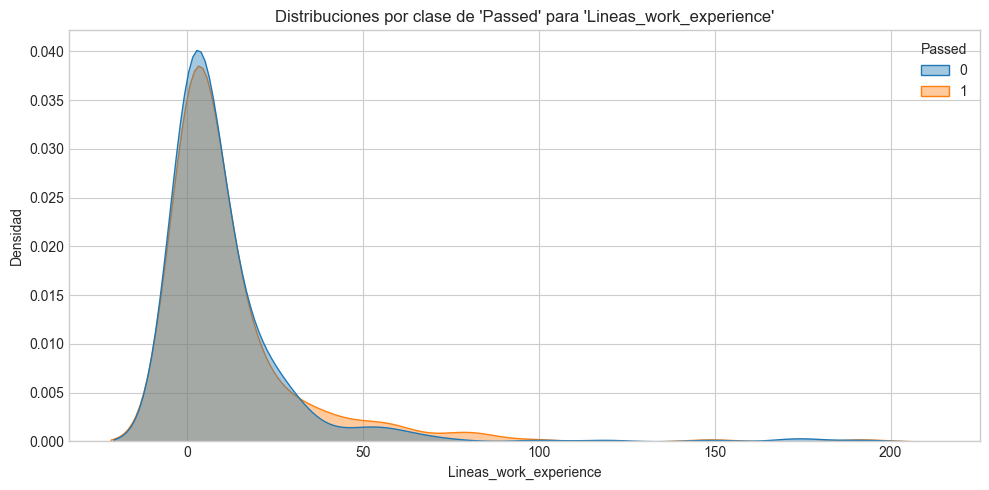

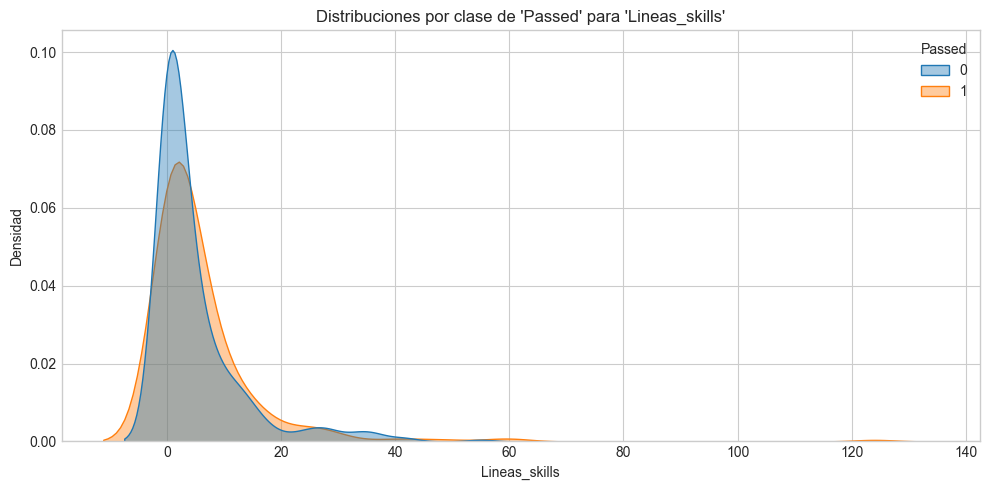

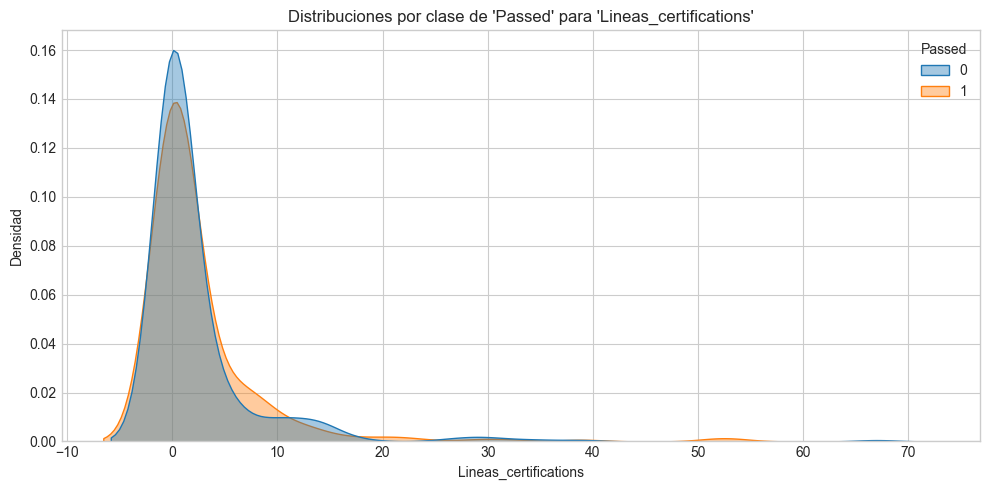

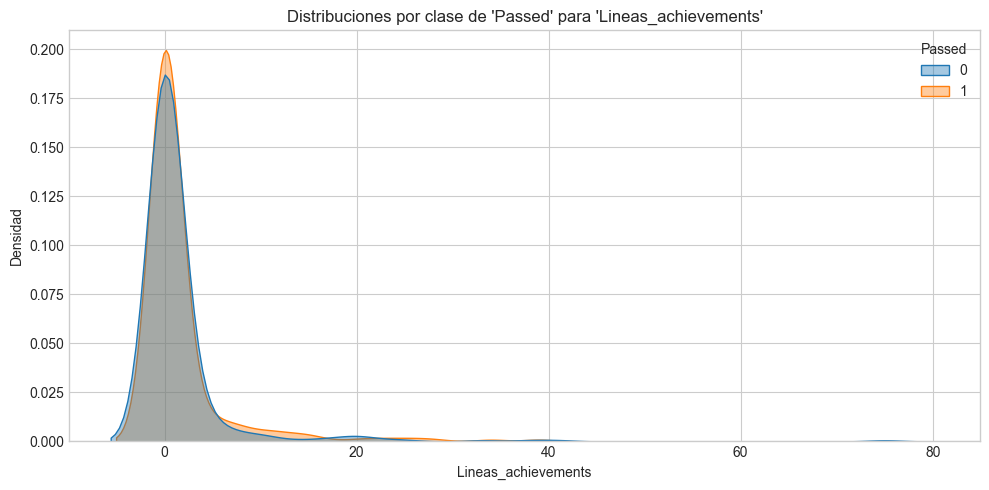

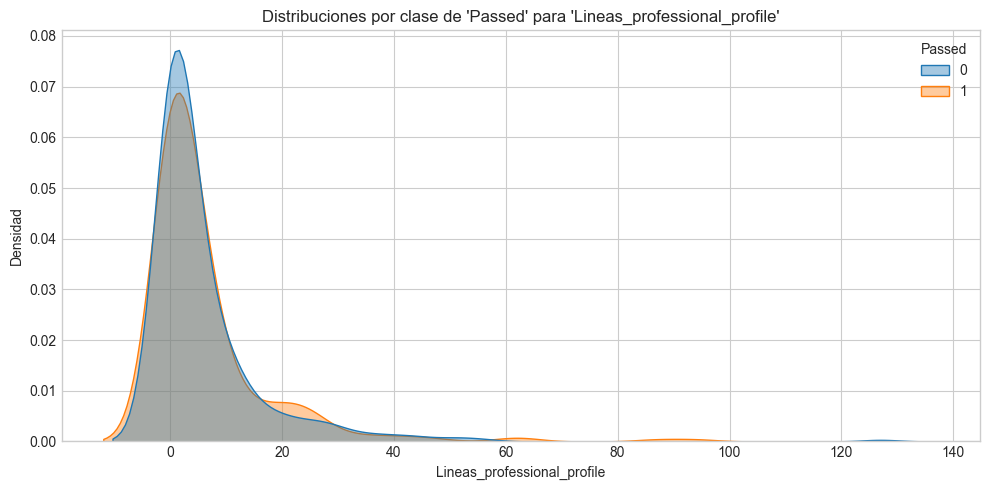

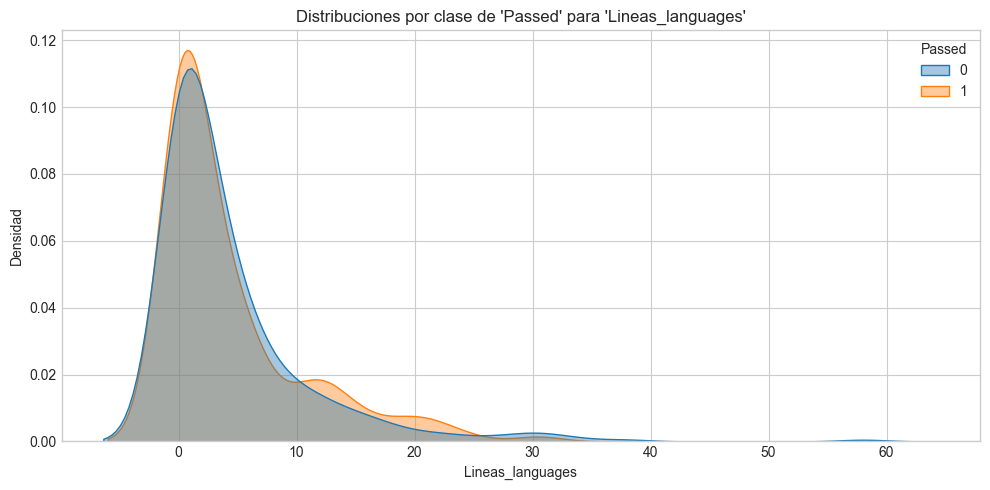

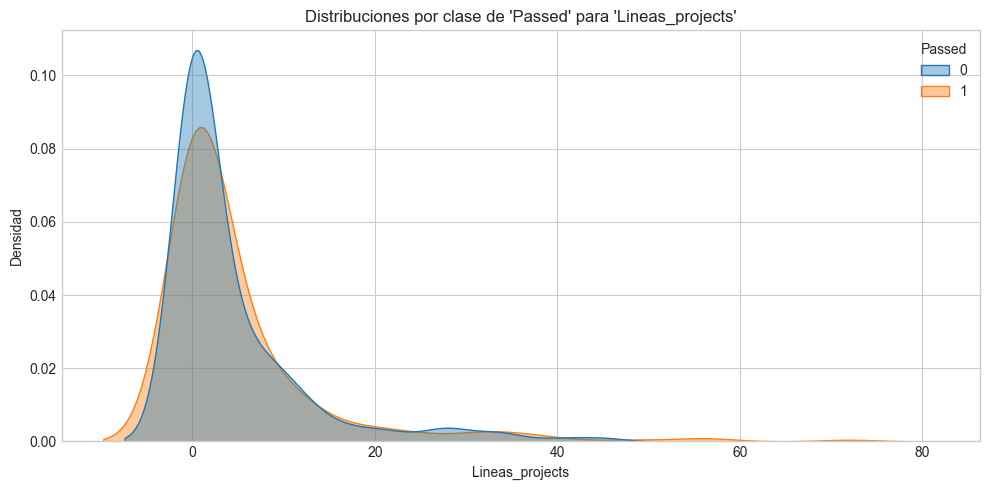

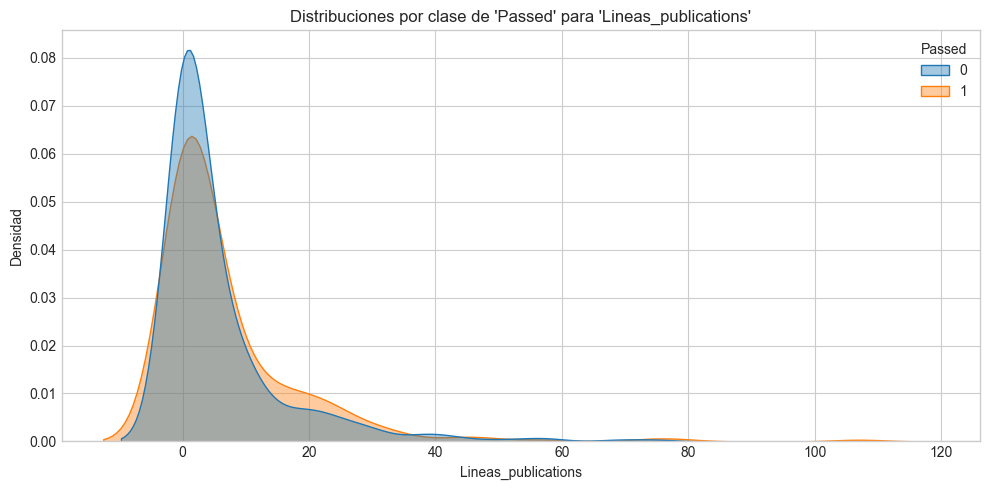

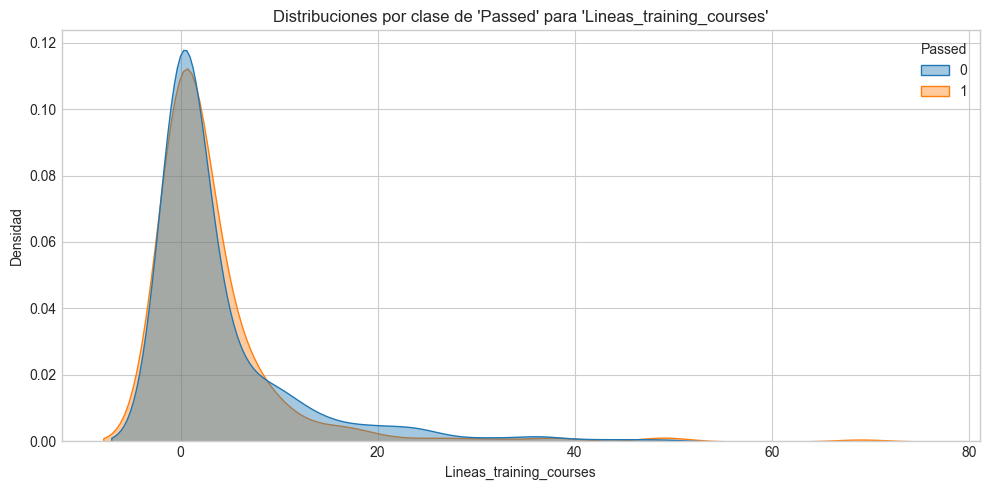

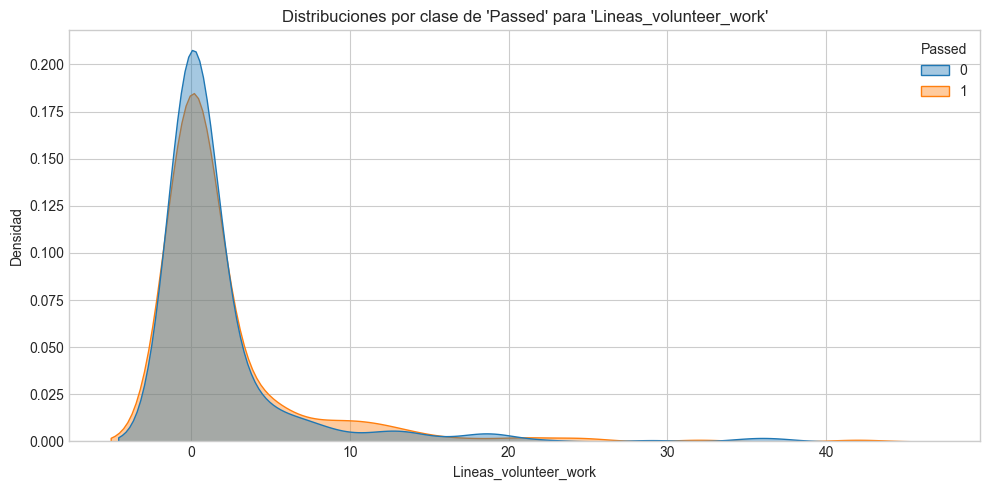

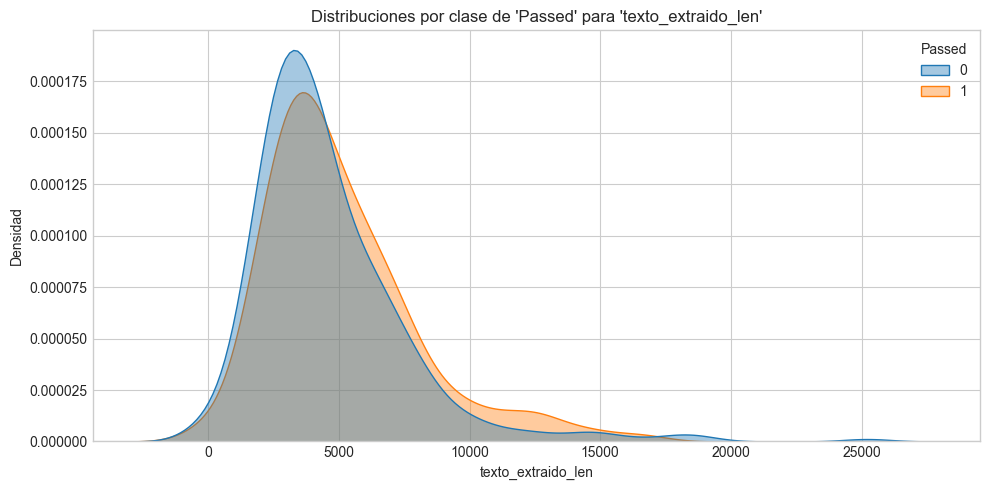

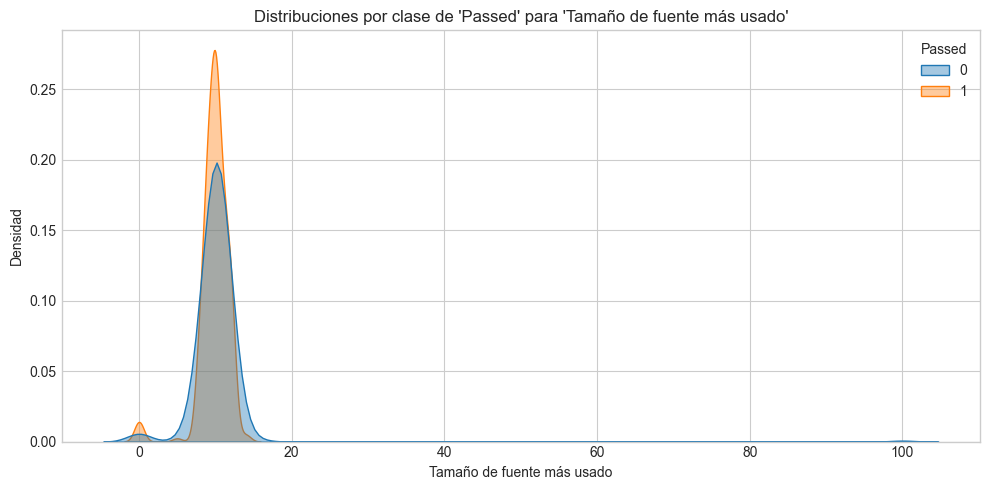

In [11]:
# Comparar distribuciones por clase de la variable objetivo
target = 'Passed'  # Cambia esto por el nombre de tu variable objetivo

for col in numerical_cols:
    plt.figure(figsize=(10, 5))

    # Separar por clases de la variable objetivo
    if target in df.columns:
        sns.kdeplot(data=df, x=col, hue=target, common_norm=False, fill=True, alpha=0.4)

    # Títulos
    plt.title(f"Distribuciones por clase de '{target}' para '{col}'")
    plt.xlabel(col)
    plt.ylabel("Densidad")

    plt.tight_layout()
    plt.show()


### Correlacion entre pares variables

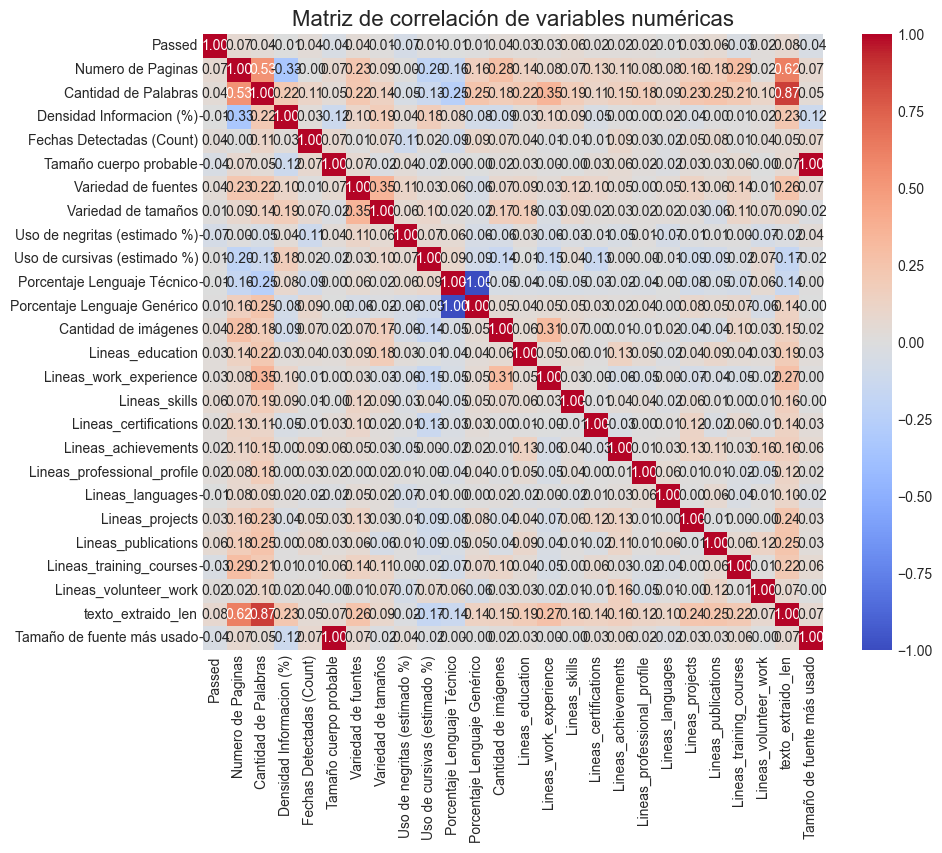

Pares de variables con correlación fuerte:
Cantidad de Palabras  texto_extraido_len    0.873078
dtype: float64 



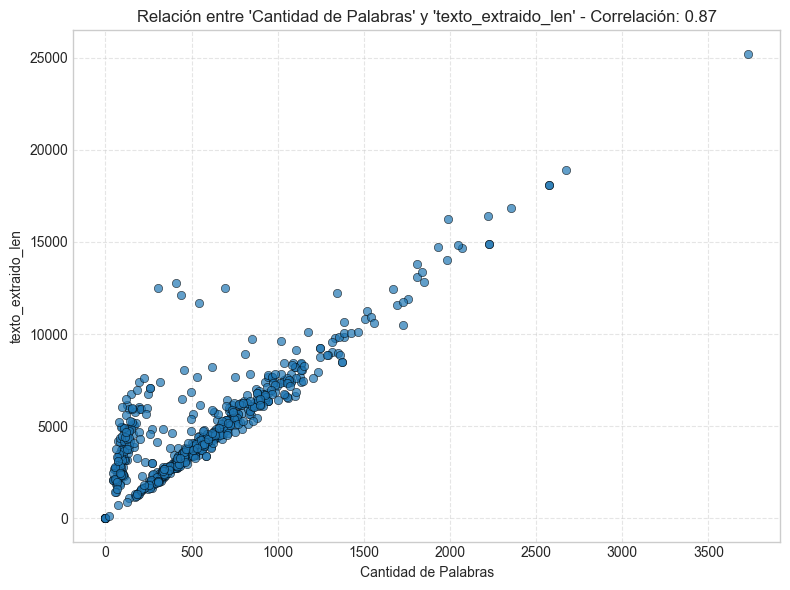

In [12]:
# Seleccionar solo columnas numéricas
numerical_cols = df.select_dtypes(include=["number"]).columns

# Calcular la matriz de correlación
corr_matrix = df[numerical_cols].corr()

# Mostrar la matriz de correlación como un mapa de calor para identificar relaciones fuertes (opcionales)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación de variables numéricas", fontsize=16)
plt.show()

# Seleccionar las correlaciones más altas
threshold = 0.7  # Umbral para considerar correlaciones fuertes
strong_correlations = corr_matrix[(corr_matrix.abs() > threshold) & (corr_matrix.abs() < 1)].unstack().dropna()
strong_correlations = strong_correlations.drop_duplicates().sort_values(ascending=False)

# Mostrar las pares de variables con correlación alta
print("Pares de variables con correlación fuerte:")
print(strong_correlations, "\n")

# Graficar scatterplots para las relaciones con correlaciones fuertes
for (var1, var2) in strong_correlations.index:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[var1], y=df[var2], alpha=0.7, edgecolor="k")
    plt.title(f"Relación entre '{var1}' y '{var2}' - Correlación: {strong_correlations[(var1, var2)]:.2f}")
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


### Correlación hacia la variable passed

In [13]:
# Seleccionar columnas numéricas y la variable objetivo
numerical_cols = df.select_dtypes(include=["number"]).columns
if 'Passed' in numerical_cols:
    numerical_cols = numerical_cols.drop('Passed')  # Excluir 'Passed' de la lista si ya es numérica

# Calcular correlaciones de las variables numéricas con 'Passed'
correlations_with_passed = df[numerical_cols].corrwith(df['Passed']).sort_values(ascending=False)

# Mostrar las correlaciones con 'Passed'
print("Correlaciones entre las variables y 'Passed':")
print(correlations_with_passed, "\n")

# Filtrar las correlaciones fuertes (umbral ajustable)
threshold = 0.3  # Cambiar el umbral según lo que desees considerar como fuerte
strong_correlations = correlations_with_passed[correlations_with_passed.abs() > threshold]

if not strong_correlations.empty:
    print("Variables con correlaciones fuertes hacia 'Passed':")
    print(strong_correlations, "\n")

    # Graficar scatterplots para las correlaciones fuertes
    for var in strong_correlations.index:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=df[var], y=df['Passed'], alpha=0.7, edgecolor="k")
        plt.title(f"Relación entre '{var}' y 'Passed' - Correlación: {strong_correlations[var]:.2f}")
        plt.xlabel(var)
        plt.ylabel('Passed')
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()
else:
    print(f"No hay variables con correlaciones mayores a {threshold} con 'Passed'")


Correlaciones entre las variables y 'Passed':
texto_extraido_len              0.077193
Numero de Paginas               0.066506
Lineas_skills                   0.058905
Lineas_publications             0.056885
Variedad de fuentes             0.040032
Cantidad de Palabras            0.039900
Cantidad de imágenes            0.035832
Fechas Detectadas (Count)       0.035664
Lineas_projects                 0.033511
Lineas_education                0.029298
Lineas_work_experience          0.026319
Lineas_professional_profile     0.023867
Lineas_certifications           0.023342
Lineas_volunteer_work           0.023330
Lineas_achievements             0.015958
Variedad de tamaños             0.009498
Uso de cursivas (estimado %)    0.006785
Porcentaje Lenguaje Genérico    0.005916
Lineas_languages               -0.005255
Porcentaje Lenguaje Técnico    -0.005916
Densidad Informacion (%)       -0.006723
Lineas_training_courses        -0.031485
Tamaño cuerpo probable         -0.040241
Tamaño de f

### Variables binarias vs Passed

### Transformación de variables para el modelado

Transformamos booleanos en números y hacemos Label Encoding para las categóricas

In [14]:
df

Categoria Original  Passed status_procesamiento  Numero de Paginas  \
0              Exitoso       1           Completado                  2   
1              Exitoso       1           Completado                  1   
2              Exitoso       1           Completado                  1   
3              Exitoso       1           Completado                  4   
4              Exitoso       1           Completado                  3   
..                 ...     ...                  ...                ...   
630         No Exitoso       0           Completado                  6   
631         No Exitoso       0           Completado                 10   
632         No Exitoso       0           Completado                  3   
633         No Exitoso       0           Completado                  1   
634         No Exitoso       0           Completado                  4   

     Cantidad de Palabras  Densidad Informacion (%) Formato Texto (Lineas)  \
0                     493                      5.71                Viñetas   
1                     388                      8.09                Viñetas   
2                     378                      8.27                  Mixto   
3                     656                      3.54                Viñetas   
4                     160                      4.71                Viñetas   
..                    ...                       ...                    ...   
630                  1372                      4.37                Viñetas   
631                  3729                      7.54                Viñetas   
632                   899                      6.13                Viñetas   
633                   185                      3.93                Viñetas   
634                   534                      5.95                Viñetas   

               Orden Temporal  Fechas Detectadas (Count)  \
0    Orden Temporal Detectado                          3   
1                Pocas Fechas                          1   
2                Pocas Fechas                          0   
3    Orden Temporal Detectado                          2   
4                Pocas Fechas                          0   
..                        ...                        ...   
630              Pocas Fechas                          0   
631  Orden Temporal Detectado                          3   
632              Pocas Fechas                          1   
633  Orden Temporal Detectado                          2   
634              Pocas Fechas                          0   

         Formato Fecha Más Común          Fuente principal  \
0                  Mon YYYY (EN)             Garamond-Bold   
1                        MM/YYYY  NotoSansZanabazarSquare-   
2                  Mon YYYY (EN)                   ArialMT   
3    SpaCy DATE (Sin clasificar)        Montserrat-Regular   
4                           YYYY              Lato-Regular   
..                           ...                       ...   
630                Mon YYYY (EN)                   Calibri   
631                         YYYY                   Calibri   
632  SpaCy DATE (Sin clasificar)             OpenSans-Bold   
633                         YYYY      DidactGothic-Regular   
634           Mes YYYY (ES Comp)               ComicSansMS   

     Tamaño cuerpo probable        Legibilidad general  Variedad de fuentes  \
0                        12                      Buena                    7   
1                         9  Potencialmente Deficiente                    1   
2                        10                      Buena                    3   
3                        10                      Buena                    4   
4                        10                      Buena                    6   
..                      ...                        ...                  ...   
630                      11                      Buena                    8   
631                      11                      Buena                    7   
6

In [15]:
for col in df.select_dtypes(include='bool').columns:
    df[col] = df[col].astype(int)

In [16]:
df

Categoria Original  Passed status_procesamiento  Numero de Paginas  \
0              Exitoso       1           Completado                  2   
1              Exitoso       1           Completado                  1   
2              Exitoso       1           Completado                  1   
3              Exitoso       1           Completado                  4   
4              Exitoso       1           Completado                  3   
..                 ...     ...                  ...                ...   
630         No Exitoso       0           Completado                  6   
631         No Exitoso       0           Completado                 10   
632         No Exitoso       0           Completado                  3   
633         No Exitoso       0           Completado                  1   
634         No Exitoso       0           Completado                  4   

     Cantidad de Palabras  Densidad Informacion (%) Formato Texto (Lineas)  \
0                     493                      5.71                Viñetas   
1                     388                      8.09                Viñetas   
2                     378                      8.27                  Mixto   
3                     656                      3.54                Viñetas   
4                     160                      4.71                Viñetas   
..                    ...                       ...                    ...   
630                  1372                      4.37                Viñetas   
631                  3729                      7.54                Viñetas   
632                   899                      6.13                Viñetas   
633                   185                      3.93                Viñetas   
634                   534                      5.95                Viñetas   

               Orden Temporal  Fechas Detectadas (Count)  \
0    Orden Temporal Detectado                          3   
1                Pocas Fechas                          1   
2                Pocas Fechas                          0   
3    Orden Temporal Detectado                          2   
4                Pocas Fechas                          0   
..                        ...                        ...   
630              Pocas Fechas                          0   
631  Orden Temporal Detectado                          3   
632              Pocas Fechas                          1   
633  Orden Temporal Detectado                          2   
634              Pocas Fechas                          0   

         Formato Fecha Más Común          Fuente principal  \
0                  Mon YYYY (EN)             Garamond-Bold   
1                        MM/YYYY  NotoSansZanabazarSquare-   
2                  Mon YYYY (EN)                   ArialMT   
3    SpaCy DATE (Sin clasificar)        Montserrat-Regular   
4                           YYYY              Lato-Regular   
..                           ...                       ...   
630                Mon YYYY (EN)                   Calibri   
631                         YYYY                   Calibri   
632  SpaCy DATE (Sin clasificar)             OpenSans-Bold   
633                         YYYY      DidactGothic-Regular   
634           Mes YYYY (ES Comp)               ComicSansMS   

     Tamaño cuerpo probable        Legibilidad general  Variedad de fuentes  \
0                        12                      Buena                    7   
1                         9  Potencialmente Deficiente                    1   
2                        10                      Buena                    3   
3                        10                      Buena                    4   
4                        10                      Buena                    6   
..                      ...                        ...                  ...   
630                      11                      Buena                    8   
631                      11                      Buena                    7   
6

### Eliminar filas que no pudieron ser procesadas

In [17]:
valor_a_eliminar = 'Advertencia: No se extrajo texto'

# 2. Crea una condición booleana: True para las filas que quieres MANTENER
#    (Es decir, donde 'status_procesamiento' es DIFERENTE al valor a eliminar)
condicion = df['status_procesamiento'] != valor_a_eliminar

df = df[condicion]

In [18]:
df

Categoria Original  Passed status_procesamiento  Numero de Paginas  \
0              Exitoso       1           Completado                  2   
1              Exitoso       1           Completado                  1   
2              Exitoso       1           Completado                  1   
3              Exitoso       1           Completado                  4   
4              Exitoso       1           Completado                  3   
..                 ...     ...                  ...                ...   
630         No Exitoso       0           Completado                  6   
631         No Exitoso       0           Completado                 10   
632         No Exitoso       0           Completado                  3   
633         No Exitoso       0           Completado                  1   
634         No Exitoso       0           Completado                  4   

     Cantidad de Palabras  Densidad Informacion (%) Formato Texto (Lineas)  \
0                     493                      5.71                Viñetas   
1                     388                      8.09                Viñetas   
2                     378                      8.27                  Mixto   
3                     656                      3.54                Viñetas   
4                     160                      4.71                Viñetas   
..                    ...                       ...                    ...   
630                  1372                      4.37                Viñetas   
631                  3729                      7.54                Viñetas   
632                   899                      6.13                Viñetas   
633                   185                      3.93                Viñetas   
634                   534                      5.95                Viñetas   

               Orden Temporal  Fechas Detectadas (Count)  \
0    Orden Temporal Detectado                          3   
1                Pocas Fechas                          1   
2                Pocas Fechas                          0   
3    Orden Temporal Detectado                          2   
4                Pocas Fechas                          0   
..                        ...                        ...   
630              Pocas Fechas                          0   
631  Orden Temporal Detectado                          3   
632              Pocas Fechas                          1   
633  Orden Temporal Detectado                          2   
634              Pocas Fechas                          0   

         Formato Fecha Más Común          Fuente principal  \
0                  Mon YYYY (EN)             Garamond-Bold   
1                        MM/YYYY  NotoSansZanabazarSquare-   
2                  Mon YYYY (EN)                   ArialMT   
3    SpaCy DATE (Sin clasificar)        Montserrat-Regular   
4                           YYYY              Lato-Regular   
..                           ...                       ...   
630                Mon YYYY (EN)                   Calibri   
631                         YYYY                   Calibri   
632  SpaCy DATE (Sin clasificar)             OpenSans-Bold   
633                         YYYY      DidactGothic-Regular   
634           Mes YYYY (ES Comp)               ComicSansMS   

     Tamaño cuerpo probable        Legibilidad general  Variedad de fuentes  \
0                        12                      Buena                    7   
1                         9  Potencialmente Deficiente                    1   
2                        10                      Buena                    3   
3                        10                      Buena                    4   
4                        10                      Buena                    6   
..                      ...                        ...                  ...   
630                      11                      Buena                    8   
631                      11                      Buena                    7   
6

### Agrupar fuentes entre más comunes y otras para facilitar la lectura

In [19]:
# 1. Define la lista de fuentes que quieres mantener
fuentes_principales = ['ArialMT', 'Calibri', 'Tahoma', 'Roboto-Regular',
                       'Lato-Regular', 'OpenSans-Regular', 'Ninguna']

# 2. Crea una condición booleana: True para las filas cuya fuente NO ESTÁ en la lista
#    El símbolo '~' niega el resultado de isin()
condicion_otras = ~df['Fuente principal'].isin(fuentes_principales)

# 3. Usa .loc para seleccionar esas filas (condicion_otras) y la columna 'Fuente principal',
#    y asígnales el nuevo valor 'Otra'.
#    ¡Esto modifica el DataFrame original directamente!
#    Si no quieres modificar el original, haz una copia antes: df_copia = df.copy()
df.loc[condicion_otras, 'Fuente principal'] = 'Otra'

df

Categoria Original  Passed status_procesamiento  Numero de Paginas  \
0              Exitoso       1           Completado                  2   
1              Exitoso       1           Completado                  1   
2              Exitoso       1           Completado                  1   
3              Exitoso       1           Completado                  4   
4              Exitoso       1           Completado                  3   
..                 ...     ...                  ...                ...   
630         No Exitoso       0           Completado                  6   
631         No Exitoso       0           Completado                 10   
632         No Exitoso       0           Completado                  3   
633         No Exitoso       0           Completado                  1   
634         No Exitoso       0           Completado                  4   

     Cantidad de Palabras  Densidad Informacion (%) Formato Texto (Lineas)  \
0                     493                      5.71                Viñetas   
1                     388                      8.09                Viñetas   
2                     378                      8.27                  Mixto   
3                     656                      3.54                Viñetas   
4                     160                      4.71                Viñetas   
..                    ...                       ...                    ...   
630                  1372                      4.37                Viñetas   
631                  3729                      7.54                Viñetas   
632                   899                      6.13                Viñetas   
633                   185                      3.93                Viñetas   
634                   534                      5.95                Viñetas   

               Orden Temporal  Fechas Detectadas (Count)  \
0    Orden Temporal Detectado                          3   
1                Pocas Fechas                          1   
2                Pocas Fechas                          0   
3    Orden Temporal Detectado                          2   
4                Pocas Fechas                          0   
..                        ...                        ...   
630              Pocas Fechas                          0   
631  Orden Temporal Detectado                          3   
632              Pocas Fechas                          1   
633  Orden Temporal Detectado                          2   
634              Pocas Fechas                          0   

         Formato Fecha Más Común Fuente principal  Tamaño cuerpo probable  \
0                  Mon YYYY (EN)             Otra                      12   
1                        MM/YYYY             Otra                       9   
2                  Mon YYYY (EN)          ArialMT                      10   
3    SpaCy DATE (Sin clasificar)             Otra                      10   
4                           YYYY     Lato-Regular                      10   
..                           ...              ...                     ...   
630                Mon YYYY (EN)          Calibri                      11   
631                         YYYY          Calibri                      11   
632  SpaCy DATE (Sin clasificar)             Otra                      11   
633                         YYYY             Otra                      10   
634           Mes YYYY (ES Comp)             Otra                      11   

           Legibilidad general  Variedad de fuentes  Variedad de tamaños  \
0                        Buena                    7                    5   
1    Potencialmente Deficiente                    1                    1   
2                        Buena                    3                    4   
3                        Buena                    4                   12   
4                        Buena                    6                    7   
..                         ...                  ...                  ...   


### Transformar la variable 'Tamaño de fuente detectados' por 'Promedio tamaño de fuente, para más fácil lectura del módelo.

In [20]:
def convertir_a_lista(valor):
    """Intenta convertir un valor a lista usando ast.literal_eval."""
    if isinstance(valor, str): # Solo procesa si es un string
        try:
            # Intenta evaluar el string como una estructura literal de Python (lista)
            return ast.literal_eval(valor)
        except (ValueError, SyntaxError):
            # Si no se puede evaluar (no es un string tipo lista válido), devuelve None o NaN
            return np.nan # O podrías devolver una lista vacía: []
    elif isinstance(valor, list):
         # Si ya es una lista, devuélvela tal cual
        return valor
    else:
        # Si es None, NaN u otro tipo, devuelve NaN
        return np.nan

# Aplica la función de conversión a la columna
# Esto sobreescribe la columna original con listas reales (o NaN si falla)
df['Tamaños fuente detectados'] = df['Tamaños fuente detectados'].apply(convertir_a_lista)

# --- Ahora, vuelve a intentar calcular el promedio ---

def calcular_promedio_lista(lista):
    # Verifica si es una lista y si no está vacía
    if isinstance(lista, list) and len(lista) > 0:
        # Asegurarse que todos los elementos son numéricos (opcional pero más robusto)
        elementos_numericos = [x for x in lista if isinstance(x, (int, float))]
        if len(elementos_numericos) > 0:
             return sum(elementos_numericos) / len(elementos_numericos)
        else:
             return np.nan # Si la lista no tenía números
    return np.nan # Si no es lista, está vacía, o no tenía números


# Aplica la función de promedio (ahora sobre las listas reales)
df['Promedio tamaño fuente'] = df['Tamaños fuente detectados'].apply(calcular_promedio_lista)

#Eliminar nulos
df.dropna()

Categoria Original  Passed status_procesamiento  Numero de Paginas  \
0              Exitoso       1           Completado                  2   
1              Exitoso       1           Completado                  1   
2              Exitoso       1           Completado                  1   
3              Exitoso       1           Completado                  4   
4              Exitoso       1           Completado                  3   
..                 ...     ...                  ...                ...   
630         No Exitoso       0           Completado                  6   
631         No Exitoso       0           Completado                 10   
632         No Exitoso       0           Completado                  3   
633         No Exitoso       0           Completado                  1   
634         No Exitoso       0           Completado                  4   

     Cantidad de Palabras  Densidad Informacion (%) Formato Texto (Lineas)  \
0                     493                      5.71                Viñetas   
1                     388                      8.09                Viñetas   
2                     378                      8.27                  Mixto   
3                     656                      3.54                Viñetas   
4                     160                      4.71                Viñetas   
..                    ...                       ...                    ...   
630                  1372                      4.37                Viñetas   
631                  3729                      7.54                Viñetas   
632                   899                      6.13                Viñetas   
633                   185                      3.93                Viñetas   
634                   534                      5.95                Viñetas   

               Orden Temporal  Fechas Detectadas (Count)  \
0    Orden Temporal Detectado                          3   
1                Pocas Fechas                          1   
2                Pocas Fechas                          0   
3    Orden Temporal Detectado                          2   
4                Pocas Fechas                          0   
..                        ...                        ...   
630              Pocas Fechas                          0   
631  Orden Temporal Detectado                          3   
632              Pocas Fechas                          1   
633  Orden Temporal Detectado                          2   
634              Pocas Fechas                          0   

         Formato Fecha Más Común Fuente principal  Tamaño cuerpo probable  \
0                  Mon YYYY (EN)             Otra                      12   
1                        MM/YYYY             Otra                       9   
2                  Mon YYYY (EN)          ArialMT                      10   
3    SpaCy DATE (Sin clasificar)             Otra                      10   
4                           YYYY     Lato-Regular                      10   
..                           ...              ...                     ...   
630                Mon YYYY (EN)          Calibri                      11   
631                         YYYY          Calibri                      11   
632  SpaCy DATE (Sin clasificar)             Otra                      11   
633                         YYYY             Otra                      10   
634           Mes YYYY (ES Comp)             Otra                      11   

           Legibilidad general  Variedad de fuentes  Variedad de tamaños  \
0                        Buena                    7                    5   
1    Potencialmente Deficiente                    1                    1   
2                        Buena                    3                    4   
3                        Buena                    4                   12   
4                        Buena                    6                    7   
..                         ...                  ...                  ...   


In [21]:
df= df.dropna()

### Drop columns que no son útiles para el modelo o ya transformadas en otra variable

In [22]:
df = df.drop(columns=["Categoria Original","status_procesamiento", "Tamaños fuente detectados", ], errors="ignore")

In [23]:
df

Passed  Numero de Paginas  Cantidad de Palabras  \
0         1                  2                   493   
1         1                  1                   388   
2         1                  1                   378   
3         1                  4                   656   
4         1                  3                   160   
..      ...                ...                   ...   
630       0                  6                  1372   
631       0                 10                  3729   
632       0                  3                   899   
633       0                  1                   185   
634       0                  4                   534   

     Densidad Informacion (%) Formato Texto (Lineas)  \
0                        5.71                Viñetas   
1                        8.09                Viñetas   
2                        8.27                  Mixto   
3                        3.54                Viñetas   
4                        4.71                Viñetas   
..                        ...                    ...   
630                      4.37                Viñetas   
631                      7.54                Viñetas   
632                      6.13                Viñetas   
633                      3.93                Viñetas   
634                      5.95                Viñetas   

               Orden Temporal  Fechas Detectadas (Count)  \
0    Orden Temporal Detectado                          3   
1                Pocas Fechas                          1   
2                Pocas Fechas                          0   
3    Orden Temporal Detectado                          2   
4                Pocas Fechas                          0   
..                        ...                        ...   
630              Pocas Fechas                          0   
631  Orden Temporal Detectado                          3   
632              Pocas Fechas                          1   
633  Orden Temporal Detectado                          2   
634              Pocas Fechas                          0   

         Formato Fecha Más Común Fuente principal  Tamaño cuerpo probable  \
0                  Mon YYYY (EN)             Otra                      12   
1                        MM/YYYY             Otra                       9   
2                  Mon YYYY (EN)          ArialMT                      10   
3    SpaCy DATE (Sin clasificar)             Otra                      10   
4                           YYYY     Lato-Regular                      10   
..                           ...              ...                     ...   
630                Mon YYYY (EN)          Calibri                      11   
631                         YYYY          Calibri                      11   
632  SpaCy DATE (Sin clasificar)             Otra                      11   
633                         YYYY             Otra                      10   
634           Mes YYYY (ES Comp)             Otra                      11   

           Legibilidad general  Variedad de fuentes  Variedad de tamaños  \
0                        Buena                    7                    5   
1    Potencialmente Deficiente                    1                    1   
2                        Buena                    3                    4   
3                        Buena                    4                   12   
4                        Buena                    6                    7   
..                         ...                  ...                  ...   
630                      Buena                    8                    6   
631                      Buena                    7                    8   
632                      Buena                    4                    6   
633                      Buena                    2                    4   
634                      Buena                    3                    2   

    Consistencia tamaños fuente Consistencia márgenes (aprox)  \
0                   Consistente    

### Encoding de variables categóricas


In [24]:
df = pd.get_dummies(df)
for col in df.select_dtypes(include='bool').columns:
    df[col] = df[col].astype(int)

In [25]:
df

Passed  Numero de Paginas  Cantidad de Palabras  \
0         1                  2                   493   
1         1                  1                   388   
2         1                  1                   378   
3         1                  4                   656   
4         1                  3                   160   
..      ...                ...                   ...   
630       0                  6                  1372   
631       0                 10                  3729   
632       0                  3                   899   
633       0                  1                   185   
634       0                  4                   534   

     Densidad Informacion (%)  Fechas Detectadas (Count)  \
0                        5.71                          3   
1                        8.09                          1   
2                        8.27                          0   
3                        3.54                          2   
4                        4.71                          0   
..                        ...                        ...   
630                      4.37                          0   
631                      7.54                          3   
632                      6.13                          1   
633                      3.93                          2   
634                      5.95                          0   

     Tamaño cuerpo probable  Variedad de fuentes  Variedad de tamaños  \
0                        12                    7                    5   
1                         9                    1                    1   
2                        10                    3                    4   
3                        10                    4                   12   
4                        10                    6                    7   
..                      ...                  ...                  ...   
630                      11                    8                    6   
631                      11                    7                    8   
632                      11                    4                    6   
633                      10                    2                    4   
634                      11                    3                    2   

     Uso de negritas (estimado %)  Uso de cursivas (estimado %)  \
0                            34.4                          91.7   
1                             0.0                         100.0   
2                            21.8                         100.0   
3                            16.2                         100.0   
4                            31.2                           5.2   
..                            ...                           ...   
630                          32.7                          36.8   
631                           8.1                           5.4   
632                          62.7                           4.5   
633                           0.0                         100.0   
634                          39.9                           0.5   

     Porcentaje Lenguaje Técnico  Porcentaje Lenguaje Genérico  LinkedIn  \
0                           3.72                         96.28         1   
1                           9.61                         90.39         0   
2                           8.58                         91.42         0   
3                           6.67                         93.33         0   
4                          11.29                         88.71         1   
..                           ...                           ...       ...   
630                         6.72                         93.28         0   
631                         2.71                         97.29         0   
632                         5.04                         94.96         0   
633                         6.25                         93.75         0   
634                         5.55                         94.45         1   

     GitHub  Web

#### Número de secciones completas

In [26]:
secciones = ["Seccion_professional_profile", "Seccion_education", "Seccion_work_experience", "Seccion_skills",
             "Seccion_certifications", "Seccion_achievements", "Seccion_languages", "Seccion_projects",
             "Seccion_training_courses", "Seccion_volunteer_work"]

df["secciones_completas"] = df[secciones].apply(lambda row: (row > 0).sum(), axis=1)

In [27]:
df

Passed  Numero de Paginas  Cantidad de Palabras  \
0         1                  2                   493   
1         1                  1                   388   
2         1                  1                   378   
3         1                  4                   656   
4         1                  3                   160   
..      ...                ...                   ...   
630       0                  6                  1372   
631       0                 10                  3729   
632       0                  3                   899   
633       0                  1                   185   
634       0                  4                   534   

     Densidad Informacion (%)  Fechas Detectadas (Count)  \
0                        5.71                          3   
1                        8.09                          1   
2                        8.27                          0   
3                        3.54                          2   
4                        4.71                          0   
..                        ...                        ...   
630                      4.37                          0   
631                      7.54                          3   
632                      6.13                          1   
633                      3.93                          2   
634                      5.95                          0   

     Tamaño cuerpo probable  Variedad de fuentes  Variedad de tamaños  \
0                        12                    7                    5   
1                         9                    1                    1   
2                        10                    3                    4   
3                        10                    4                   12   
4                        10                    6                    7   
..                      ...                  ...                  ...   
630                      11                    8                    6   
631                      11                    7                    8   
632                      11                    4                    6   
633                      10                    2                    4   
634                      11                    3                    2   

     Uso de negritas (estimado %)  Uso de cursivas (estimado %)  \
0                            34.4                          91.7   
1                             0.0                         100.0   
2                            21.8                         100.0   
3                            16.2                         100.0   
4                            31.2                           5.2   
..                            ...                           ...   
630                          32.7                          36.8   
631                           8.1                           5.4   
632                          62.7                           4.5   
633                           0.0                         100.0   
634                          39.9                           0.5   

     Porcentaje Lenguaje Técnico  Porcentaje Lenguaje Genérico  LinkedIn  \
0                           3.72                         96.28         1   
1                           9.61                         90.39         0   
2                           8.58                         91.42         0   
3                           6.67                         93.33         0   
4                          11.29                         88.71         1   
..                           ...                           ...       ...   
630                         6.72                         93.28         0   
631                         2.71                         97.29         0   
632                         5.04                         94.96         0   
633                         6.25                         93.75         0   
634                         5.55                         94.45         1   

     GitHub  Web

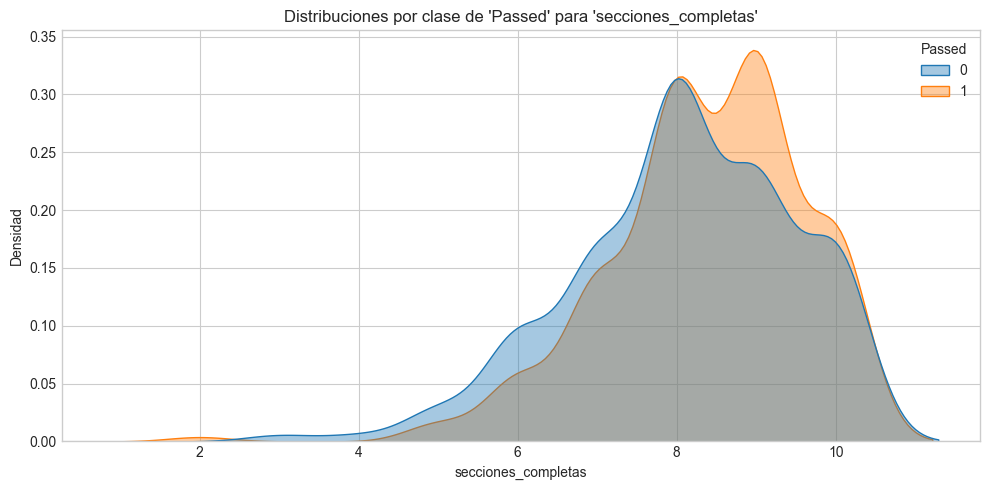

In [28]:
# Comparar distribuciones por clase de la variable objetivo solo para columnas con "tiene_seccion"
target = 'Passed'  # Cambia esto si tu variable objetivo tiene otro nombre

# Filtrar columnas que contienen "tiene_seccion" en su nombre
secciones_completas_cols = [col for col in df.columns if 'secciones_completas' in col]

# Iterar sobre las columnas que cumplen con la condición
for col in secciones_completas_cols:
    plt.figure(figsize=(10, 5))

    # Separar por clases de la variable objetivo
    if target in df.columns:
        sns.kdeplot(data=df, x=col, hue=target, common_norm=False, fill=True, alpha=0.4)

    # Títulos para los gráficos
    plt.title(f"Distribuciones por clase de '{target}' para '{col}'")
    plt.xlabel(col)
    plt.ylabel("Densidad")

    plt.tight_layout()
    plt.show()

In [29]:
df.to_csv('../Bases/base_cvs/baseCVsIngVar.csv')

## Exploración de la variable Passed con la nueva base



Distribución de la variable objetivo 'Passed':
Passed
0    352
1    262
Name: count, dtype: int64


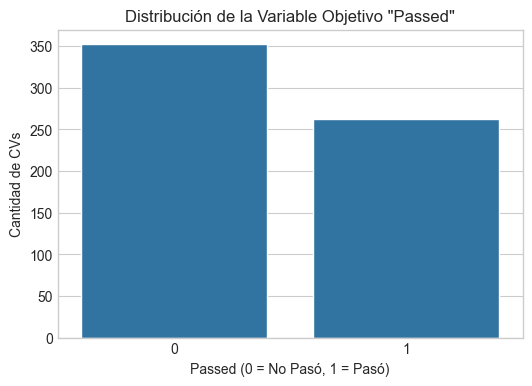

Ratio de desbalanceo (minoritaria/mayoritaria): 0.74


In [30]:
if 'Passed' in df.columns:
    print("\nDistribución de la variable objetivo 'Passed':")
    passed_counts = df['Passed'].value_counts()
    print(passed_counts)

    # Visualización de la distribución
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Passed', data=df)
    plt.title('Distribución de la Variable Objetivo "Passed"')
    plt.xlabel('Passed (0 = No Pasó, 1 = Pasó)')
    plt.ylabel('Cantidad de CVs')
    plt.show()

        # Revisar si hay desbalanceo significativo
    imbalance_ratio = passed_counts.min() / passed_counts.max()
    print(f"Ratio de desbalanceo (minoritaria/mayoritaria): {imbalance_ratio:.2f}")
    if imbalance_ratio < 0.1: # Umbral ejemplo
      print("Advertencia: El dataset parece estar muy desbalanceado.")

else:
    print("Error: La columna 'Passed' no se encontró en el DataFrame.")
    # Detener ejecución si 'Passed' no existe o manejar el error
    # exit()

### Variable númerica vs passed


Columnas numéricas continuas/discretas identificadas (27): ['Numero de Paginas', 'Cantidad de Palabras', 'Densidad Informacion (%)', 'Fechas Detectadas (Count)', 'Tamaño cuerpo probable', 'Variedad de fuentes', 'Variedad de tamaños', 'Uso de negritas (estimado %)', 'Uso de cursivas (estimado %)', 'Porcentaje Lenguaje Técnico']...
Columnas binarias (0/1) identificadas (49): ['LinkedIn', 'GitHub', 'Website/Otro', 'Tiene Elementos Graficos', 'Seccion_education', 'Seccion_work_experience', 'Seccion_skills', 'Seccion_certifications', 'Seccion_achievements', 'Seccion_professional_profile']...

--- Análisis: Variables Numéricas Continuas vs Passed ---

Medias de variables numéricas por grupo 'Passed':
Passed                                 0           1
Numero de Paginas               2.676136    3.022901
Cantidad de Palabras          563.153409  594.183206
Densidad Informacion (%)        5.952472    5.891947
Fechas Detectadas (Count)       1.323864    1.446565
Tamaño cuerpo probable        

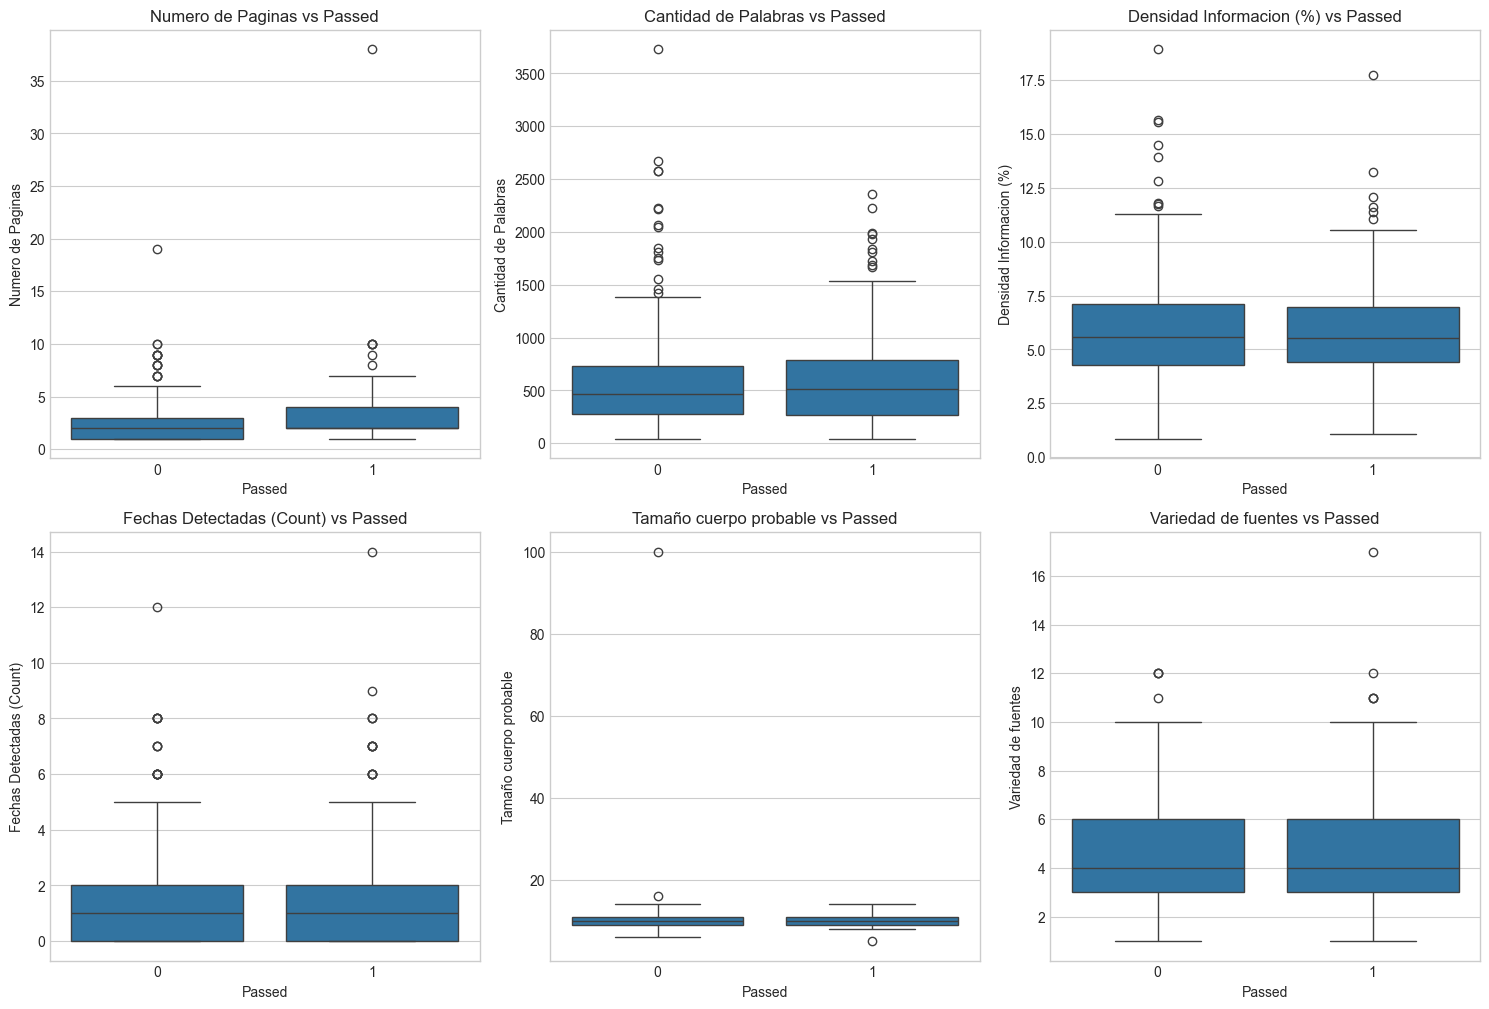

In [31]:
# Identificar columnas numéricas y binarias/categóricas (aproximación)
# Excluimos 'Passed' de las features
features = df.drop('Passed', axis=1).columns
numerical_cols = df[features].select_dtypes(include=np.number).columns
binary_cols = [col for col in numerical_cols if df[col].nunique() == 2 and df[col].min() == 0 and df[col].max() == 1]
# Consideraremos el resto de columnas numéricas como continuas o discretas (no estrictamente binarias 0/1)
continuous_numerical_cols = [col for col in numerical_cols if col not in binary_cols]

print(f"\nColumnas numéricas continuas/discretas identificadas ({len(continuous_numerical_cols)}): {continuous_numerical_cols[:10]}...") # Mostrar solo algunas
print(f"Columnas binarias (0/1) identificadas ({len(binary_cols)}): {binary_cols[:10]}...") # Mostrar solo algunas

# 3.1: Variables Numéricas vs 'Passed'
print("\n--- Análisis: Variables Numéricas Continuas vs Passed ---")
# Comparar medias
print("\nMedias de variables numéricas por grupo 'Passed':")
print(df.groupby('Passed')[continuous_numerical_cols].mean().T.head(20)) # Mostrar solo las 10 primeras

# Realizar T-tests (ejemplo para algunas variables)
print("\nResultados T-test (p-value < 0.05 sugiere diferencia significativa):")
for col in numerical_cols: # Ejemplo
    if col in continuous_numerical_cols:
        group0 = df[df['Passed'] == 0][col].dropna()
        group1 = df[df['Passed'] == 1][col].dropna()
        if len(group0) > 1 and len(group1) > 1:
             stat, p_value = ttest_ind(group0, group1)
             print(f"  - {col}: p-value = {p_value:.4f}")

plt.figure(figsize=(15, 5 * (len(continuous_numerical_cols)//3 + 1)))
for i, col in enumerate(continuous_numerical_cols[:6]): # Visualizar las primeras 6
    plt.subplot((len(continuous_numerical_cols)//3 + 1), 3, i + 1)
    sns.boxplot(x='Passed', y=col, data=df)
    plt.title(f'{col} vs Passed')
plt.tight_layout()
plt.show()

## Análisis incial

Lo primero que debemos tener en cuenta, es que en términos de media, existen más CVs dentro de las que pasaron con un mayor número en las variables Numero de Paginas, Cantidad de Palabras, Cantidad de imágenes, Lineas_work_experience, Lineas_skills, Lineas_professional_profile, texto_extraido_len, secciones_completas. Esto, nos da a entender que es muy posible que las HVs más largas, hayan tenido una mayor probabilidad de éxito.

Aunque, para descartar el simple hecho de que es porque tienen más experiencia, es necesario crear una proporción de experiencia laboral vs total del texto. Esto se hará a continuación.

De la misma manera, podemos ver que las variables Tamaño cuerpo (fuente) probable, Uso de negritas (estimado %) cuentan con menor tamaño en las CVs que pasaron, lo que nos da una idea de que se buscan CVs con tamaños de fuente algo más "conservadores" y menos negritas en las CVs.

Las variables Densidad Informacion (%) y Porcentaje Lenguaje Técnico, contrario a lo que se pensaría, son casi idénticas en ambos grupos, por lo que no deberían representar algo significativo en la cv. aunque lo podemos ver más adelante.


### Prueba-t
La prueba t compara medias y nos muestra si hay una significancia estadística o no entre las diferencias observadas.

De acuerdo con esta prueba texto_extraido_len y secciones_completas son las variables que más significancia estadística cuentan entre los grupos passed y no-passed. De acuerdo con esto, es posible decir que las CVs con mayor longitud en su texto así como con mayor cantidad de secciones completas, son las que más probabilidad tienen de pasar.

Así mismo, hay otras que tienen una significancia algo más leve, como lo son Número de Páginas y Uso de negritas (estimado %), en donde con un mayor número de páginas existe una leve probabilidad de pasar, mientras que con un menor número de negritas, también hay una leve probabilidad de encontrarse en el grupo que pasó.



### Variables Binarias vs Passed


--- Análisis: Variables Binarias vs Passed ---

Resultados Chi-Cuadrado (p-value < 0.05 sugiere asociación significativa):
  - LinkedIn: p-value = 1.0000
  - GitHub: p-value = 0.8714
  - Website/Otro: p-value = 0.0124
  - Tiene Elementos Graficos: p-value = 0.7574
  - Seccion_education: p-value = 0.8172
  - Seccion_work_experience: p-value = 1.0000
  - Seccion_skills: p-value = 0.1659
  - Seccion_certifications: p-value = 0.4531
  - Seccion_achievements: p-value = 0.5532
  - Seccion_professional_profile: p-value = 0.7648
  - Seccion_languages: p-value = 0.1161
  - Seccion_projects: p-value = 0.1795
  - Seccion_publications: p-value = 0.2209
  - Seccion_training_courses: p-value = 0.0325
  - Seccion_volunteer_work: p-value = 0.3840
  - Formato Texto (Lineas)_Mixto: p-value = 0.6230
  - Formato Texto (Lineas)_Párrafos: p-value = 0.5117
  - Formato Texto (Lineas)_Viñetas: p-value = 0.4070
  - Orden Temporal_Orden Temporal Detectado: p-value = 0.9592
  - Orden Temporal_Pocas Fechas: p-val

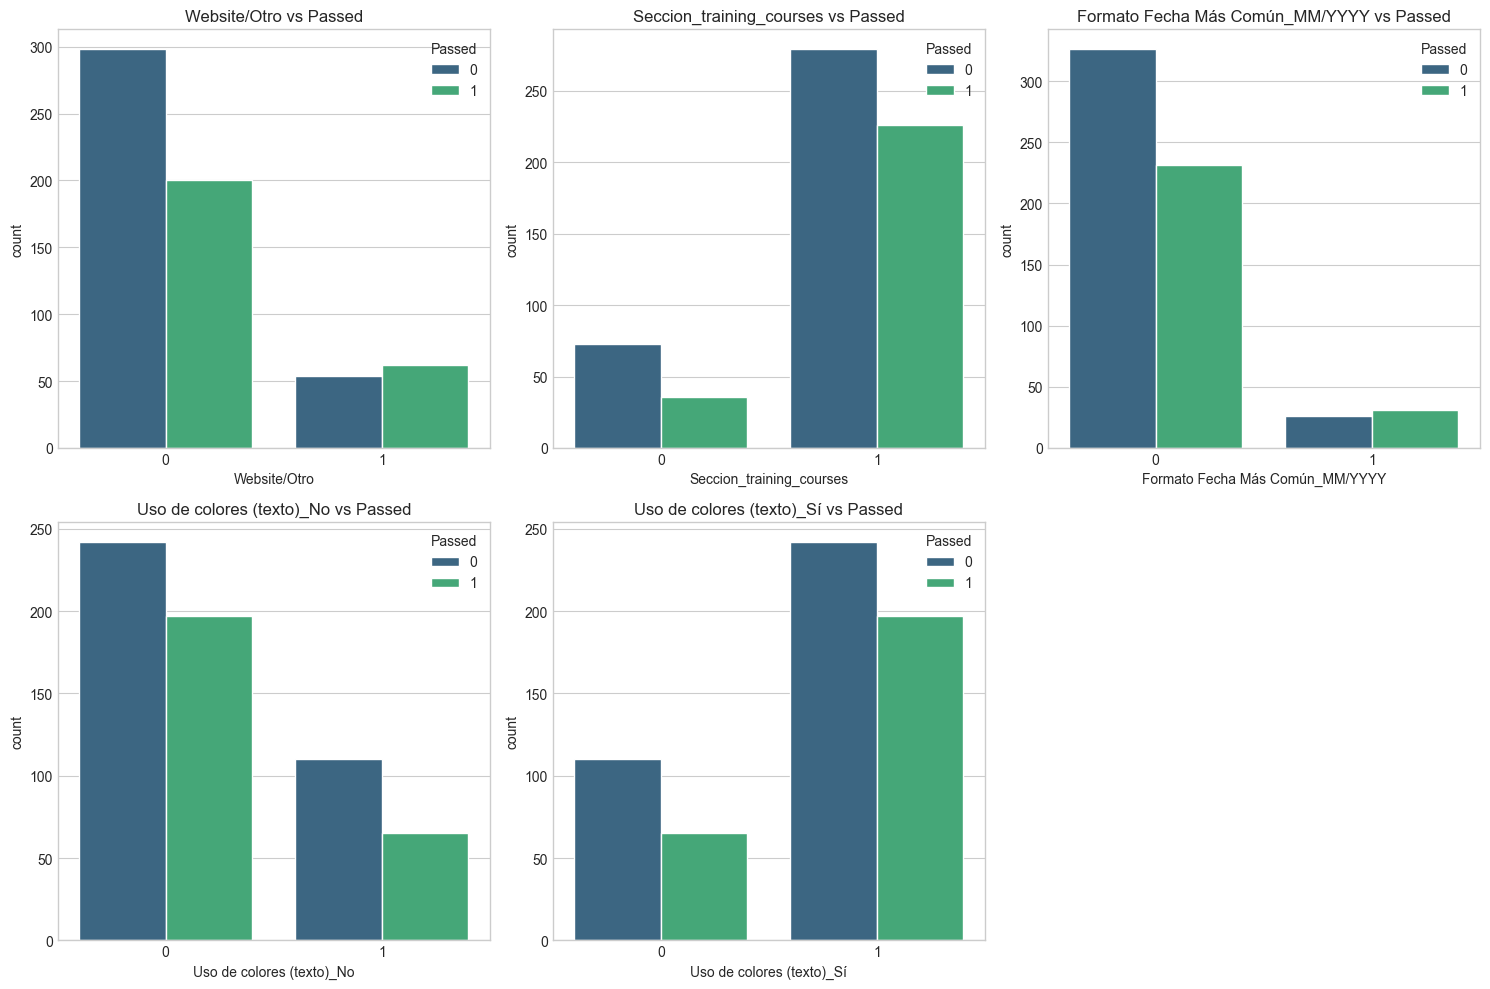

In [32]:
# 3.2: Variables Binarias vs 'Passed'
print("\n--- Análisis: Variables Binarias vs Passed ---")
# Tablas de contingencia y Chi-cuadrado (ejemplo para algunas variables)
print("\nResultados Chi-Cuadrado (p-value < 0.05 sugiere asociación significativa):")
significant_binary_vars = []
for col in binary_cols[:51]: # Analizar las primeras 10 binarias como ejemplo
    contingency_table = pd.crosstab(df[col], df['Passed'])
    #print(f"\nTabla de Contingencia para {col}:\n{contingency_table}")
    try:
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        print(f"  - {col}: p-value = {p:.4f}")
        if p < 0.1:
            significant_binary_vars.append(col)
    except ValueError:
         print(f"  - {col}: No se pudo calcular Chi2 (posiblemente poca variación).")

print(f"\nVariables binarias con asociación significativa (p<0.05, ejemplo): {significant_binary_vars}")

# Visualización (ejemplo con Count Plots para variables significativas)
if significant_binary_vars:
    plt.figure(figsize=(15, 5 * (len(significant_binary_vars)//3 + 1)))
    for i, col in enumerate(significant_binary_vars):
        plt.subplot((len(significant_binary_vars)//3 + 1), 3, i + 1)
        sns.countplot(x=col, hue='Passed', data=df, palette='viridis')
        plt.title(f'{col} vs Passed')
    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron variables binarias significativamente asociadas en el ejemplo analizado.")

### Prueba chi-cuadrado
La prueba Chi-cuadrado muestra si existe una asociación entre variables categóricas.

Siendo así, las variables Website/Otro, Seccion_training_courses, son las que presentan una mayor significancia estadística frente a su asociación con la variable 'Passed', lo cual nos refiere que personas que tienen un website personal, portafolio o incluso un link a los productos que construyeron, tienen una mayor probabilidad de pertenecer al grupo de Passed. Por otro lado, es posible que las personas que muestran educación adicional a al tradicional, teniendo cursos, certificaciones, diplomados, etc, tiene mayor probabilidad de pasar.

Así mismo, variables que muestran relación aunque algo más leve son Seccion_languages, Seccion_publications, Formato Fecha Más Común_MM/YYYY, Fuente principal_Tahoma, Uso de colores (texto)_No/Si, lo que nos dice que personas que muestran explícitamente que hablan otro idioma o que realizaron la publicación de algún trabajo académico, aplicación o programa (recordemos que todos son Desarrolladores de software) tienen ligeramente más posibilidad de pertenecer al grupo que pasó. Así mismo, las personas que mostraron las fechas en las que trabajaron usando el formato MM/YYYY, ligeramente pueden estar pasando más frente a personas que no. Esto teniendo en cuenta la variedad de fechas, muestra que es importante mostrar no solo el año como en una gran cantidad de CVs, sino también el mes, en el formato de número el cual puede ser más fácil de entender para muchas personas y más sencillo entender la duración de las personas en sus respectivas experiencias. Por otro lado, la fuente principal tahoma, aunque diciente, posiblemente también es porque es una fuente sin serifas y de fácil lectura. Por otro lado, el uso de colores levemente nos puede ubicar en la variable passed.

## Nuevas variables
Crearemos el ratio de work-experience/longitud total, para entender si la cantidad de experiencia laboral total influye en algo. Así mismo, una que nos compare el número de secciones frente al texto total, con el objetivo de entender que tan densa es cada sección y si esta completitud afecta en la cantidad del texto también.

In [33]:
denominator_len = df['texto_extraido_len']
df['Ratio_Lineas_Experiencia_len'] = np.divide(
    df['Lineas_work_experience'],
    denominator_len,
    out=np.zeros_like(df['Lineas_work_experience'], dtype=float), # Salida por defecto (0.0)
    where=denominator_len!=0 # Condición para realizar la división
)
print("- Variable 'Ratio_Lineas_Experiencia_len' creada.")

# Opción B: Basado en cantidad de palabras
# Manejo de división por cero: si Cantidad de Palabras es 0, el ratio será 0.
denominator_words = df['Cantidad de Palabras']
df['Ratio_Lineas_Experiencia_words'] = np.divide(
    df['Lineas_work_experience'],
    denominator_words,
    out=np.zeros_like(df['Lineas_work_experience'], dtype=float), # Salida por defecto (0.0)
    where=denominator_words!=0 # Condición para realizar la división
)
print("- Variable 'Ratio_Lineas_Experiencia_words' creada.")


# --- Variable 2: Densidad_Texto_Por_Seccion ---
# Calcula la longitud promedio del texto por sección detectada.
# Manejo de división por cero: si secciones_completas es 0, asignamos 0 (o podrías usar np.nan).
denominator_secciones = df['secciones_completas']
df['Densidad_Texto_Por_Seccion'] = np.divide(
    df['texto_extraido_len'],
    denominator_secciones,
    out=np.zeros_like(df['texto_extraido_len'], dtype=float), # Salida por defecto (0.0)
    where=denominator_secciones!=0 # Condición para realizar la división
)
# Podrías considerar usar Cantidad de Palabras en lugar de texto_extraido_len aquí también si prefieres
# df['Densidad_Palabras_Por_Seccion'] = np.divide(...)
print("- Variable 'Densidad_Texto_Por_Seccion' creada.")


# --- Verificar las nuevas columnas ---
print("\n--- Primeras filas con las nuevas variables ---")
# Selecciona cuál de los ratios de experiencia quieres ver o muestra ambos
columns_to_show = [
    'Lineas_work_experience', 'texto_extraido_len', 'Cantidad de Palabras', 'secciones_completas',
    'Ratio_Lineas_Experiencia_len', # O '_words'
    'Densidad_Texto_Por_Seccion'
]
# Filtrar por si alguna columna base no existiera (aunque deberían existir)
columns_to_show = [col for col in columns_to_show if col in df.columns]
print(df[columns_to_show].head())

print("\n--- Descriptivos básicos de las nuevas variables ---")
new_columns = [col for col in ['Ratio_Lineas_Experiencia_len', 'Ratio_Lineas_Experiencia_words', 'Densidad_Texto_Por_Seccion'] if col in df.columns]
if new_columns:
    print(df[new_columns].describe())
else:
    print("No se encontraron las nuevas columnas para describir.")

- Variable 'Ratio_Lineas_Experiencia_len' creada.
- Variable 'Ratio_Lineas_Experiencia_words' creada.
- Variable 'Densidad_Texto_Por_Seccion' creada.

--- Primeras filas con las nuevas variables ---
   Lineas_work_experience  texto_extraido_len  Cantidad de Palabras  \
0                       2                3692                   493   
1                      12                2703                   388   
2                      38                2761                   378   
3                       8                4732                   656   
4                       7                4562                   160   

   secciones_completas  Ratio_Lineas_Experiencia_len  \
0                    7                      0.000542   
1                    8                      0.004440   
2                    9                      0.013763   
3                    7                      0.001691   
4                   10                      0.001534   

   Densidad_Texto_Por_Seccion  
0    

In [34]:
df

Passed  Numero de Paginas  Cantidad de Palabras  \
0         1                  2                   493   
1         1                  1                   388   
2         1                  1                   378   
3         1                  4                   656   
4         1                  3                   160   
..      ...                ...                   ...   
630       0                  6                  1372   
631       0                 10                  3729   
632       0                  3                   899   
633       0                  1                   185   
634       0                  4                   534   

     Densidad Informacion (%)  Fechas Detectadas (Count)  \
0                        5.71                          3   
1                        8.09                          1   
2                        8.27                          0   
3                        3.54                          2   
4                        4.71                          0   
..                        ...                        ...   
630                      4.37                          0   
631                      7.54                          3   
632                      6.13                          1   
633                      3.93                          2   
634                      5.95                          0   

     Tamaño cuerpo probable  Variedad de fuentes  Variedad de tamaños  \
0                        12                    7                    5   
1                         9                    1                    1   
2                        10                    3                    4   
3                        10                    4                   12   
4                        10                    6                    7   
..                      ...                  ...                  ...   
630                      11                    8                    6   
631                      11                    7                    8   
632                      11                    4                    6   
633                      10                    2                    4   
634                      11                    3                    2   

     Uso de negritas (estimado %)  Uso de cursivas (estimado %)  \
0                            34.4                          91.7   
1                             0.0                         100.0   
2                            21.8                         100.0   
3                            16.2                         100.0   
4                            31.2                           5.2   
..                            ...                           ...   
630                          32.7                          36.8   
631                           8.1                           5.4   
632                          62.7                           4.5   
633                           0.0                         100.0   
634                          39.9                           0.5   

     Porcentaje Lenguaje Técnico  Porcentaje Lenguaje Genérico  LinkedIn  \
0                           3.72                         96.28         1   
1                           9.61                         90.39         0   
2                           8.58                         91.42         0   
3                           6.67                         93.33         0   
4                          11.29                         88.71         1   
..                           ...                           ...       ...   
630                         6.72                         93.28         0   
631                         2.71                         97.29         0   
632                         5.04                         94.96         0   
633                         6.25                         93.75         0   
634                         5.55                         94.45         1   

     GitHub  Web

### Prueba-t con las nuevas variables

In [35]:
# Lista de las nuevas variables a probar (ajusta según las que hayas creado/elegido)
nuevas_variables_numericas = [
    'Ratio_Lineas_Experiencia_len',   # O usa '_words' si prefieres esa versión
    'Ratio_Lineas_Experiencia_words', # Descomenta si quieres probar ambas
    'Densidad_Texto_Por_Seccion'
]

# Verificar que las columnas existan
variables_existentes = [var for var in nuevas_variables_numericas if var in df.columns]

if not variables_existentes:
    print("Error: No se encontraron las nuevas columnas especificadas en el DataFrame.")
else:
    print("\n--- Análisis T-test: Nuevas Variables Numéricas vs Passed ---")

    # Separar los datos en dos grupos basados en 'Passed'
    grupo_no_paso = df[df['Passed'] == 0]
    grupo_paso = df[df['Passed'] == 1]

    # Calcular y mostrar las medias para comparación visual
    print("\nMedias de las nuevas variables por grupo 'Passed':")
    try:
        medias_nuevas = df.groupby('Passed')[variables_existentes].mean().transpose()
        print(medias_nuevas)
    except Exception as e:
        print(f"No se pudieron calcular las medias grupales: {e}")


    print("\nResultados T-test para nuevas variables (p-value < 0.05 sugiere diferencia significativa):")

    for var in variables_existentes:
        # Obtener los datos de cada grupo para la variable actual, quitando NaNs si los hubiera
        datos_no_paso = grupo_no_paso[var].dropna()
        datos_paso = grupo_paso[var].dropna()

        # Realizar el T-test solo si hay suficientes datos en ambos grupos
        if len(datos_no_paso) >= 2 and len(datos_paso) >= 2:
            # Usamos equal_var=False (Test de Welch) que es más robusto si las varianzas son diferentes
            # nan_policy='omit' maneja si aún quedaran NaNs (aunque el dropna ya lo hizo)
            t_stat, p_value = ttest_ind(datos_no_paso, datos_paso,
                                        equal_var=False, nan_policy='omit')
            print(f"  - {var}: p-value = {p_value:.4f}")
        else:
            print(f"  - {var}: No se pudo realizar el T-test (datos insuficientes en algún grupo después de quitar NaNs).")


--- Análisis T-test: Nuevas Variables Numéricas vs Passed ---

Medias de las nuevas variables por grupo 'Passed':
Passed                                   0           1
Ratio_Lineas_Experiencia_len      0.002642    0.002660
Ratio_Lineas_Experiencia_words    0.023435    0.025279
Densidad_Texto_Por_Seccion      575.801655  620.645109

Resultados T-test para nuevas variables (p-value < 0.05 sugiere diferencia significativa):
  - Ratio_Lineas_Experiencia_len: p-value = 0.9583
  - Ratio_Lineas_Experiencia_words: p-value = 0.5155
  - Densidad_Texto_Por_Seccion: p-value = 0.1105


La prueba t con estas nuevas variables nos da a entender que la longitud de las CVs vs la longitud de la experiencia laboral no es significativa frente a si pasa o no, por el contrario, la longitud promedio de cada sección si es levemente significativa, lo cual nos dice que la cantidad de experiencia misma de los candidatos en si mismo no es lo que hacía que la longitud fuera un factor importante en que las CVs estuvieran en un grupo de si pasó o no pasó. Pero, si es importante que cada sección en la CV si tenga contenido algo más largo.

### Identificación de variables con Feature Importance

Utilizaremos el RF también para evaluar como funciona la relación entre variables y la importancia que tendrían en un eventual modelo de RF


Preparando datos para Random Forest...
No se encontraron valores NaN en las features.

Entrenando Random Forest...
Modelo entrenado. OOB Score: 0.5163

Calculando y mostrando importancia de variables...

--- Importancia de Variables según Random Forest (Top 30) ---
                           Feature  Importance
0     Uso de negritas (estimado %)    0.046201
1     Porcentaje Lenguaje Genérico    0.041937
2       Densidad_Texto_Por_Seccion    0.041218
3      Porcentaje Lenguaje Técnico    0.040669
4               texto_extraido_len    0.040497
5         Densidad Informacion (%)    0.039064
6           Promedio tamaño fuente    0.037944
7             Cantidad de Palabras    0.035192
8   Ratio_Lineas_Experiencia_words    0.033544
9     Ratio_Lineas_Experiencia_len    0.033018
10                   Lineas_skills    0.029353
11                Lineas_education    0.027738
12          Lineas_work_experience    0.026999
13                Lineas_languages    0.024690
14    Uso de cursivas (estima

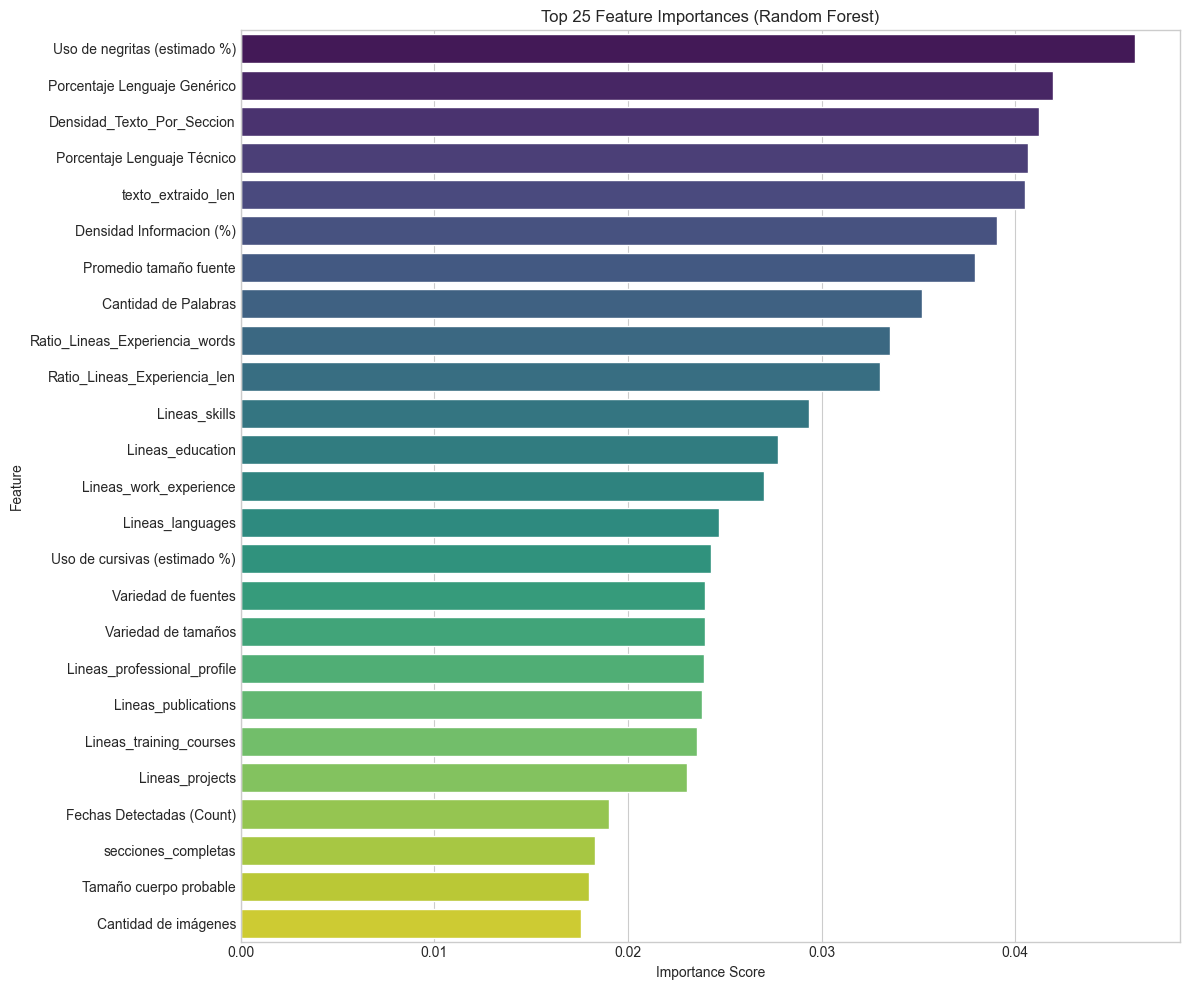

In [36]:
# --- 1. Preparar Datos ---
print("Preparando datos para Random Forest...")

# Define la columna objetivo
target_column = 'Passed'

# Asegúrate de que no haya columnas de identificación o texto aquí
try:
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # --- Manejo de Posibles NaNs (importante para scikit-learn) ---
    # Aunque codificaste, revisemos y imputemos si es necesario (ej. con la media)
    # Nota: Imputar con la media puede no ser ideal para binarias/one-hot,
    # podrías usar strategy='most_frequent' o 'constant' con fill_value=0.
    # Pero para feature importance con RF suele ser aceptable.
    if X.isnull().sum().sum() > 0:
        print(f"Se encontraron {X.isnull().sum().sum()} valores NaN. Imputando con la media...")
        # Guardar nombres de columnas antes de imputar
        feature_names = X.columns
        imputer = SimpleImputer(strategy='mean')
        X = pd.DataFrame(imputer.fit_transform(X), columns=feature_names)
        print("Imputación completada.")
    else:
        feature_names = X.columns
        print("No se encontraron valores NaN en las features.")

    # Convertir a numpy array si es necesario (usualmente no hace falta para RF)
    # X_array = X.values
    # y_array = y.values

    # --- 2. Entrenar Random Forest ---
    print("\nEntrenando Random Forest...")
    # Puedes ajustar n_estimators (número de árboles)
    # class_weight='balanced' ayuda si las clases 0 y 1 están desbalanceadas
    rf_model = RandomForestClassifier(n_estimators=150, # Más árboles para estabilidad
                                      random_state=42,
                                      n_jobs=-1,         # Usar todos los cores disponibles
                                      class_weight='balanced',
                                      oob_score=True)    # Usar Out-of-Bag score para una estimación rápida

    # Entrenar con todos los datos (común para feature importance exploratorio)
    # O podrías dividir en train/test y usar X_train, y_train si prefieres
    rf_model.fit(X, y)

    print(f"Modelo entrenado. OOB Score: {rf_model.oob_score_:.4f}") # Estimación del accuracy

    # --- 3. Extraer y Mostrar Importancia ---
    print("\nCalculando y mostrando importancia de variables...")
    importances = rf_model.feature_importances_

    # Crear un DataFrame para visualizar mejor
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

    # Ordenar por importancia descendente
    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    print("\n--- Importancia de Variables según Random Forest (Top 30) ---")
    print(importance_df.head(30))

    # Guardar la tabla completa en un CSV (opcional)
    # output_importance_file = "importancia_variables_rf.csv"
    # importance_df.to_csv(output_importance_file, index=False)
    # print(f"\nImportancia completa guardada en: {output_importance_file}")

    # --- 4. Graficar Importancias (Opcional) ---
    print("\nGenerando gráfico de importancia (Top 25)...")
    try:
        plt.figure(figsize=(12, 10)) # Ajustar tamaño si es necesario
        n_top_features_plot = 25
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(n_top_features_plot), palette='viridis')
        plt.title(f'Top {n_top_features_plot} Feature Importances (Random Forest)')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("\nPara graficar, necesitas instalar matplotlib y seaborn:")
        print("pip install matplotlib seaborn")
    except Exception as e_plot:
        print(f"\nNo se pudo generar el gráfico: {e_plot}")


except KeyError as e:
    print(f"Error: Columna no encontrada en el DataFrame. Asegúrate que '{target_column}' existe. Detalle: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado durante el análisis de importancia: {e}")

El modelo obtuvo un Out of Bag score del 51%, lo que diría que en un eventual modelo habría una eventual precisión del 51%, apenas mejor que escoger al azar. De acuerdo con esto, no podemos aún decidir con todas las variables, ya que no hay un patrón predictivo claro.

## Análisis de multicorrelación y multicolinealidad

--- Calculando y Visualizando Correlaciones ---


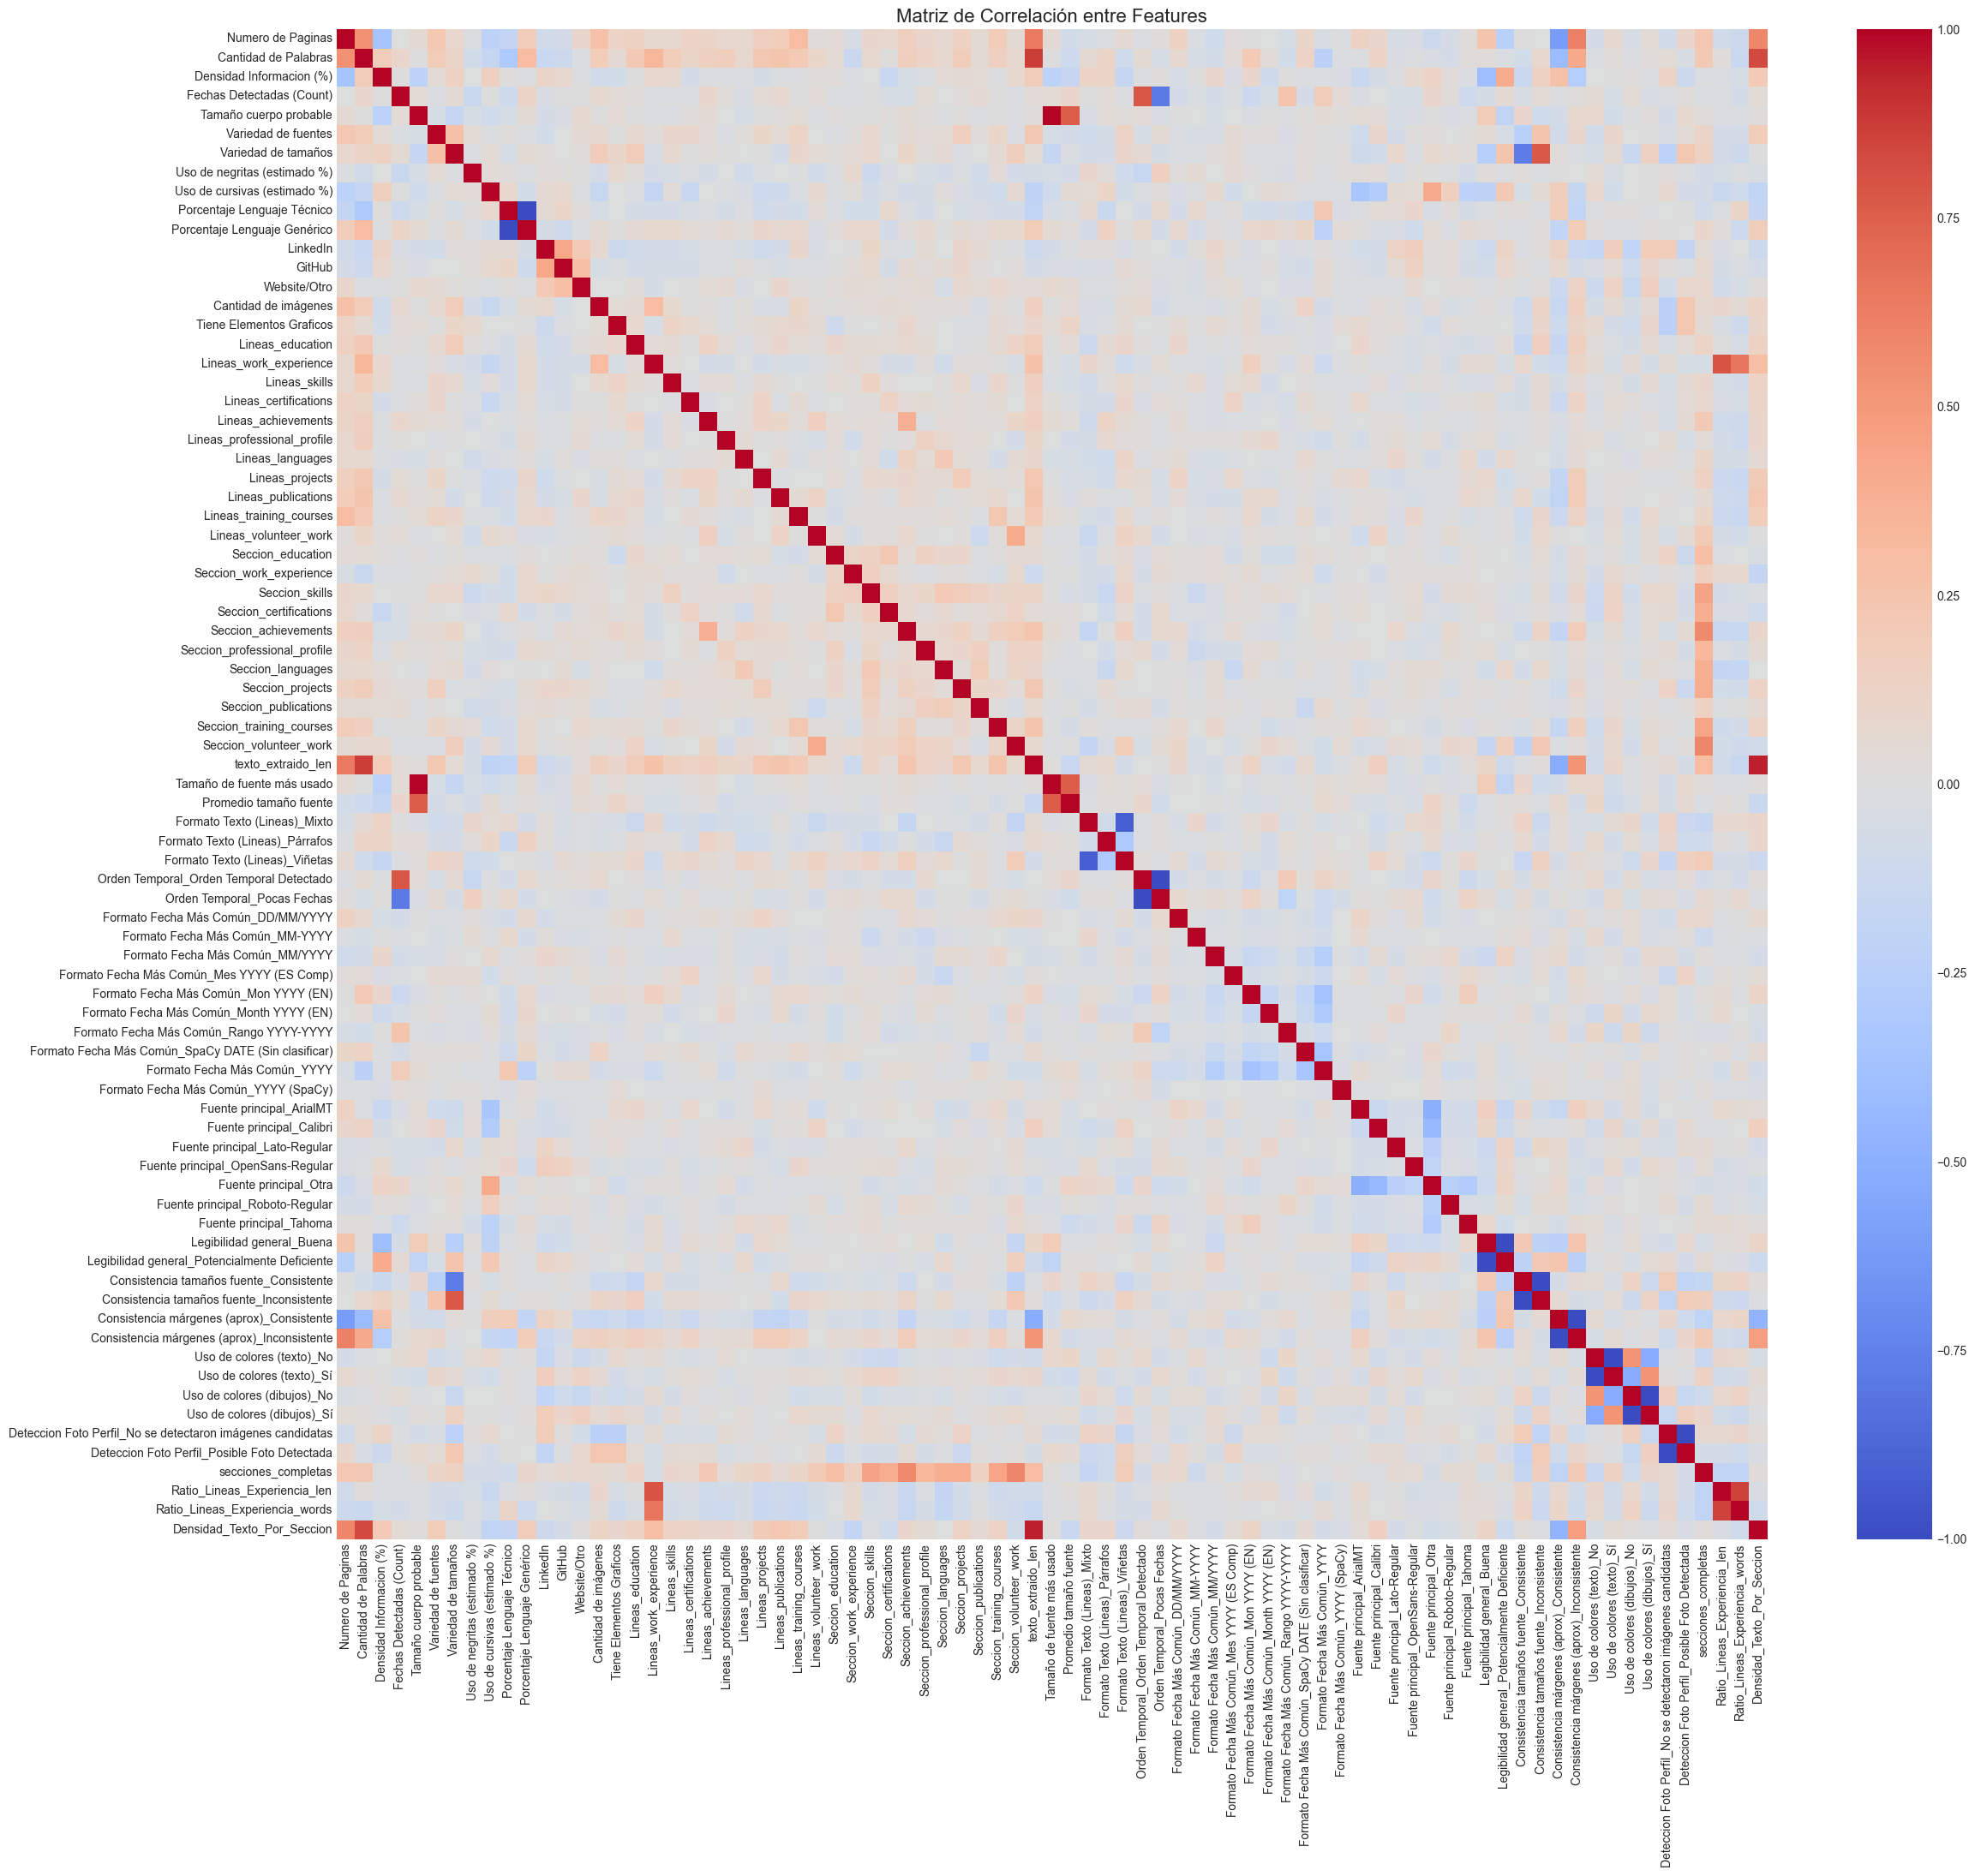


--- Pares de Variables Altamente Correlacionadas (Correlación Absoluta > 0.8) ---
- Porcentaje Lenguaje Genérico y Porcentaje Lenguaje Técnico: -1.0
- texto_extraido_len y Cantidad de Palabras: 0.872
- Tamaño de fuente más usado y Tamaño cuerpo probable: 1.0
- Formato Texto (Lineas)_Viñetas y Formato Texto (Lineas)_Mixto: -0.915
- Orden Temporal_Pocas Fechas y Orden Temporal_Orden Temporal Detectado: -1.0
- Legibilidad general_Potencialmente Deficiente y Legibilidad general_Buena: -1.0
- Consistencia tamaños fuente_Inconsistente y Consistencia tamaños fuente_Consistente: -1.0
- Consistencia márgenes (aprox)_Inconsistente y Consistencia márgenes (aprox)_Consistente: -1.0
- Uso de colores (texto)_Sí y Uso de colores (texto)_No: -1.0
- Uso de colores (dibujos)_Sí y Uso de colores (dibujos)_No: -1.0
- Deteccion Foto Perfil_Posible Foto Detectada y Deteccion Foto Perfil_No se detectaron imágenes candidatas: -1.0
- Ratio_Lineas_Experiencia_words y Ratio_Lineas_Experiencia_len: 0.856
- Densi

In [37]:
print("--- Calculando y Visualizando Correlaciones ---")

# 1. Seleccionar solo columnas numéricas (deberían ser todas excepto 'Passed')
#    y quitar la variable objetivo para analizar correlación entre predictores.
if 'Passed' in df.columns:
    features_df = df.drop(columns=['Passed'])
else:
    features_df = df.copy() # Si 'Passed' no estuviera por alguna razón

# Asegurarse de que solo tenemos tipos numéricos
features_df = features_df.select_dtypes(include=np.number)

# Quitar columnas con varianza cero si las hubiera (pueden dar problemas)
cols_antes = features_df.shape[1]
features_df = features_df.loc[:, features_df.var() > 1e-6] # Umbral pequeño para varianza
if cols_antes > features_df.shape[1]:
    print(f"Se quitaron {cols_antes - features_df.shape[1]} columnas con varianza cercana a cero.")

# 2. Calcular la matriz de correlación
corr_matrix = features_df.corr()

# 3. Visualizar con un Heatmap
# Puede ser grande si tienes muchas variables. Ajusta figsize.
# annot=False es mejor para muchas variables, True muestra los números.
try:
    plt.figure(figsize=(25, 22)) # Ajusta este tamaño según necesites
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f")
    plt.title('Matriz de Correlación entre Features', fontsize=16)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
except Exception as e_plot:
    print(f"Error al generar heatmap: {e_plot}. Mostrando solo matriz.")
    # print(corr_matrix) # Descomentar si el heatmap falla y quieres ver la matriz

# 4. Identificar pares altamente correlacionados
print("\n--- Pares de Variables Altamente Correlacionadas (Correlación Absoluta > 0.8) ---")
threshold = 0.8 # Puedes ajustar este umbral
highly_correlated_pairs = []
# Iterar sobre la matriz triangular superior para evitar duplicados
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            pair_info = (corr_matrix.columns[i], corr_matrix.columns[j], round(corr_matrix.iloc[i, j], 3))
            highly_correlated_pairs.append(pair_info)
            print(f"- {pair_info[0]} y {pair_info[1]}: {pair_info[2]}")

if not highly_correlated_pairs:
    print(f"No se encontraron pares con correlación absoluta > {threshold}")

# 5. Correlación con la variable objetivo (opcional, ya tenemos idea con t-test/chi2)
# print(f"\n--- Correlación con '{target_column}' ---")
# corr_with_target = df.corr()[target_column].sort_values(ascending=False)
# print(corr_with_target.drop(target_column)) # Excluir la correlación consigo misma


In [38]:
# Asumiendo que 'df' está listo y 'features_df' se creó en el paso anterior
# (o vuelve a definir X como en el paso de RF importance si es necesario)
X_vif = features_df # Usar el mismo conjunto de features que para la correlación

print("\n--- Calculando Variance Inflation Factor (VIF) ---")
print("Valores > 5 indican correlación moderada-alta, > 10 indican alta correlación.")

# VIF requiere que no haya NaNs
if X_vif.isnull().sum().sum() > 0:
    print("Error: Se encontraron NaNs. Por favor, impútalos o elimínalos antes de calcular VIF.")
else:
    # Añadir una constante (columna de unos) para calcular VIF correctamente
    # Esto representa el intercepto en una regresión
    X_vif_const = add_constant(X_vif, prepend=True) # prepend=True es más común

    # Calcular VIF para cada variable original (excluyendo la constante)
    try:
        vif_data = pd.DataFrame()
        vif_data["feature"] = X_vif_const.columns[1:] # Nombres de las features originales
        vif_data["VIF"] = [variance_inflation_factor(X_vif_const.values, i)
                           for i in range(1, X_vif_const.shape[1])] # Calcular VIF para cada feature

        # Ordenar por VIF descendente
        vif_data = vif_data.sort_values(by='VIF', ascending=False).reset_index(drop=True)

        print("\n--- Resultados VIF ---")
        print(vif_data)

        # Identificar variables con VIF alto
        high_vif_threshold = 10 # Umbral común (puedes usar 5 si quieres ser más estricto)
        high_vif_features = vif_data[vif_data['VIF'] > high_vif_threshold]['feature'].tolist()

        if high_vif_features:
            print(f"\n*** Variables con VIF > {high_vif_threshold} (potencial multicolinealidad alta): ***")
            print(high_vif_features)
        else:
            print(f"\nNo se encontraron variables con VIF > {high_vif_threshold}.")

    except Exception as e_vif:
        print(f"\nError calculando VIF: {e_vif}")
        print("Esto puede ocurrir por colinealidad perfecta (variables idénticas,")
        print("o una variable es combinación lineal exacta de otras). Revisa los pares altamente correlacionados.")


--- Calculando Variance Inflation Factor (VIF) ---
Valores > 5 indican correlación moderada-alta, > 10 indican alta correlación.

--- Resultados VIF ---
                                  feature       VIF
0              Tamaño de fuente más usado       inf
1   Formato Fecha Más Común_Mon YYYY (EN)       inf
2                       Seccion_education       inf
3                 Seccion_work_experience       inf
4                          Seccion_skills       inf
..                                    ...       ...
74                   Seccion_publications  1.200295
75                       Lineas_languages  1.197767
76                          Lineas_skills  1.191524
77           Uso de negritas (estimado %)  1.168362
78                  Lineas_certifications  1.153789

[79 rows x 2 columns]

*** Variables con VIF > 10 (potencial multicolinealidad alta): ***
['Tamaño de fuente más usado', 'Formato Fecha Más Común_Mon YYYY (EN)', 'Seccion_education', 'Seccion_work_experience', 'Seccion_sk

In [39]:
df

Passed  Numero de Paginas  Cantidad de Palabras  \
0         1                  2                   493   
1         1                  1                   388   
2         1                  1                   378   
3         1                  4                   656   
4         1                  3                   160   
..      ...                ...                   ...   
630       0                  6                  1372   
631       0                 10                  3729   
632       0                  3                   899   
633       0                  1                   185   
634       0                  4                   534   

     Densidad Informacion (%)  Fechas Detectadas (Count)  \
0                        5.71                          3   
1                        8.09                          1   
2                        8.27                          0   
3                        3.54                          2   
4                        4.71                          0   
..                        ...                        ...   
630                      4.37                          0   
631                      7.54                          3   
632                      6.13                          1   
633                      3.93                          2   
634                      5.95                          0   

     Tamaño cuerpo probable  Variedad de fuentes  Variedad de tamaños  \
0                        12                    7                    5   
1                         9                    1                    1   
2                        10                    3                    4   
3                        10                    4                   12   
4                        10                    6                    7   
..                      ...                  ...                  ...   
630                      11                    8                    6   
631                      11                    7                    8   
632                      11                    4                    6   
633                      10                    2                    4   
634                      11                    3                    2   

     Uso de negritas (estimado %)  Uso de cursivas (estimado %)  \
0                            34.4                          91.7   
1                             0.0                         100.0   
2                            21.8                         100.0   
3                            16.2                         100.0   
4                            31.2                           5.2   
..                            ...                           ...   
630                          32.7                          36.8   
631                           8.1                           5.4   
632                          62.7                           4.5   
633                           0.0                         100.0   
634                          39.9                           0.5   

     Porcentaje Lenguaje Técnico  Porcentaje Lenguaje Genérico  LinkedIn  \
0                           3.72                         96.28         1   
1                           9.61                         90.39         0   
2                           8.58                         91.42         0   
3                           6.67                         93.33         0   
4                          11.29                         88.71         1   
..                           ...                           ...       ...   
630                         6.72                         93.28         0   
631                         2.71                         97.29         0   
632                         5.04                         94.96         0   
633                         6.25                         93.75         0   
634                         5.55                         94.45         1   

     GitHub  Web

### Eliminación de variables
Eliminaremos las variables con VIF Infinito o grande, así como con alta correlacion entre ellas que puedan estar causando multicolinealidad.

In [40]:
print("--- Eliminando Variables Redundantes / Multicolineares ---")

# --- Definir lista de variables a ELIMINAR ---
variables_to_drop = [
    # Perfecta (-1.0) / Complementarias / One-Hot (Mantener 1 de cada par/grupo)
    'Porcentaje Lenguaje Genérico', # Mantener 'Porcentaje Lenguaje Técnico'
    'Orden Temporal_Pocas Fechas', # Mantener 'Orden Temporal_Orden Temporal Detectado'
    'Legibilidad general_Potencialmente Deficiente', # Mantener 'Legibilidad general_Buena'
    'Legibilidad general_Vacío', # Mantener 'Legibilidad general_Buena' como referencia principal
    'Consistencia tamaños fuente_Inconsistente', # Mantener 'Consistencia tamaños fuente_Consistente'
    'Consistencia márgenes (aprox)_Inconsistente', # Mantener 'Consistencia márgenes (aprox)_Consistente'
    'Uso de colores (texto)_No', # Mantener 'Uso de colores (texto)_Sí'
    'Uso de colores (dibujos)_No', # Mantener 'Uso de colores (dibujos)_Sí'
    'Deteccion Foto Perfil_No se detectaron imágenes candidatas', # Mantener 'Deteccion Foto Perfil_Posible Foto Detectada'

    # Perfecta (1.0)
    'Tamaño de fuente más usado', # Mantener 'Tamaño cuerpo probable' (o 'Promedio tamaño fuente')

    # Alta Correlación / Redundancia / Alto VIF
    'Cantidad de Palabras', # Mantener 'texto_extraido_len'
    'Ratio_Lineas_Experiencia_words', # Mantener 'Ratio_Lineas_Experiencia_len'
    'Densidad_Texto_Por_Seccion', # Muy correlacionada con 'texto_extraido_len'

    # Flags de Sección Individuales (Redundantes con 'secciones_completas')
    # Mantenemos 'secciones_completas' (fuerte en T-test)
    # Mantenemos 'Seccion_training_courses' (significativa Chi2)
    # Mantenemos 'Seccion_languages' y 'Seccion_publications' (borderline Chi2, revisar VIF final)
    'Seccion_education',
    'Seccion_work_experience',
    'Seccion_skills',
    'Seccion_achievements',
    'Seccion_professional_profile',
    'Seccion_projects',
    'Seccion_volunteer_work',
    'Seccion_certifications', # También tenía VIF infinito y no fue signif. en Chi2

    # Limpieza One-Hot Encoding (K-1) - **¡¡REVISAR Y AJUSTAR ESTAS!!**
    # Formato Texto (Lineas): Asumiendo 3 categorías, eliminamos 1 (ej. Mixto)
    'Formato Texto (Lineas)_Mixto', # Mantenemos _Párrafos y _Viñetas

    # Fuente principal: Eliminamos la mayoría, mantenemos _Tahoma (borderline) y _Otra (si existe)
    # Ajusta esto basado en las fuentes reales y cuáles quieres mantener como referencia
    'Fuente principal_Lato-Regular',
    'Fuente principal_OpenSans-Regular',
    'Fuente principal_Roboto-Regular',
    'Fuente principal_Ninguna',
    # Mantenemos 'Fuente principal_Tahoma' y 'Fuente principal_Otra' (si existe)

    # Formato Fecha Más Común: Eliminamos la mayoría. Mantenemos _MM/YYYY (borderline) y quizás la más común.
    # Ajusta basado en tus formatos reales y su frecuencia/importancia
    'Formato Fecha Más Común_DD/MM/YYYY',
    'Formato Fecha Más Común_Mes YYYY (ES Comp)', # Asegúrate que este nombre sea correcto
    'Formato Fecha Más Común_Month YYYY (EN)', # Asegúrate que este nombre sea correcto
    'Formato Fecha Más Común_Rango YYYY-YYYY', # Asegúrate que este nombre sea correcto
    'Formato Fecha Más Común_SpaCy DATE (Sin clasificar)',
    'Formato Fecha Más Común_YYYY (SpaCy)',
    # Mantenemos 'Formato Fecha Más Común_MM/YYYY'
    # Mantenemos 'Formato Fecha Más Común_YYYY (EN)' (Ejemplo, si es la más común)

    # Columna índice sin nombre (si existe)
    # El archivo CSV empezaba con ',', así que la primera columna es probablemente el índice
    df.columns[0] # Añade el nombre de la primera columna a la lista
]

# Filtrar la lista para asegurar que solo intentamos eliminar columnas que realmente existen en df
variables_existentes_a_eliminar = [col for col in variables_to_drop if col in df.columns]
variables_no_encontradas = [col for col in variables_to_drop if col not in df.columns]

if variables_no_encontradas:
    print("\nAdvertencia: Las siguientes variables a eliminar no se encontraron en el DataFrame:")
    print(variables_no_encontradas)

# Crear el nuevo DataFrame reducido
df_reducido = df.drop(columns=variables_existentes_a_eliminar, errors='ignore') # errors='ignore' por si acaso

print(f"\nSe eliminaron {len(variables_existentes_a_eliminar)} variables.")
# print("Variables eliminadas:", variables_existentes_a_eliminar) # Descomentar si quieres ver la lista completa
print(f"\nQuedan {df_reducido.shape[1]} columnas.")
print("Variables restantes:", df_reducido.columns.tolist())


# --- Paso 2: Recalcular VIF en el DataFrame Reducido ---
print("\n--- Calculando VIF en el conjunto reducido de features ---")
print("Idealmente, la mayoría de los VIFs deberían ser < 5 o < 10.")

# Seleccionar predictores del df reducido (todas menos 'Passed')
if 'Passed' in df_reducido.columns:
    X_reducido = df_reducido.drop(columns=['Passed'])
else:
    print("Advertencia: No se encontró la columna 'Passed' en df_reducido.")
    X_reducido = df_reducido.copy()

# Asegurar que son numéricas
X_reducido = X_reducido.select_dtypes(include=np.number)

# Verificar NaNs de nuevo
if X_reducido.isnull().sum().sum() > 0:
    print("Error: Se encontraron NaNs en las features reducidas. Revisar proceso de limpieza/imputación.")
    # Considera imputar aquí si es necesario:
    # imputer_reducido = SimpleImputer(strategy='mean')
    # X_reducido = pd.DataFrame(imputer_reducido.fit_transform(X_reducido), columns=X_reducido.columns)
    # print("NaNs imputados en el conjunto reducido.")
else:
    # Añadir constante
    X_reducido_const = add_constant(X_reducido, prepend=True, has_constant='raise') # has_constant='raise' por si ya existe

    # Calcular VIF
    try:
        vif_data_reducido = pd.DataFrame()
        vif_data_reducido["feature"] = X_reducido_const.columns[1:] # Nombres originales
        # Calcular VIF para cada feature
        vif_values = []
        for i in range(1, X_reducido_const.shape[1]):
            try:
                 vif = variance_inflation_factor(X_reducido_const.values, i)
                 vif_values.append(vif)
            except Exception as e_vif_calc:
                 print(f"  - Advertencia: No se pudo calcular VIF para {X_reducido_const.columns[i+1]}. Asignando Inf. Error: {e_vif_calc}")
                 vif_values.append(np.inf) # Asignar infinito si hay error

        vif_data_reducido["VIF"] = vif_values


        # Ordenar y mostrar
        vif_data_reducido = vif_data_reducido.sort_values(by='VIF', ascending=False).reset_index(drop=True)
        print("\n--- Resultados VIF (Reducido) ---")
        pd.set_option('display.max_rows', None) # Mostrar todas las filas
        print(vif_data_reducido)
        pd.reset_option('display.max_rows') # Restaurar opción

        # Verificar si aún hay VIFs altos
        high_vif_threshold = 10 # Umbral común
        high_vif_features_reducido = vif_data_reducido[vif_data_reducido['VIF'] > high_vif_threshold]['feature'].tolist()
        if high_vif_features_reducido:
            print(f"\n*** ALERTA: Variables con VIF > {high_vif_threshold} aún presentes en el conjunto reducido: ***")
            print(high_vif_features_reducido)
        else:
            print(f"\n¡Bien! No se encontraron variables con VIF > {high_vif_threshold} en el conjunto reducido.")

    except Exception as e_vif_reducido:
        print(f"\nError general calculando VIF en el conjunto reducido: {e_vif_reducido}")
        print("Revisa si aún existe colinealidad perfecta.")

--- Eliminando Variables Redundantes / Multicolineares ---

Advertencia: Las siguientes variables a eliminar no se encontraron en el DataFrame:
['Legibilidad general_Vacío', 'Fuente principal_Ninguna']

Se eliminaron 31 variables.

Quedan 49 columnas.
Variables restantes: ['Numero de Paginas', 'Densidad Informacion (%)', 'Fechas Detectadas (Count)', 'Tamaño cuerpo probable', 'Variedad de fuentes', 'Variedad de tamaños', 'Uso de negritas (estimado %)', 'Uso de cursivas (estimado %)', 'Porcentaje Lenguaje Técnico', 'LinkedIn', 'GitHub', 'Website/Otro', 'Cantidad de imágenes', 'Tiene Elementos Graficos', 'Lineas_education', 'Lineas_work_experience', 'Lineas_skills', 'Lineas_certifications', 'Lineas_achievements', 'Lineas_professional_profile', 'Lineas_languages', 'Lineas_projects', 'Lineas_publications', 'Lineas_training_courses', 'Lineas_volunteer_work', 'Seccion_languages', 'Seccion_publications', 'Seccion_training_courses', 'texto_extraido_len', 'Promedio tamaño fuente', 'Formato Texto

In [41]:
variable_passed = df['Passed']
df_reducido['Passed'] = variable_passed

In [42]:
df_reducido

Numero de Paginas  Densidad Informacion (%)  Fechas Detectadas (Count)  \
0                    2                      5.71                          3   
1                    1                      8.09                          1   
2                    1                      8.27                          0   
3                    4                      3.54                          2   
4                    3                      4.71                          0   
..                 ...                       ...                        ...   
630                  6                      4.37                          0   
631                 10                      7.54                          3   
632                  3                      6.13                          1   
633                  1                      3.93                          2   
634                  4                      5.95                          0   

     Tamaño cuerpo probable  Variedad de fuentes  Variedad de tamaños  \
0                        12                    7                    5   
1                         9                    1                    1   
2                        10                    3                    4   
3                        10                    4                   12   
4                        10                    6                    7   
..                      ...                  ...                  ...   
630                      11                    8                    6   
631                      11                    7                    8   
632                      11                    4                    6   
633                      10                    2                    4   
634                      11                    3                    2   

     Uso de negritas (estimado %)  Uso de cursivas (estimado %)  \
0                            34.4                          91.7   
1                             0.0                         100.0   
2                            21.8                         100.0   
3                            16.2                         100.0   
4                            31.2                           5.2   
..                            ...                           ...   
630                          32.7                          36.8   
631                           8.1                           5.4   
632                          62.7                           4.5   
633                           0.0                         100.0   
634                          39.9                           0.5   

     Porcentaje Lenguaje Técnico  LinkedIn  GitHub  Website/Otro  \
0                           3.72         1       0             1   
1                           9.61         0       0             1   
2                           8.58         0       0             0   
3                           6.67         0       0             0   
4                          11.29         1       1             0   
..                           ...       ...     ...           ...   
630                         6.72         0       0             1   
631                         2.71         0       0             0   
632                         5.04         0       0             0   
633                         6.25         0       0             0   
634                         5.55         1       0             0   

     Cantidad de imágenes  Tiene Elementos Graficos  Lineas_education  \
0                       0                         0                 6   
1                       9                         1                 8   
2                       0                         1                 3   
3                       3                         1                25   
4                       5                         1                 0   
..                    ...                       ...               ...   
630                     8                     

In [43]:
df_reducido.to_csv('../Bases/base_cvs/datos_para_clusterisar.csv', index=False)

### Feature importance (otra vez)
Al realizar el feature importance sin el ruido de la multicolinealidad, posiblemente obtengamos insights en mejores variables para un modelo predictivo que los t-test y chi-cuadrado ignoraron por no ser tan lineales.

--- Recalculando Feature Importance con el conjunto reducido ---
No se encontraron valores NaN en las features finales.

Entrenando Random Forest con el conjunto de features reducido...
Modelo (reducido) entrenado. OOB Score: 0.5342

Calculando y mostrando importancia de variables (conjunto reducido)...

--- Importancia de Variables según Random Forest (Conjunto Reducido - Top 30) ---
                         Feature  Importance
0    Porcentaje Lenguaje Técnico    0.060878
1   Uso de negritas (estimado %)    0.059902
2             texto_extraido_len    0.056464
3       Densidad Informacion (%)    0.052648
4         Promedio tamaño fuente    0.048213
5   Ratio_Lineas_Experiencia_len    0.046659
6               Lineas_education    0.039764
7         Lineas_work_experience    0.039081
8    Lineas_professional_profile    0.035266
9                  Lineas_skills    0.035232
10           Variedad de tamaños    0.034025
11           Lineas_publications    0.032974
12           Variedad de fu

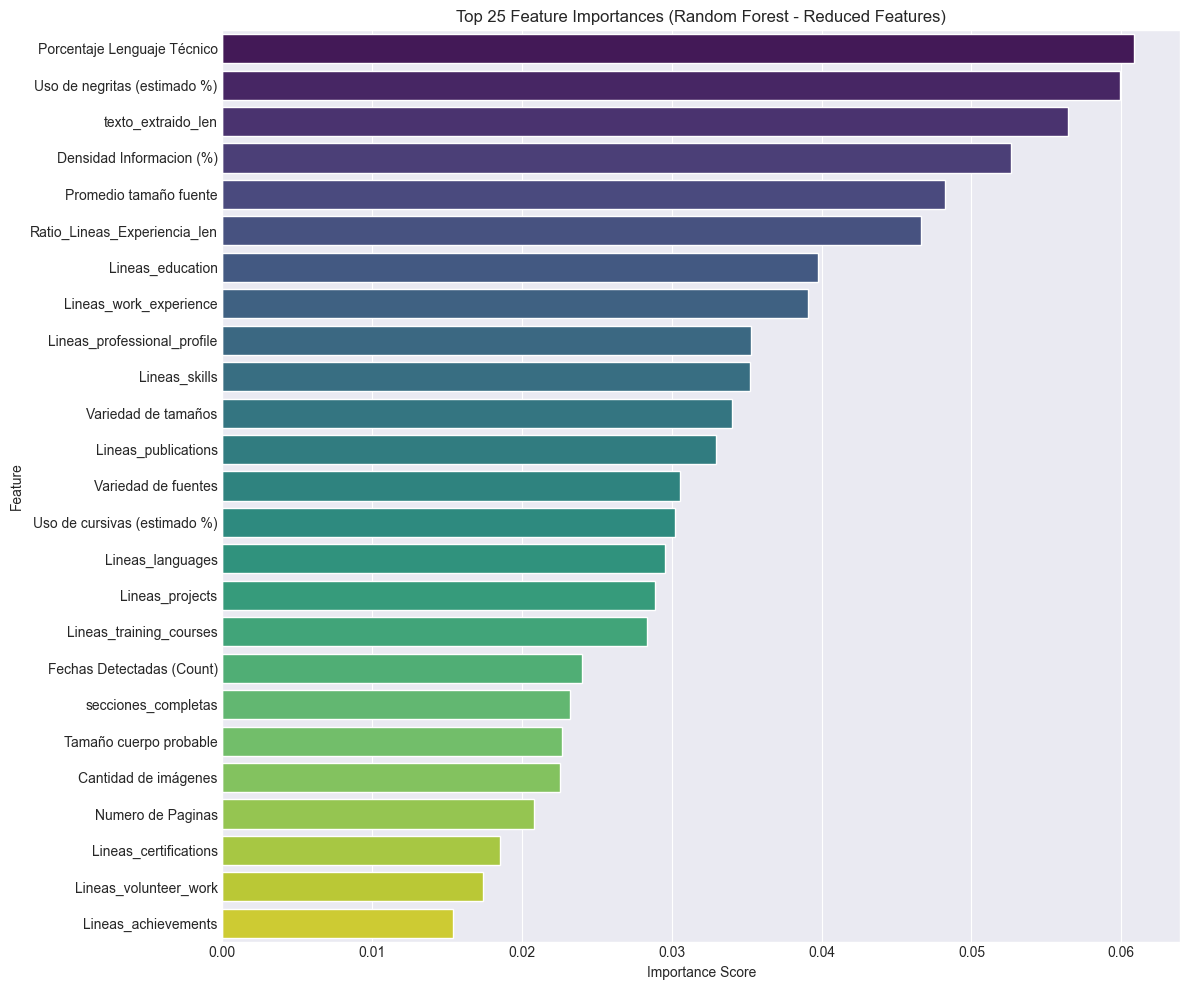

In [44]:
# --- Asumiendo que 'df_reducido' es tu DataFrame después de eliminar variables ---

print("--- Recalculando Feature Importance con el conjunto reducido ---")

# --- 1. Preparar Datos (usando df_reducido) ---
target_column = 'Passed'

if target_column not in df_reducido.columns:
    print(f"Error: La columna objetivo '{target_column}' no está en df_reducido.")
    # Salir o manejar el error
    X_final = None
else:
    X_final = df_reducido.drop(columns=[target_column])
    y_final = df_reducido[target_column]

    # Verificar y eliminar columnas con varianza cero (como la posible 'Fuente principal_Ninguna')
    cols_antes = X_final.shape[1]
    variances = X_final.var()
    cols_zero_variance = variances[variances <= 1e-8].index.tolist() # Umbral muy pequeño
    if cols_zero_variance:
        print(f"Eliminando {len(cols_zero_variance)} columnas con varianza cercana a cero: {cols_zero_variance}")
        X_final = X_final.drop(columns=cols_zero_variance)
        print(f"Quedan {X_final.shape[1]} features para el análisis.")

    feature_names_final = X_final.columns

    # Verificar NaNs (no deberían quedar, pero por si acaso)
    if X_final.isnull().sum().sum() > 0:
        print(f"ADVERTENCIA: Se encontraron {X_final.isnull().sum().sum()} NaNs en el DataFrame reducido. Imputando con la media...")
        imputer_final = SimpleImputer(strategy='mean')
        X_final = pd.DataFrame(imputer_final.fit_transform(X_final), columns=feature_names_final)
    else:
        print("No se encontraron valores NaN en las features finales.")


    # --- 2. Entrenar Random Forest (con datos reducidos) ---
    print("\nEntrenando Random Forest con el conjunto de features reducido...")
    rf_model_final = RandomForestClassifier(n_estimators=150,
                                             random_state=42,
                                             n_jobs=-1,
                                             class_weight='balanced',
                                             oob_score=True)

    rf_model_final.fit(X_final, y_final)
    print(f"Modelo (reducido) entrenado. OOB Score: {rf_model_final.oob_score_:.4f}")

    # --- 3. Extraer y Mostrar Importancia (con datos reducidos) ---
    print("\nCalculando y mostrando importancia de variables (conjunto reducido)...")
    importances_final = rf_model_final.feature_importances_

    importance_df_final = pd.DataFrame({'Feature': feature_names_final, 'Importance': importances_final})
    importance_df_final = importance_df_final.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    print("\n--- Importancia de Variables según Random Forest (Conjunto Reducido - Top 30) ---")
    pd.set_option('display.max_rows', 30) # Mostrar hasta 30 filas
    print(importance_df_final.head(30))
    pd.reset_option('display.max_rows') # Restaurar opción

    # --- 4. Graficar Importancias (Opcional) ---
    print("\nGenerando gráfico de importancia (reducido - Top 25)...")
    try:
        plt.figure(figsize=(12, 10)) # Ajustar tamaño si es necesario
        n_top_features_plot = 25
        # Asegurarse de que no intentamos graficar más features de las que hay
        n_top_features_plot = min(n_top_features_plot, len(importance_df_final))
        sns.barplot(x='Importance', y='Feature', data=importance_df_final.head(n_top_features_plot), palette='viridis')
        plt.title(f'Top {n_top_features_plot} Feature Importances (Random Forest - Reduced Features)')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("\nPara graficar, necesitas instalar matplotlib y seaborn:")
        print("pip install matplotlib seaborn")
    except Exception as e_plot:
        print(f"\nNo se pudo generar el gráfico: {e_plot}")

### Conclusiones antes de Modelar

En primer lugar, vemos que eliminar las variables con multicolinealidad nos dio un OOB Score de casi 53%, dejandonos con la impresión de que mejora un poco en predicción, aunque no es suficiente y es necesario continuar explorando nuestras variables para llegar a una mayor precisión.

Por otro lado, la feature importance nos trae que aunque en términos de medias, la variable Porcentaje Lenguaje Técnico no parecía importante para pasar o no, de acuerdo a la clasificación Random Forest si puede llegar a ser importante para la predicción. Siendo así podemos decir que tener un mayor % de lenguaje técnico puede que haga que una HV pase a una siguiente étapa.

De la misma manera, se mantienen en importancia la longitud del texto extraido así como el uso de negritas estimado, variables que veíamos en las pruebas anteriores mostraban importancia.

De la misma manera, todas las variables que en las pruebas t-test y Chi-cuadrado se encuentran dentro del top-30, aunque distribuidas, confirman la importancia de las mismas para un eventual modelo.

#### Antes de modelar:
- El Random Forest sigue sugiriendo que la predicción es difícil (OOB bajo). Por lo mismo, intentaremos seguir el refinamiento de variables y buscar aumentar su posibilidad o no de avanzar.
- Las variables más importantes parecen ser una mezcla de contenido (% Técnico, longitud), estilo (% Negritas, tamaño fuente) y estructura (Lineas_..., secciones_completas).

#### La base para empezar el modelado quedará
##### Variables Numéricas:

- Porcentaje Lenguaje Técnico (RF Alto)
- texto_extraido_len (T-test signif, RF Alto)
- Uso de negritas (estimado %) (RF Alto, T-test Border)
- Densidad Informacion (%) (RF Moderado)
- Ratio_Lineas_Experiencia_len (RF Moderado)
- Promedio tamaño fuente (RF Moderado)
- Lineas_work_experience (RF Moderado)
- Lineas_training_courses (RF Moderado, Sección signif Chi2)
- Variedad de tamaños (RF Moderado)
- secciones_completas (T-test signif, RF Bajo-Medio)
- Numero de Paginas (T-test Border, RF Bajo)
- Variedad de tamaños(VIF bajo)
- Variedad de fuentes(VIF bajo)
- Uso de cursivas (estimado %) (VIF bajo)
- Cantidad de imágenes (VIF bajo)
- Fechas Detectadas (RF Moderado)

##### Variables Binarias (0/1):

- Website/Otro (Chi2 signif)
- Seccion_training_courses (Flag - Chi2 signif)
- Uso de colores (texto)_Sí (Chi2 Border)
- Legibilidad general_Buena (Para representar legibilidad)
- Consistencia tamaños fuente_Consistente (Para representar consistencia)
- Orden Temporal_Orden Temporal Detectado (Representa Orden Temporal)
- Legibilidad general_Buena (Representa Legibilidad)
- Consistencia tamaños fuente_Consistente (Representa Consistencia Tamaño)
- Consistencia márgenes (aprox)_Consistente (Representa Consistencia Márgenes)
- Deteccion Foto Perfil_Posible Foto Detectada (Representa si tiene foto)
- Formato Texto (Lineas)_Párrafos (Representa el tipo de texto Parrafo)
- Formato Texto (Lineas)_Viñetas'  (Representa el tipo de texto Viñetas o 'Bullet points')
- Fuente principal_Tahoma (borderline Chi2)
- Fuente principal_Otra (Representa otro tipo de fuentes)
- Formato Fecha Más Común_MM/YYYY' (borderline Chi2)
- Formato Fecha Más Común_YYYY (EN) (Formato de fecha más frecuente)
- Tiene Elementos Graficos (VIF bajo)
- LinkedIn (VIF bajo)
- GitHub (VIF bajo)
- Seccion_languages (Borderline Chi2, VIF bajo)
- Seccion_publications (Borderline Chi2, VIF bajo)

De acuerdo con lo anterior, vemos que tenemos variables que representan las características que buscabamos extraer, además de las que cuentan con score RF alto o moderado, tienen un VIF bajo y fueron relevantes en las pruebas t-test y chi-cuadrado.

In [45]:
# Asumiendo que 'df_reducido' es tu DataFrame DESPUÉS de eliminar las variables
# con alta multicolinealidad/redundancia y CUALQUIER columna con varianza cero
# (como 'Fuente principal_Ninguna' si fue el caso).

print(f"Número de columnas en df_reducido antes de seleccionar: {df_reducido.shape[1]}")
print("Columnas disponibles:", df_reducido.columns.tolist())

# --- 1. Definir las columnas FINALES para guardar ---
# (Basado en la interpretación de T-test, Chi2, RF y VIF final)
columns_to_keep_for_modeling = [
    'Passed', # ¡Importante incluir la variable objetivo!

    # --- Features Numéricas Seleccionadas ---
    'secciones_completas',
    'texto_extraido_len',
    'Porcentaje Lenguaje Técnico',
    'Uso de negritas (estimado %)',
    'Ratio_Lineas_Experiencia_len',
    'Promedio tamaño fuente',           # Métrica de tamaño de fuente elegida
    'Densidad Informacion (%)',
    'Lineas_training_courses',        # Conteo de líneas para la sección signif.
    'Numero de Paginas',
    'Variedad de tamaños',            # VIF bajo
    'Variedad de fuentes',            # VIF bajo
    'Uso de cursivas (estimado %)',   # VIF bajo
    'Cantidad de imágenes',           # VIF bajo
    'Fechas Detectadas (Count)',    # VIF bajo

    # --- Features Binarias Seleccionadas (Flags / Dummies K-1) ---
    'Website/Otro',                   # Significativa Chi2
    'Seccion_training_courses',       # Flag - Significativa Chi2
    'Uso de colores (texto)_Sí',      # Borderline Chi2, VIF bajo
    'Orden Temporal_Orden Temporal Detectado', # Representa Orden Temporal
    'Legibilidad general_Buena',      # Representa Legibilidad
    'Consistencia tamaños fuente_Consistente', # Representa Consistencia Tamaño
    'Consistencia márgenes (aprox)_Consistente',# Representa Consistencia Márgenes
    'Deteccion Foto Perfil_Posible Foto Detectada', # Representa Foto
    'Formato Texto (Lineas)_Párrafos', # Dummy 1 para Formato Texto (asumiendo 3 cats)
    'Formato Texto (Lineas)_Viñetas',  # Dummy 2 para Formato Texto
    'Fuente principal_Tahoma',         # Dummy específico de Fuente (borderline Chi2)
    'Fuente principal_Otra',        # Opcional: Incluir si es una categoría relevante que quedó
    'Formato Fecha Más Común_MM/YYYY',# Dummy específico de Fecha (borderline Chi2)
    'Formato Fecha Más Común_YYYY',
    'Tiene Elementos Graficos',       # VIF bajo, mantener por ahora
    'LinkedIn',                       # VIF bajo, mantener por ahora
    'GitHub',                         # VIF bajo, mantener por ahora
    'Seccion_languages',            # Opcional: Borderline Chi2, VIF bajo
    'Seccion_publications',         # Opcional: Borderline Chi2, VIF bajo
]

# --- 2. Verificar y Crear DataFrame Final ---

# Asegurarse de que todas las columnas seleccionadas realmente existen en df_reducido
existing_cols_to_keep = [col for col in columns_to_keep_for_modeling if col in df_reducido.columns]
missing_cols = [col for col in columns_to_keep_for_modeling if col not in df_reducido.columns]

if missing_cols:
    print("\nADVERTENCIA: Las siguientes columnas seleccionadas NO existen en df_reducido y serán omitidas:")
    print(missing_cols)
    print("Revisa la lista 'columns_to_keep_for_modeling' o el proceso de limpieza previo.")

if not existing_cols_to_keep or 'Passed' not in existing_cols_to_keep:
     print("\nERROR: No se pueden guardar los datos. Faltan columnas esenciales ('Passed') o la lista está vacía.")
else:
     # Crear el DataFrame final solo con las columnas seleccionadas y existentes
     df_modelar = df_reducido[existing_cols_to_keep].copy()
     print(f"\nSe ha creado el DataFrame 'df_modelar' con {df_modelar.shape[1]} columnas (incluyendo 'Passed').")
     print("Columnas finales:", df_modelar.columns.tolist())

     # --- 3. Guardar en CSV ---
     output_csv_path = '../Bases/base_cvs/datos_para_modelar_cv.csv' # Nombre del archivo de salida
     try:
          # index=False evita que pandas guarde el índice del DataFrame como una columna en el CSV
          # encoding='utf-8-sig' ayuda a la compatibilidad con Excel para caracteres especiales
          df_modelar.to_csv(output_csv_path, index=False, encoding='utf-8-sig')
          print(f"\n¡DataFrame para modelado guardado exitosamente en '{output_csv_path}'!")
          print("Puedes cargar este archivo en tu nuevo notebook.")
     except Exception as e_save:
          print(f"\nError al guardar el archivo CSV: {e_save}")


Número de columnas en df_reducido antes de seleccionar: 50
Columnas disponibles: ['Numero de Paginas', 'Densidad Informacion (%)', 'Fechas Detectadas (Count)', 'Tamaño cuerpo probable', 'Variedad de fuentes', 'Variedad de tamaños', 'Uso de negritas (estimado %)', 'Uso de cursivas (estimado %)', 'Porcentaje Lenguaje Técnico', 'LinkedIn', 'GitHub', 'Website/Otro', 'Cantidad de imágenes', 'Tiene Elementos Graficos', 'Lineas_education', 'Lineas_work_experience', 'Lineas_skills', 'Lineas_certifications', 'Lineas_achievements', 'Lineas_professional_profile', 'Lineas_languages', 'Lineas_projects', 'Lineas_publications', 'Lineas_training_courses', 'Lineas_volunteer_work', 'Seccion_languages', 'Seccion_publications', 'Seccion_training_courses', 'texto_extraido_len', 'Promedio tamaño fuente', 'Formato Texto (Lineas)_Párrafos', 'Formato Texto (Lineas)_Viñetas', 'Orden Temporal_Orden Temporal Detectado', 'Formato Fecha Más Común_MM-YYYY', 'Formato Fecha Más Común_MM/YYYY', 'Formato Fecha Más Común